In [1]:
import numpy as np
import os
from spectral_cube import SpectralCube
import pandas as pd
import sys
sys.path.append('../')
import velocity_tools.velocity_tools.stream_lines as SL
from scipy import ndimage
# astropy
# from astropy.modeling.models import Gaussian1D
import astropy.units as u
from astropy.wcs import WCS
from astropy.io import fits, ascii
from astropy.coordinates import SkyCoord, FK5
from astropy.visualization.wcsaxes import add_beam, add_scalebar
# import aplpy
from regions import Regions
from pvextractor import PathFromCenter

# matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import Rectangle
# import matplotlib.ticker as mticker
# from matplotlib.patches import Circle, Ellipse
# from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from matplotlib import gridspec
from matplotlib import cm
from matplotlib.colors import AsinhNorm
import seaborn as sns
from scipy.stats import gaussian_kde

from copy import copy

%matplotlib inline

In [2]:
hc3nfile = 'data/NGC1333_HC3N_L24-merged_small_K.fits'
hc3nmom0file = 'data/NGC1333_HC3N_L24-merged_small_K_-3.0_18.0_mom0.fits'
hc3nmom0_cloudrangefile = 'data/NGC1333_HC3N_L24-merged_small_K_5.0_10.0_mom0.fits'
hc3nrmsfile = 'data/NGC1333_HC3N_L24-merged_small_K_rms.fits'
hc3nsnrfile = 'data/NGC1333_HC3N_L24-merged_small_K_-3.0_18.0_snr.fits'
sourcecat = 'data/my_catalog_vel.csv'
xraycat = 'data/xray_sources_NGC1333_phot_SE.csv'

n2hpfile = 'data/NGC1333-N2Hp_match_kms_F1F_01_12.fits'
n2hpmom0file = 'data/NGC1333-N2Hp_match_kms_F1F_01_12_K_5_10_mom0.fits'
n2hpparamsfile = 'first_look/fit_N2Hp/NGC1333-N2Hp_match_fit_near_thick.fits'

n2hpmlex1file = 'bayes_frame/nested-sampling/N2Hp/NGC1333-SE-mle-x1_filtered_QA.fits'
n2hpmlex2file = 'bayes_frame/nested-sampling/N2Hp/NGC1333-SE-mle-x2_filtered_QA.fits'

hc3nmlex1file = 'bayes_frame/nested-sampling/HC3N/NGC1333-SE-mle-x1_filtered_QA.fits'
hc3nmlex2file = 'bayes_frame/nested-sampling/HC3N/NGC1333-SE-mle-x2_filtered_QA.fits'
hc3nmlex3file = 'bayes_frame/nested-sampling/HC3N/NGC1333-SE-mle-x3_filtered_QA.fits'

ncompfile = 'first_look/gaussfit/diagnosticAIC/ncomponents_AIC.fits'
ncompflagfile = 'first_look/gaussfit/diagnosticAIC/ncomponents_AIC_flag.fits'

ncompfilebayes = 'bayes_frame/nested-sampling/HC3N/npeaks_cut5_noislands_QA.fits'

n2hpncompfilebayes = 'bayes_frame/nested-sampling/N2Hp/npeaks_cut5_noislands_QA.fits'

distance = 298 # pc
scalebarsize = 10000 #au
scalebarsize_arcsec = scalebarsize / distance * u.arcsec

In [3]:
hc3nmom0, header2dhc3n = fits.getdata(hc3nmom0file, header=True)
mom0hc3n_cloud = fits.getdata(hc3nmom0_cloudrangefile)
wcs = WCS(header2dhc3n)
hc3nsnr = fits.getdata(hc3nsnrfile)

bmaj, bmin, bpa = np.array([header2dhc3n['bmaj'], header2dhc3n['bmin'], header2dhc3n['bpa']]) * u.deg
cubehc3n = SpectralCube.read(hc3nfile)
catalog_protostars = pd.read_csv(sourcecat)
# catalog_protostars_extended = pd.read_csv(sourcecat_extended)
catalog_xray = pd.read_csv(xraycat)
ncomp = fits.getdata(ncompfile)
ncompflag = fits.getdata(ncompflagfile)

ncompbayes = fits.getdata(ncompfilebayes)
n2hpncompbayes = fits.getdata(n2hpncompfilebayes)

mom0n2hp, header2dn2hp = fits.getdata(n2hpmom0file, header=True)
mom0n2hp = mom0n2hp # / 1000 # to K km s-1
wcsn2hp = WCS(header2dn2hp)
bmajn2hp, bminn2hp, bpan2hp = np.array([header2dn2hp['bmaj'], header2dn2hp['bmin'], header2dn2hp['bpa']]) * u.deg
cuben2hp = SpectralCube.read(n2hpfile)

n2hpmlex1 = fits.getdata(n2hpmlex1file)
n2hpmlex2 = fits.getdata(n2hpmlex2file)

hc3nmlex1 = fits.getdata(hc3nmlex1file)
hc3nmlex2 = fits.getdata(hc3nmlex2file)
hc3nmlex3 = fits.getdata(hc3nmlex3file)

In [4]:
# if we want to add magnetic fields

data_pol = ascii.read('data/N1333_PA.csv')
ra_pol = np.rad2deg(data_pol['ra'])
dec_pol = np.rad2deg(data_pol['dec'])
dra_pol = np.sin(data_pol['PA'] + np.pi/2) * 2
ddec_pol = np.cos(data_pol['PA'] + np.pi/2) * 2

In [5]:
catalog_protostars

Source    RAJ2000    DEJ2000  \
0                       IRAS4A  52.293904  31.225259   
1                       IRAS4B  52.300067  31.218898   
2                   Per-emb-14  52.306450  31.232819   
3                   Per-emb-15  52.266896  31.246177   
4                   Per-emb-27  52.231538  31.243618   
5                   Per-emb-36  52.239058  31.237714   
6                   Per-emb-44  52.265683  31.267724   
7                       SVS13C  52.258208  31.260570   
8                       SVS13B  52.262825  31.264372   
9                      IRAS4B2  52.303508  31.218581   
10                 EDJ2009-183  52.247071  31.263447   
11                 EDJ2009-173  52.237350  31.272833   
12                       VLA 3  52.262500  31.267222   
13                       SK 15  52.277083  31.260722   
14                       ASR 3  52.259000  31.269833   
15  SSTc2d J032906.33+311346.4  52.276333  31.229583   
16  SSTc2d J032909.40+311413.8  52.289208  31.237250   

                       Other Mult Class  Lbol  e_Lbol    Tbol  e_Tbol  \
0            NGC 1333 IRAS4A    Y     0   7.0    0.70    29.0     2.0   
1            NGC 1333 IRAS4B    Y     0   4.0    0.30    28.0     1.0   
2            NGC 1333 IRAS4C    N     0   0.7    0.08    31.0     2.0   
3           RNO15-FIR, SK 14    N     0   0.4    0.10    36.0     4.0   
4            NGC 1333 IRAS2A    Y   0/I  19.0    0.40    69.0     1.0   
5            NGC 1333 IRAS2B    Y     I   5.3    1.00   106.0    12.0   
6                     SVS13A    Y   0/I  32.5    7.10   188.0     9.0   
7                     SVS13C    Y     0   1.5    0.20    21.0     1.0   
8                     SVS13B    Y     0   1.0    1.00    20.0    20.0   
9           NGC 1333 IRAS4B'    Y     0   0.1    0.10    15.0     NaN   
10                   ASR 106    Y  Flat   3.2    0.10   100.0     NaN   
11             ASR 118 SVS15    N    II   0.1    0.10  1100.0     NaN   
12                       NaN    N     0   NaN     NaN     NaN     NaN   
13                     ASR 6    N     I   NaN     NaN     NaN     NaN   
14   2MASS J03290216+3116114    N    II   NaN     NaN     NaN     NaN   
15  2MASS J03290631+3113464     N    II   NaN     NaN     NaN     NaN   
16                       NaN  NaN    II   NaN     NaN     NaN     NaN   

              SimbadName   vlsr   e_vlsr     ref_vlsr  
0   [EES2009] Per-emb 12   6.90  0.00500  Stephens+19  
1   [EES2009] Per-emb 13   7.10  0.00900  Stephens+19  
2   [EES2009] Per-emb 14   7.90  0.03000  Stephens+19  
3   [EES2009] Per-emb 15   6.80  0.01000  Stephens+19  
4   [EES2009] Per-emb 27   8.10  0.02000  Stephens+19  
5   [EES2009] Per-emb 36   6.90  0.02000  Stephens+19  
6   [EES2009] Per-emb 44   8.70  0.02000  Stephens+19  
7   [SVS76] NGC 1333 13C   8.90  0.02000  Stephens+19  
8   [SVS76] NGC 1333 13B   8.50  0.01000  Stephens+19  
9       [JCC87] IRAS 4B2    NaN      NaN          NaN  
10         [EDJ2009] 183   8.69  0.70000    Foster+15  
11         [EDJ2009] 173   9.08  0.30000    Foster+15  
12         [RAC97] VLA 3    NaN      NaN          NaN  
13           [SK2001] 15   7.95  0.00018      Imai+18  
14          [GMM2008] 76    NaN      NaN          NaN  
15                ASR 53  13.45  3.45200   Kounkel+19  
16                ASR 54    NaN      NaN          NaN

## Moment maps of the molecules

/tmp/ipykernel_30919/378041664.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('inferno').copy()


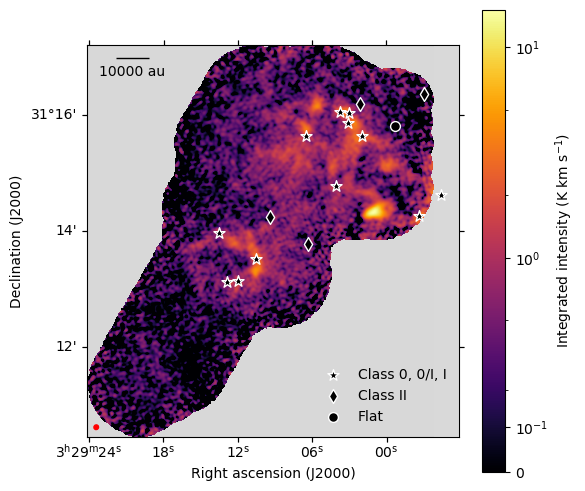

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), subplot_kw={'projection': wcs})
cmap = cm.get_cmap('inferno').copy()
cmap.set_bad('0.85')
norm = AsinhNorm(linear_width=0.2, vmin=0)

im = ax.imshow(hc3nmom0, cmap=cmap,norm=norm)
fig.colorbar(im, ax=ax, label=r'Integrated intensity (K km s$^{-1}$)')
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')

add_beam(ax, major=bmaj, minor=bmin, angle=bpa, color='r', pad=0.1)

for i in catalog_protostars.index.values:
    if catalog_protostars.loc[i, 'Class'] == 'I' or catalog_protostars.loc[i, 'Class'] == '0' or catalog_protostars.loc[i, 'Class'] == '0/I':
        class0dot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=70)
    elif catalog_protostars.loc[i, 'Class'] == 'II' or catalog_protostars.loc[i, 'Class'] == 'III':
        classIIdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='d', facecolor='k', edgecolor='w', s=50)
    elif catalog_protostars.loc[i, 'Class'] == 'Flat':
        classflatdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='o', facecolor='k', edgecolor='w', s=50)
    else: continue
ax.legend([class0dot, classIIdot, classflatdot], ['Class 0, 0/I, I', 'Class II', 'Flat'], frameon=False, loc=4)
ax.set_facecolor('0.85')
add_scalebar(ax, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))
# for i in catalog_xray.index.values:
#     ax.scatter(catalog_xray.loc[i, 'RAJ2000'], catalog_xray.loc[i, 'DEJ2000'], 
#                transform=ax.get_transform('world'), marker='x', facecolor='r', s=70)
fig.savefig('figures/HC3N_mom0_mylist.pdf', bbox_inches='tight', dpi=100)

/tmp/ipykernel_6193/235651610.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('inferno').copy()


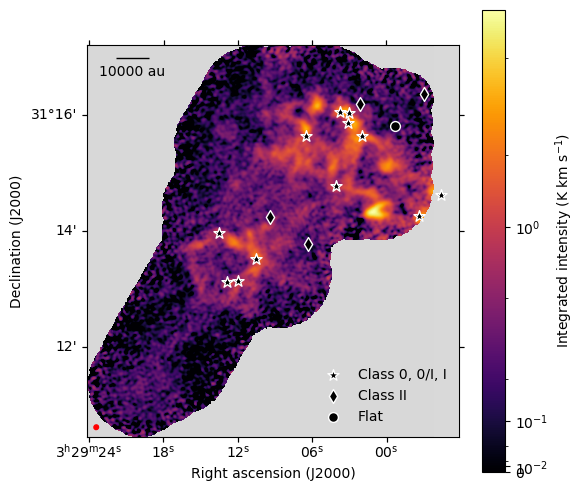

In [6]:
# this is the same moment but between 5 and 10, where the cloud emission is
fig, ax = plt.subplots(1, 1, figsize=(6,6), subplot_kw={'projection': wcs})
cmap = cm.get_cmap('inferno').copy()
cmap.set_bad('0.85')
norm = AsinhNorm(linear_width=0.2, vmin=0)

im = ax.imshow(mom0hc3n_cloud, cmap=cmap,norm=norm)
fig.colorbar(im, ax=ax, label=r'Integrated intensity (K km s$^{-1}$)')
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')

add_beam(ax, major=bmaj, minor=bmin, angle=bpa, color='r', pad=0.1)

for i in catalog_protostars.index.values:
    if catalog_protostars.loc[i, 'Class'] == 'I' or catalog_protostars.loc[i, 'Class'] == '0' or catalog_protostars.loc[i, 'Class'] == '0/I':
        class0dot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=70)
    elif catalog_protostars.loc[i, 'Class'] == 'II' or catalog_protostars.loc[i, 'Class'] == 'III':
        classIIdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='d', facecolor='k', edgecolor='w', s=50)
    elif catalog_protostars.loc[i, 'Class'] == 'Flat':
        classflatdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='o', facecolor='k', edgecolor='w', s=50)
    else: continue
ax.legend([class0dot, classIIdot, classflatdot], ['Class 0, 0/I, I', 'Class II', 'Flat'], frameon=False, loc=4)
ax.set_facecolor('0.85')
add_scalebar(ax, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))
# for i in catalog_xray.index.values:
#     ax.scatter(catalog_xray.loc[i, 'RAJ2000'], catalog_xray.loc[i, 'DEJ2000'], 
#                transform=ax.get_transform('world'), marker='x', facecolor='r', s=70)
fig.savefig('figures/HC3N_mom0_cloud_mylist.pdf', bbox_inches='tight', dpi=100)

In [7]:
outflowsources = ['Per12', 'Per13', 'Per15', 'Per27', 'Per36', 'Per44SVS13B', 'SVS13C']
outflowfolder = 'data/MASSES/'
outflowbluebase = '{0}.12CO21.robust1_blue'
outflowredbase = '{0}.12CO21.robust1_red'
# contourbluelist = np.array([[0.25, 0.2], [3, 12], [3, 6], [1.6, 1], [2.2, 4], [2.4, 2.4], [3.3, 10], [2, 4]]) # start, step
contourbluelist = np.array([[3, 24], [3, 18], [1.6, 3], [2.2, 12], [2.4, 4.8], [3.3, 20], [2, 12]]) # start, step
# contourredlist = np.array([[0.7,1.5], [3.5,10], [1.6, 5], [0.6,0.7], [1.5, 3], [5, 5], [6, 10], [3, 3]])
contourredlist = np.array([[3.5,30], [1.6, 15], [0.6,2.1], [1.5, 9], [5, 15], [6, 30], [3, 9]])

# extra sources
outflowIRAS4Cdata, outflowIRAS4Chead = fits.getdata('data/ALMA/IRAS4C_ALMA_CS_5_4_vel_6_9.5.fits', header=True)


/tmp/ipykernel_6193/653438971.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('gist_gray').copy()


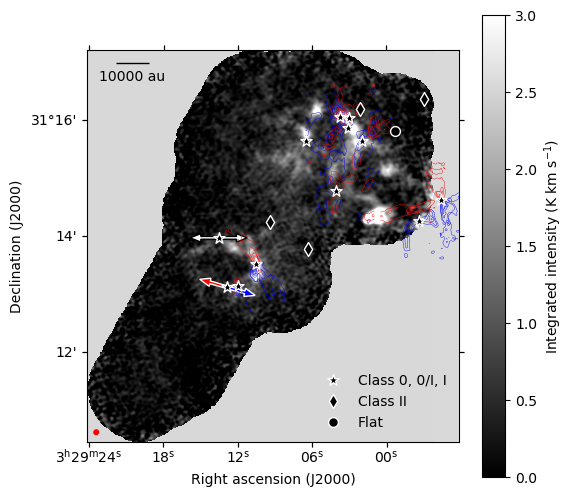

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), subplot_kw={'projection': wcs})
cmap = cm.get_cmap('gist_gray').copy()
cmap.set_bad('0.85')
# norm = AsinhNorm(linear_width=0.1, vmin=0)

im = ax.imshow(hc3nmom0, cmap=cmap, vmin=0, vmax=3) #,norm=norm)
fig.colorbar(im, ax=ax, label=r'Integrated intensity (K km s$^{-1}$)')
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')

add_beam(ax, major=bmaj, minor=bmin, angle=bpa, color='r', pad=0.1)

for i in range(len(outflowsources)):
    blueimage, bluehead = fits.getdata(outflowfolder+outflowbluebase.format(outflowsources[i])+'.fits', header=True)
    bluerange = np.arange(contourbluelist[i, 0], contourbluelist[i, 0]*100, contourbluelist[i, 1])
    ax.contour(blueimage, transform=ax.get_transform(WCS(bluehead)), levels=bluerange, colors='blue', linewidths=0.3)
    redimage, redhead = fits.getdata(outflowfolder+outflowredbase.format(outflowsources[i])+'.fits', header=True)
    redrange = np.arange(contourredlist[i, 0], contourredlist[i, 0]*100, contourredlist[i, 1])
    ax.contour(redimage, transform=ax.get_transform(WCS(redhead)), levels=redrange, colors='red', linewidths=0.3)


for i in catalog_protostars.index.values:
    if catalog_protostars.loc[i, 'Class'] == 'I' or catalog_protostars.loc[i, 'Class'] == '0' or catalog_protostars.loc[i, 'Class'] == '0/I':
        class0dot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=70, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'II' or catalog_protostars.loc[i, 'Class'] == 'III':
        classIIdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='d', facecolor='k', edgecolor='w', s=50, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'Flat':
        classflatdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='o', facecolor='k', edgecolor='w', s=50, zorder=100)
    else: continue
ax.legend([class0dot, classIIdot, classflatdot], ['Class 0, 0/I, I', 'Class II', 'Flat'], frameon=False, loc=4)
ax.set_facecolor('0.85')
add_scalebar(ax, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))

# ax.contour(outflowIRAS4Cdata, transform=ax.get_transform(WCS(outflowIRAS4Chead)), levels=0.0074*np.array([3, 6, 9]), colors='cyan', linewidths=0.3)
#IRAS 4C
ax.arrow(catalog_protostars.loc[2, 'RAJ2000'], catalog_protostars.loc[2, 'DEJ2000'],  0.006, 0, transform=ax.get_transform('world'), fc='w', width=0.0008)
ax.arrow(catalog_protostars.loc[2, 'RAJ2000'], catalog_protostars.loc[2, 'DEJ2000'],  -0.006, 0, transform=ax.get_transform('world'), fc='w', width=0.0008)
# IRAS 4B2
ax.arrow(catalog_protostars.loc[9, 'RAJ2000'], catalog_protostars.loc[9, 'DEJ2000'],  0.006*np.sin(1.32645), 0.006*np.cos(1.32645), transform=ax.get_transform('world'), fc='r', ec='w', width=0.0008)
ax.arrow(catalog_protostars.loc[9, 'RAJ2000'], catalog_protostars.loc[9, 'DEJ2000'],  -0.006*np.sin(1.32645), -0.006*np.cos(1.32645), transform=ax.get_transform('world'), fc='b', ec='w', width=0.0008)

#-1.5708
# for i in catalog_xray.index.values:
#     ax.scatter(catalog_xray.loc[i, 'RAJ2000'], catalog_xray.loc[i, 'DEJ2000'], 
#                transform=ax.get_transform('world'), marker='x', facecolor='r', s=70)
fig.savefig('figures/HC3N_mom0_woutflows_wsourcesextended_gray.pdf', bbox_inches='tight', dpi=100)

/tmp/ipykernel_6193/3932159998.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('gist_gray').copy()


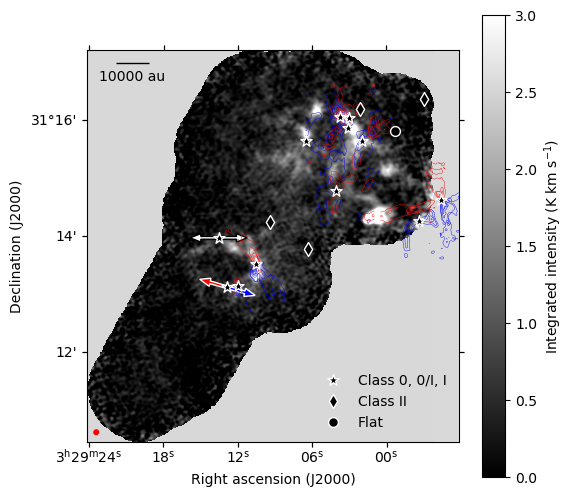

In [9]:
# this is the same plot but for the cloud range
fig, ax = plt.subplots(1, 1, figsize=(6,6), subplot_kw={'projection': wcs})
cmap = cm.get_cmap('gist_gray').copy()
cmap.set_bad('0.85')
# norm = AsinhNorm(linear_width=0.1, vmin=0)

im = ax.imshow(hc3nmom0, cmap=cmap, vmin=0, vmax=3) #,norm=norm)
fig.colorbar(im, ax=ax, label=r'Integrated intensity (K km s$^{-1}$)')
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')

add_beam(ax, major=bmaj, minor=bmin, angle=bpa, color='r', pad=0.1)

for i in range(len(outflowsources)):
    blueimage, bluehead = fits.getdata(outflowfolder+outflowbluebase.format(outflowsources[i])+'.fits', header=True)
    bluerange = np.arange(contourbluelist[i, 0], contourbluelist[i, 0]*100, contourbluelist[i, 1])
    ax.contour(blueimage, transform=ax.get_transform(WCS(bluehead)), levels=bluerange, colors='blue', linewidths=0.3)
    redimage, redhead = fits.getdata(outflowfolder+outflowredbase.format(outflowsources[i])+'.fits', header=True)
    redrange = np.arange(contourredlist[i, 0], contourredlist[i, 0]*100, contourredlist[i, 1])
    ax.contour(redimage, transform=ax.get_transform(WCS(redhead)), levels=redrange, colors='red', linewidths=0.3)


for i in catalog_protostars.index.values:
    if catalog_protostars.loc[i, 'Class'] == 'I' or catalog_protostars.loc[i, 'Class'] == '0' or catalog_protostars.loc[i, 'Class'] == '0/I':
        class0dot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=70, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'II' or catalog_protostars.loc[i, 'Class'] == 'III':
        classIIdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='d', facecolor='k', edgecolor='w', s=50, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'Flat':
        classflatdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='o', facecolor='k', edgecolor='w', s=50, zorder=100)
    else: continue
ax.legend([class0dot, classIIdot, classflatdot], ['Class 0, 0/I, I', 'Class II', 'Flat'], frameon=False, loc=4)
ax.set_facecolor('0.85')
add_scalebar(ax, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))

# ax.contour(outflowIRAS4Cdata, transform=ax.get_transform(WCS(outflowIRAS4Chead)), levels=0.0074*np.array([3, 6, 9]), colors='cyan', linewidths=0.3)
#IRAS 4C
ax.arrow(catalog_protostars.loc[2, 'RAJ2000'], catalog_protostars.loc[2, 'DEJ2000'],  0.006, 0, transform=ax.get_transform('world'), fc='w', width=0.0008)
ax.arrow(catalog_protostars.loc[2, 'RAJ2000'], catalog_protostars.loc[2, 'DEJ2000'],  -0.006, 0, transform=ax.get_transform('world'), fc='w', width=0.0008)
# IRAS 4B2
ax.arrow(catalog_protostars.loc[9, 'RAJ2000'], catalog_protostars.loc[9, 'DEJ2000'],  0.006*np.sin(1.32645), 0.006*np.cos(1.32645), transform=ax.get_transform('world'), fc='r', ec='w', width=0.0008)
ax.arrow(catalog_protostars.loc[9, 'RAJ2000'], catalog_protostars.loc[9, 'DEJ2000'],  -0.006*np.sin(1.32645), -0.006*np.cos(1.32645), transform=ax.get_transform('world'), fc='b', ec='w', width=0.0008)

#-1.5708
# for i in catalog_xray.index.values:
#     ax.scatter(catalog_xray.loc[i, 'RAJ2000'], catalog_xray.loc[i, 'DEJ2000'], 
#                transform=ax.get_transform('world'), marker='x', facecolor='r', s=70)
fig.savefig('figures/HC3N_mom0_cloud_woutflows_wsourcesextended_gray.pdf', bbox_inches='tight', dpi=100)

/tmp/ipykernel_6193/1710478076.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('inferno').copy()


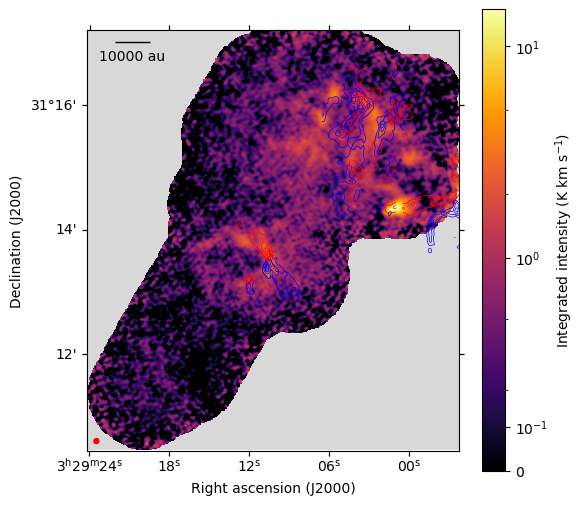

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), subplot_kw={'projection': wcs})
cmap = cm.get_cmap('inferno').copy()
cmap.set_bad('0.85')
norm = AsinhNorm(linear_width=0.2, vmin=0)

im = ax.imshow(hc3nmom0, cmap=cmap,norm=norm)
fig.colorbar(im, ax=ax, label=r'Integrated intensity (K km s$^{-1}$)')
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')

add_beam(ax, major=bmaj, minor=bmin, angle=bpa, color='r', pad=0.1)

for i in range(len(outflowsources)):
    blueimage, bluehead = fits.getdata(outflowfolder+outflowbluebase.format(outflowsources[i])+'.fits', header=True)
    bluerange = np.arange(contourbluelist[i, 0], contourbluelist[i, 0]*100, contourbluelist[i, 1])
    ax.contour(blueimage, transform=ax.get_transform(WCS(bluehead)), levels=bluerange, colors='blue', linewidths=0.5)
    redimage, redhead = fits.getdata(outflowfolder+outflowredbase.format(outflowsources[i])+'.fits', header=True)
    redrange = np.arange(contourredlist[i, 0], contourredlist[i, 0]*100, contourredlist[i, 1])
    ax.contour(redimage, transform=ax.get_transform(WCS(redhead)), levels=redrange, colors='red', linewidths=0.5)

add_scalebar(ax, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))

# for i in catalog_xray.index.values:
#     ax.scatter(catalog_xray.loc[i, 'RAJ2000'], catalog_xray.loc[i, 'DEJ2000'], 
#                transform=ax.get_transform('world'), marker='x', facecolor='r', s=70)
fig.savefig('figures/HC3N_mom0_woutflows.pdf', bbox_inches='tight', dpi=100)

/tmp/ipykernel_6193/2535873985.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('inferno').copy()


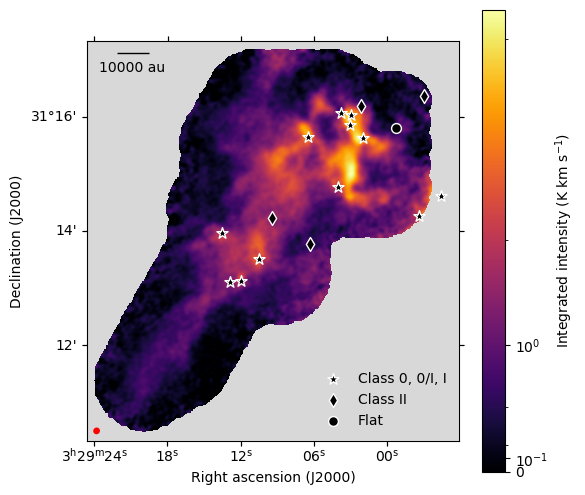

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), subplot_kw={'projection': wcsn2hp})
cmap = cm.get_cmap('inferno').copy()
cmap.set_bad('0.85')
norm = AsinhNorm(linear_width=2, vmin=0)

im = ax.imshow(mom0n2hp, cmap=cmap, norm=norm)
fig.colorbar(im, ax=ax, label=r'Integrated intensity (K km s$^{-1}$)')
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')

add_beam(ax, major=bmajn2hp, minor=bminn2hp, angle=bpan2hp, color='r', pad=0.1)

for i in catalog_protostars.index.values:
    if catalog_protostars.loc[i, 'Class'] == 'I' or catalog_protostars.loc[i, 'Class'] == '0' or catalog_protostars.loc[i, 'Class'] == '0/I':
        class0dot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=70, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'II' or catalog_protostars.loc[i, 'Class'] == 'III':
        classIIdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='d', facecolor='k', edgecolor='w', s=50, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'Flat':
        classflatdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='o', facecolor='k', edgecolor='w', s=50, zorder=100)
    else: continue
ax.legend([class0dot, classIIdot, classflatdot], ['Class 0, 0/I, I', 'Class II', 'Flat'], frameon=False, loc=4)
ax.set_facecolor('0.85')
add_scalebar(ax, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))

fig.savefig('figures/N2Hp_mom0.pdf', bbox_inches='tight', dpi=100)

## Channel maps of the molecules

In [6]:
cubehc3n = SpectralCube.read(hc3nfile).with_spectral_unit(u.km/u.s)
wcsskyhc3n = WCS(cubehc3n.header).celestial
cuben2hp = SpectralCube.read(n2hpfile).with_spectral_unit(u.km/u.s)
wcsskyn2hp = WCS(cuben2hp.header).celestial

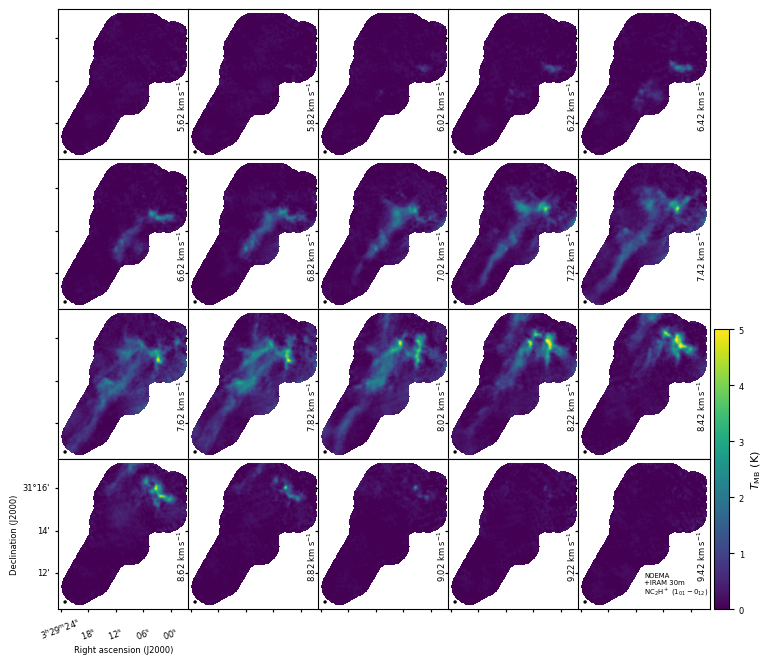

In [13]:

velinit = 5.61753 *u.km/u.s
deltav = 0.20 *u.km/u.s
figname = 'figures/N2Hp_channel_map_{0}_{1}.pdf'.format(velinit.value, deltav.value)
nrows = 4
ncols = 5
vmin = 0
vmax = 5
velarray = cuben2hp.spectral_axis.value
velsample = np.arange(velinit.value, (velinit+deltav*nrows*ncols).value, deltav.value)
scalebarsize = 10000
scalebardeg = (scalebarsize / distance) / 3600 * u.deg

fontprops = fm.FontProperties(size=7)
norm = AsinhNorm(linear_width=2, vmin=vmin, vmax=vmax)
fig, axlist = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(10,8), subplot_kw={'projection': wcsskyn2hp})
axlist = axlist.flatten()

for i, ax in enumerate(axlist):
    indexvel = np.argmin(np.abs(velarray-velsample[i]))
    planevel = cuben2hp.unmasked_data[indexvel, :, :].value
    im = ax.imshow(planevel, vmin=vmin, vmax=vmax) #, norm=norm)
    ax.annotate(str(np.round(velsample[i], 2))+r' km s$^{-1}$', (0.89, 0.2), xycoords='axes fraction', color='k', size=6, rotation=90)
    
    # ax.scatter(ra_yso_pix, dec_yso_pix, marker='*', facecolor=None, edgecolor='w', s=8, linewidth=0.5)
    # ax.set_xlim([xmin, xmax])
    # ax.set_ylim([ymin, ymax])
    # ax.contour(contourdata, levels=nh3mom0levels, colors='w', linewidths=0.5, linestyles='dashed')
    if i == ncols*nrows-1: 
        ax.annotate('NOEMA\n+IRAM 30m\nNC$_2$H$^+$ ($1_{01}-0_{12}$)', (0.5, 0.1), xycoords='axes fraction', color='k', size=5)

    # ax.scatter(ra_yso_pix, dec_yso_pix, marker='*', facecolor='None', edgecolor='w', s=20, linewidth=0.2) 
    add_beam(ax, major=bmajn2hp, minor=bminn2hp, angle=bpan2hp, frame=False, pad=0.05, ec = 'k', fc='k')
    if not i == ncols*nrows - ncols:
        ax.tick_params(axis='x', which='both', bottom=True, labelbottom=False, length=2, direction='out')
        ax.tick_params(axis='y', which='both', left=True, labelleft=False, length=2, direction='out')
    if not i:
        add_scalebar(ax, scalebardeg, label=str(scalebarsize)+' au', color='w', pad=0.1, fontproperties=fontprops)

    else:
        ax.tick_params(axis='x', which='both', length=2, top=False, bottom=True,direction='out')
        ax.tick_params(axis='y', which='both', length=2, direction='out')
        lon = ax.coords[0]
        lat = ax.coords[1]
        lon.set_axislabel('Right ascension (J2000)', size=6)
        lat.set_axislabel('Declination (J2000)', size=6)
        lat.set_ticklabel(size=6)
        lon.set_ticklabel(rotation=20,pad=15,ha='right', size=6)

fig.tight_layout(pad=0)
fig.subplots_adjust(left=0.2, right=0.98, bottom=0.15, top=0.9, hspace = 0, wspace=-0.4)
cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.35])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(label=r'$T_{\mathrm{MB}}$ (K)', size=8)
cbar_ax.tick_params(labelsize=6)
fig.subplots_adjust(hspace = 0, wspace=-0.5) 

fig.savefig(figname, bbox_inches='tight', dpi=100)

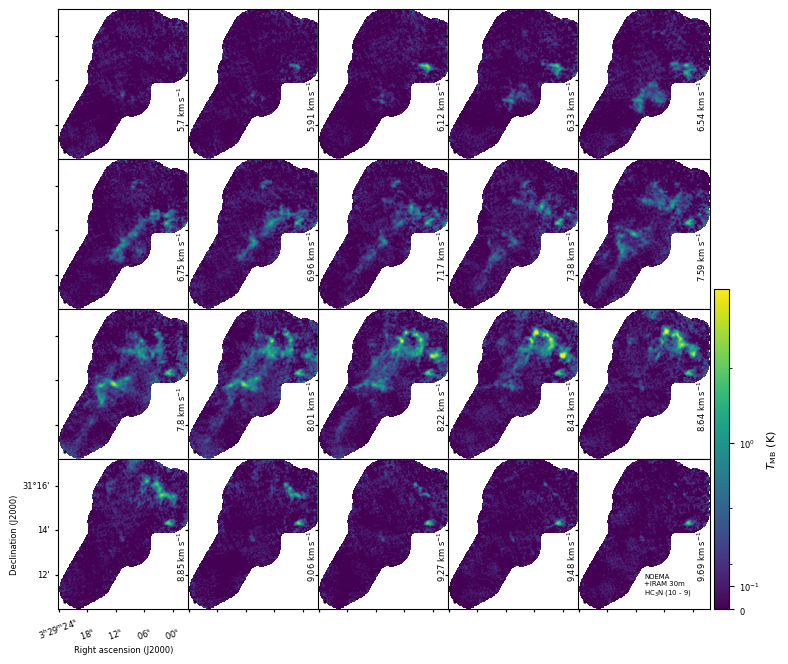

In [14]:
# we do the channel map for the main filament body, the spectra should show the outflow emission
velinit = 5.69638 *u.km/u.s
deltav = 0.21 *u.km/u.s
figname = 'figures/HC3N_channel_map_{0}_{1}.pdf'.format(velinit.value, deltav.value)
nrows = 4
ncols = 5
vmin = 0
vmax = 4
velarray = cubehc3n.spectral_axis.value
velsample = np.arange(velinit.value, (velinit+deltav*nrows*ncols).value, deltav.value)
scalebarsize = 10000
scalebardeg = (scalebarsize / distance) / 3600 * u.deg

fontprops = fm.FontProperties(size=7)
norm = AsinhNorm(linear_width=0.5, vmin=vmin, vmax=vmax)
fig, axlist = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(10,8), subplot_kw={'projection': wcsskyhc3n})
axlist = axlist.flatten()

for i, ax in enumerate(axlist):
    indexvel = np.argmin(np.abs(velarray-velsample[i]))
    planevel = cubehc3n.unmasked_data[indexvel, :, :].value
    im = ax.imshow(planevel, norm=norm)
    ax.annotate(str(np.round(velsample[i], 2))+r' km s$^{-1}$', (0.89, 0.2), xycoords='axes fraction', color='k', size=6, rotation=90)
    
    # ax.scatter(ra_yso_pix, dec_yso_pix, marker='*', facecolor=None, edgecolor='w', s=8, linewidth=0.5)
    # ax.set_xlim([xmin, xmax])
    # ax.set_ylim([ymin, ymax])
    # ax.contour(contourdata, levels=nh3mom0levels, colors='w', linewidths=0.5, linestyles='dashed')
    if i == ncols*nrows-1: 
        ax.annotate('NOEMA\n+IRAM 30m\nHC$_3$N (10 - 9)', (0.5, 0.1), xycoords='axes fraction', color='k', size=5)

    # ax.scatter(ra_yso_pix, dec_yso_pix, marker='*', facecolor='None', edgecolor='w', s=20, linewidth=0.2) 
    add_beam(ax, major=bmaj, minor=bmin, angle=bpa, frame=False, pad=0.05, ec = 'k', fc='k')
    if not i == ncols*nrows - ncols:
        ax.tick_params(axis='x', which='both', bottom=True, labelbottom=False, length=2, direction='out')
        ax.tick_params(axis='y', which='both', left=True, labelleft=False, length=2, direction='out')
    if not i:
        add_scalebar(ax, scalebardeg, label=str(scalebarsize)+' au', color='w', pad=0.1, fontproperties=fontprops)

    else:
        ax.tick_params(axis='x', which='both', length=2, top=False, bottom=True,direction='out')
        ax.tick_params(axis='y', which='both', length=2, direction='out')
        lon = ax.coords[0]
        lat = ax.coords[1]
        lon.set_axislabel('Right ascension (J2000)', size=6)
        lat.set_axislabel('Declination (J2000)', size=6)
        lat.set_ticklabel(size=6)
        lon.set_ticklabel(rotation=20,pad=15,ha='right', size=6)

fig.tight_layout(pad=0)
fig.subplots_adjust(left=0.2, right=0.98, bottom=0.15, top=0.9, hspace = 0, wspace=-0.4)
cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.4])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(label=r'$T_{\mathrm{MB}}$ (K)', size=8)
cbar_ax.tick_params(labelsize=6)
fig.subplots_adjust(hspace = 0, wspace=-0.5) 

fig.savefig(figname, bbox_inches='tight', dpi=100)

/tmp/ipykernel_6193/3717895863.py:54: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout(pad=0)


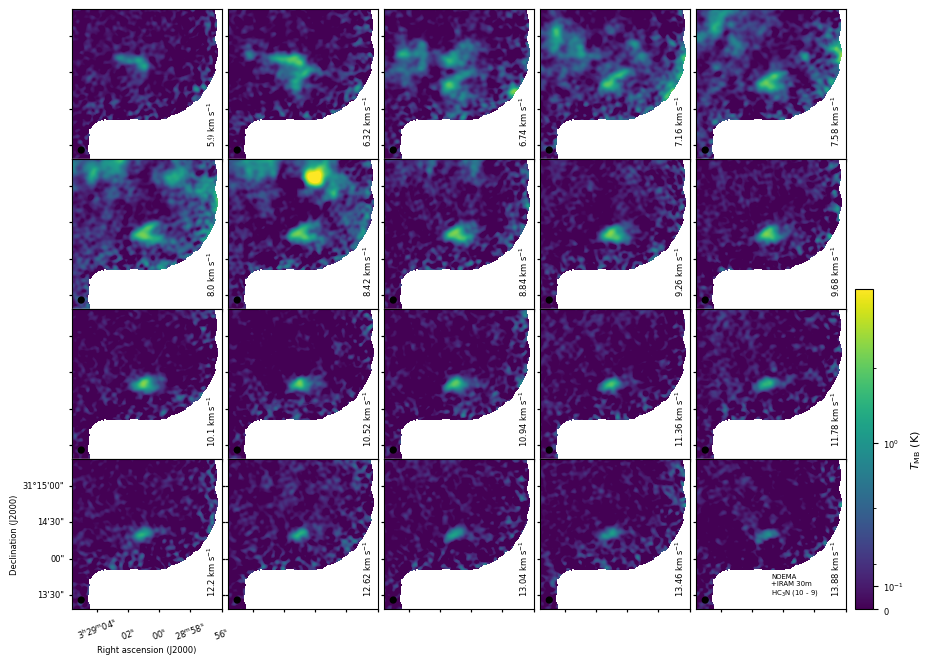

In [15]:
# we do also channel maps zooming into the shape of the monster outflow

# we do the channel map for the main filament body, the spectra should show the outflow emission
velinit = 5.90232 *u.km/u.s
deltav = 0.42 *u.km/u.s
figname = 'figures/HC3N_channel_map_zoom_outflow_{0}_{1}.pdf'.format(velinit.value, deltav.value)
nrows = 4
ncols = 5
vmin = 0
vmax = 4
xmin, xmax = 388-80, 388+80
ymin, ymax = 301-80, 301+80
velarray = cubehc3n.spectral_axis.value
velsample = np.arange(velinit.value, (velinit+deltav*nrows*ncols).value, deltav.value)
scalebarsize = 10000
scalebardeg = (scalebarsize / distance) / 3600 * u.deg

fontprops = fm.FontProperties(size=7)
norm = AsinhNorm(linear_width=0.5, vmin=vmin, vmax=vmax)
fig, axlist = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(12,8), subplot_kw={'projection': wcsskyhc3n})
axlist = axlist.flatten()

for i, ax in enumerate(axlist):
    indexvel = np.argmin(np.abs(velarray-velsample[i]))
    planevel = cubehc3n.unmasked_data[indexvel, :, :].value
    im = ax.imshow(planevel, norm=norm)
    ax.annotate(str(np.round(velsample[i], 2))+r' km s$^{-1}$', (0.89, 0.1), xycoords='axes fraction', color='k', size=6, rotation=90)
    
    # ax.scatter(ra_yso_pix, dec_yso_pix, marker='*', facecolor=None, edgecolor='w', s=8, linewidth=0.5)
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    # ax.contour(contourdata, levels=nh3mom0levels, colors='w', linewidths=0.5, linestyles='dashed')
    if i == ncols*nrows-1: 
        ax.annotate('NOEMA\n+IRAM 30m\nHC$_3$N (10 - 9)', (0.5, 0.1), xycoords='axes fraction', color='k', size=5)

    # ax.scatter(ra_yso_pix, dec_yso_pix, marker='*', facecolor='None', edgecolor='w', s=20, linewidth=0.2) 
    add_beam(ax, major=bmaj, minor=bmin, angle=bpa, frame=False, pad=0.05, ec = 'k', fc='k')
    if not i == ncols*nrows - ncols:
        ax.tick_params(axis='x', which='both', bottom=True, labelbottom=False, length=2, direction='out')
        ax.tick_params(axis='y', which='both', left=True, labelleft=False, length=2, direction='out')
    if not i:
        add_scalebar(ax, scalebardeg, label=str(scalebarsize)+' au', color='w', pad=0.1, fontproperties=fontprops)

    else:
        ax.tick_params(axis='x', which='both', length=2, top=False, bottom=True,direction='out')
        ax.tick_params(axis='y', which='both', length=2, direction='out')
        lon = ax.coords[0]
        lat = ax.coords[1]
        lon.set_axislabel('Right ascension (J2000)', size=6)
        lat.set_axislabel('Declination (J2000)', size=6)
        lat.set_ticklabel(size=6)
        lon.set_ticklabel(rotation=20,pad=15,ha='right', size=6)

fig.tight_layout(pad=0)
fig.subplots_adjust(left=0.2, right=0.98, bottom=0.15, top=0.9, hspace = 0, wspace=-0.4)
cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.4])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(label=r'$T_{\mathrm{MB}}$ (K)', size=8)
cbar_ax.tick_params(labelsize=6)
fig.subplots_adjust(hspace = 0, wspace=-0.5) 

fig.savefig(figname, bbox_inches='tight', dpi=100)

## Fit results

/tmp/ipykernel_6193/4247849410.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('YlGnBu', 3).copy()


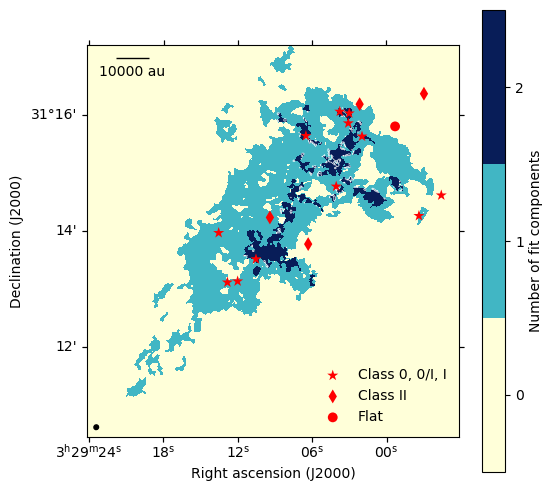

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), subplot_kw={'projection': wcs})
cmap = cm.get_cmap('YlGnBu', 3).copy()
cmap.set_bad('0.85')
ncomp[np.where(np.isnan(ncomp))] = 0
ncompflag[np.where(np.isnan(ncompflag))] = 0.

sc1 = ax.imshow(ncomp,  cmap=cmap, vmin=-0.5, vmax=2.5)
cax = plt.colorbar(sc1, ax=ax, label='Number of fit components', ticks=np.arange(4))
ax.contour(ncompflag, levels=[0.5], colors='w', linewidths=0.5)

lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')

add_beam(ax, major=bmaj, minor=bmin, angle=bpa, color='k', pad=0.1)
add_scalebar(ax, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))

for i in catalog_protostars.index.values:
    if catalog_protostars.loc[i, 'Class'] == 'I' or catalog_protostars.loc[i, 'Class'] == '0' or catalog_protostars.loc[i, 'Class'] == '0/I':
        class0dot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='*', facecolor='r', edgecolor='None', s=70, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'II' or catalog_protostars.loc[i, 'Class'] == 'III':
        classIIdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='d', facecolor='r', edgecolor='None', s=50, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'Flat':
        classflatdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='o', facecolor='r', edgecolor='None', s=50, zorder=100)
    else: continue
ax.legend([class0dot, classIIdot, classflatdot], ['Class 0, 0/I, I', 'Class II', 'Flat'], frameon=False, loc=4)
ax.set_facecolor(cmap(0))
fig.savefig('figures/HC3N_ncompAIC_wflag.pdf', bbox_inches='tight', dpi=100)

/tmp/ipykernel_6193/3497625436.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdYlBu_r').copy()


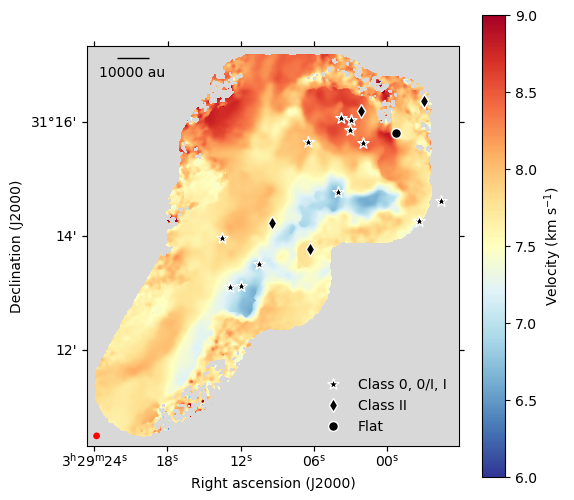

In [17]:
# 1 component fit using the N2Hp hyperfine component fitting
paramscuben2hp = fits.getdata(n2hpparamsfile)

fig, ax = plt.subplots(1, 1, figsize=(6,6), subplot_kw={'projection': wcsn2hp})
cmap = cm.get_cmap('RdYlBu_r').copy()
cmap.set_bad('0.85')
vmin = 6
vmax= 9

im = ax.imshow(paramscuben2hp[2], cmap=cmap, vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=ax, label=r'Velocity (km s$^{-1}$)')
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')

add_beam(ax, major=bmajn2hp, minor=bminn2hp, angle=bpan2hp, color='r', pad=0.1)
add_scalebar(ax, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))


for i in catalog_protostars.index.values:
    if catalog_protostars.loc[i, 'Class'] == 'I' or catalog_protostars.loc[i, 'Class'] == '0' or catalog_protostars.loc[i, 'Class'] == '0/I':
        class0dot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=70, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'II' or catalog_protostars.loc[i, 'Class'] == 'III':
        classIIdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='d', facecolor='k', edgecolor='w', s=50, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'Flat':
        classflatdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='o', facecolor='k', edgecolor='w', s=50, zorder=100)
    else: continue
ax.legend([class0dot, classIIdot, classflatdot], ['Class 0, 0/I, I', 'Class II', 'Flat'], frameon=False, loc=4)
ax.set_facecolor('0.85')
fig.savefig('figures/N2Hp_vlsr_thick.pdf', bbox_inches='tight', dpi=100)

## Nested sampling fit results

/tmp/ipykernel_356/2872725315.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('YlGnBu', 4).copy()


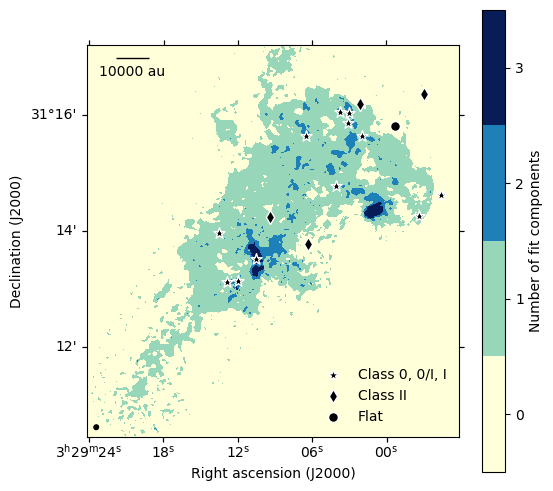

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), subplot_kw={'projection': wcs})
cmap = cm.get_cmap('YlGnBu', 4).copy()
ncompbayes[np.where(np.isnan(ncompbayes))] = 0
# ncompflag[np.where(np.isnan(ncompflag))] = 0.

sc1 = ax.imshow(ncompbayes,  cmap=cmap, vmin=-0.5, vmax=3.5)
cax = plt.colorbar(sc1, ax=ax, label='Number of fit components', ticks=np.arange(4))
# ax.contour(ncompflag, levels=[0.5], colors='w', linewidths=0.5)

lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')

add_beam(ax, major=bmaj, minor=bmin, angle=bpa, color='k', pad=0.1)
add_scalebar(ax, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))

for i in catalog_protostars.index.values:
    if catalog_protostars.loc[i, 'Class'] == 'I' or catalog_protostars.loc[i, 'Class'] == '0' or catalog_protostars.loc[i, 'Class'] == '0/I':
        class0dot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=70, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'II' or catalog_protostars.loc[i, 'Class'] == 'III':
        classIIdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='d', facecolor='k', edgecolor='w', s=50, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'Flat':
        classflatdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='o', facecolor='k', edgecolor='w', s=50, zorder=100)
    else: continue
ax.legend([class0dot, classIIdot, classflatdot], ['Class 0, 0/I, I', 'Class II', 'Flat'], frameon=False, loc=4)
ax.set_facecolor(cmap(0))
fig.savefig('figures/HC3N_ncompbayes.pdf', bbox_inches='tight', dpi=100)

/tmp/ipykernel_6193/1352439548.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('YlGnBu', 4).copy()


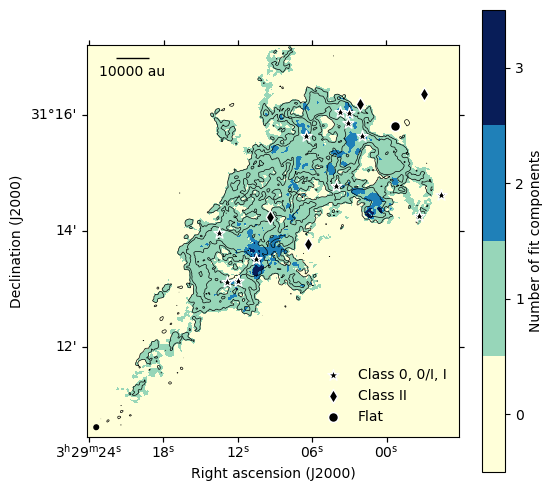

In [18]:
# Like the previous oe but with SNR levels
fig, ax = plt.subplots(1, 1, figsize=(6,6), subplot_kw={'projection': wcs})
cmap = cm.get_cmap('YlGnBu', 4).copy()
ncompbayes[np.where(np.isnan(ncompbayes))] = 0
# ncompflag[np.where(np.isnan(ncompflag))] = 0.

sc1 = ax.imshow(ncompbayes,  cmap=cmap, vmin=-0.5, vmax=3.5)
cax = plt.colorbar(sc1, ax=ax, label='Number of fit components', ticks=np.arange(4))
# ax.contour(ncompflag, levels=[0.5], colors='w', linewidths=0.5)
CS = ax.contour(hc3nsnr, colors='k', levels=[5, 10], linewidths=0.5)

lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')

add_beam(ax, major=bmaj, minor=bmin, angle=bpa, color='k', pad=0.1)
add_scalebar(ax, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))
for i in catalog_protostars.index.values:
    if catalog_protostars.loc[i, 'Class'] == 'I' or catalog_protostars.loc[i, 'Class'] == '0' or catalog_protostars.loc[i, 'Class'] == '0/I':
        class0dot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=70, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'II' or catalog_protostars.loc[i, 'Class'] == 'III':
        classIIdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='d', facecolor='k', edgecolor='w', s=50, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'Flat':
        classflatdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='o', facecolor='k', edgecolor='w', s=50, zorder=100)
    else: continue
ax.legend([class0dot, classIIdot, classflatdot], ['Class 0, 0/I, I', 'Class II', 'Flat'], frameon=False, loc=4)
ax.set_facecolor(cmap(0))
fig.savefig('figures/HC3N_ncompbayes_wsnr.pdf', bbox_inches='tight', dpi=100)

/tmp/ipykernel_6193/3155708375.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('YlGnBu', 4).copy()


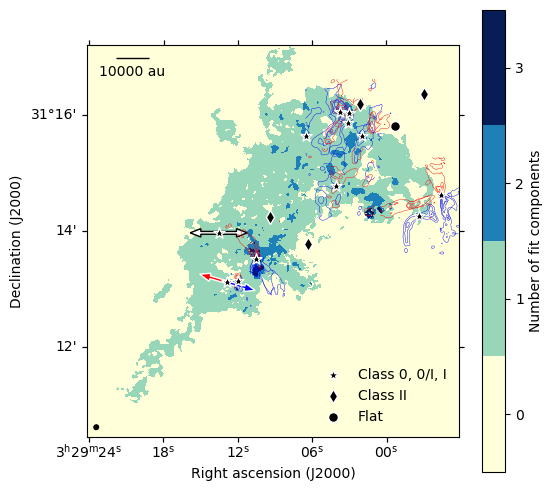

In [19]:
# like the previous but with outflows
fig, ax = plt.subplots(1, 1, figsize=(6,6), subplot_kw={'projection': wcs})
cmap = cm.get_cmap('YlGnBu', 4).copy()
ncompbayes[np.where(np.isnan(ncompbayes))] = 0
# ncompflag[np.where(np.isnan(ncompflag))] = 0.

sc1 = ax.imshow(ncompbayes,  cmap=cmap, vmin=-0.5, vmax=3.5)
cax = plt.colorbar(sc1, ax=ax, label='Number of fit components', ticks=np.arange(4))
# ax.contour(ncompflag, levels=[0.5], colors='w', linewidths=0.5)

lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')

add_beam(ax, major=bmaj, minor=bmin, angle=bpa, color='k', pad=0.1)
add_scalebar(ax, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))

for i in range(len(outflowsources)):
    blueimage, bluehead = fits.getdata(outflowfolder+outflowbluebase.format(outflowsources[i])+'.fits', header=True)
    bluerange = np.arange(contourbluelist[i, 0], contourbluelist[i, 0]*100, contourbluelist[i, 1])
    ax.contour(blueimage, transform=ax.get_transform(WCS(bluehead)), levels=bluerange, colors='blue', linewidths=0.3)
    redimage, redhead = fits.getdata(outflowfolder+outflowredbase.format(outflowsources[i])+'.fits', header=True)
    redrange = np.arange(contourredlist[i, 0], contourredlist[i, 0]*100, contourredlist[i, 1])
    ax.contour(redimage, transform=ax.get_transform(WCS(redhead)), levels=redrange, colors='red', linewidths=0.3)


for i in catalog_protostars.index.values:
    if catalog_protostars.loc[i, 'Class'] == 'I' or catalog_protostars.loc[i, 'Class'] == '0' or catalog_protostars.loc[i, 'Class'] == '0/I':
        class0dot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=70, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'II' or catalog_protostars.loc[i, 'Class'] == 'III':
        classIIdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='d', facecolor='k', edgecolor='w', s=50, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'Flat':
        classflatdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='o', facecolor='k', edgecolor='w', s=50, zorder=100)
    else: continue
ax.legend([class0dot, classIIdot, classflatdot], ['Class 0, 0/I, I', 'Class II', 'Flat'], frameon=False, loc=4)
ax.set_facecolor(cmap(0))

#IRAS 4C
ax.arrow(catalog_protostars.loc[2, 'RAJ2000'], catalog_protostars.loc[2, 'DEJ2000'],  0.006, 0, transform=ax.get_transform('world'), fc='w', width=0.0008)
ax.arrow(catalog_protostars.loc[2, 'RAJ2000'], catalog_protostars.loc[2, 'DEJ2000'],  -0.006, 0, transform=ax.get_transform('world'), fc='w', width=0.0008)
# IRAS 4B2
ax.arrow(catalog_protostars.loc[9, 'RAJ2000'], catalog_protostars.loc[9, 'DEJ2000'],  0.006*np.sin(1.32645), 0.006*np.cos(1.32645), transform=ax.get_transform('world'), fc='r', ec='w', width=0.0008)
ax.arrow(catalog_protostars.loc[9, 'RAJ2000'], catalog_protostars.loc[9, 'DEJ2000'],  -0.006*np.sin(1.32645), -0.006*np.cos(1.32645), transform=ax.get_transform('world'), fc='b', ec='w', width=0.0008)


fig.savefig('figures/HC3N_ncompbayes_woutfows.pdf', bbox_inches='tight', dpi=100)

/tmp/ipykernel_6193/1673166642.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('inferno').copy()


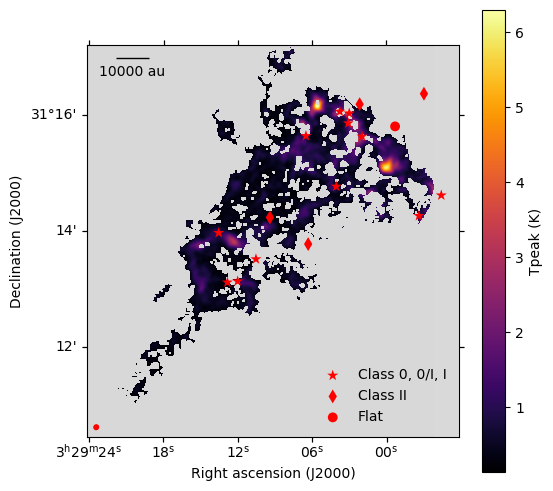

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), subplot_kw={'projection': wcs})
cmap = cm.get_cmap('inferno').copy()
cmap.set_bad('0.85')

im = ax.imshow(hc3nmlex1[0], cmap=cmap)
fig.colorbar(im, ax=ax, label=r'Tpeak (K)')
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')

add_beam(ax, major=bmaj, minor=bmin, angle=bpa, color='r', pad=0.1)
add_scalebar(ax, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))

for i in catalog_protostars.index.values:
    if catalog_protostars.loc[i, 'Class'] == 'I' or catalog_protostars.loc[i, 'Class'] == '0' or catalog_protostars.loc[i, 'Class'] == '0/I':
        class0dot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='*', facecolor='r', edgecolor='None', s=70, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'II' or catalog_protostars.loc[i, 'Class'] == 'III':
        classIIdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='d', facecolor='r', edgecolor='None', s=50, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'Flat':
        classflatdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='o', facecolor='r', edgecolor='None', s=50, zorder=100)
    else: continue
ax.legend([class0dot, classIIdot, classflatdot], ['Class 0, 0/I, I', 'Class II', 'Flat'], frameon=False, loc=4)
ax.set_facecolor('0.85')
# for i in catalog_xray.index.values:
#     ax.scatter(catalog_xray.loc[i, 'RAJ2000'], catalog_xray.loc[i, 'DEJ2000'], 
#                transform=ax.get_transform('world'), marker='x', facecolor='r', s=70)
fig.savefig('figures/HC3N_amplitude_mlex1_extendedlist.pdf', bbox_inches='tight', dpi=100)

/tmp/ipykernel_6193/3185355525.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdYlBu_r').copy()


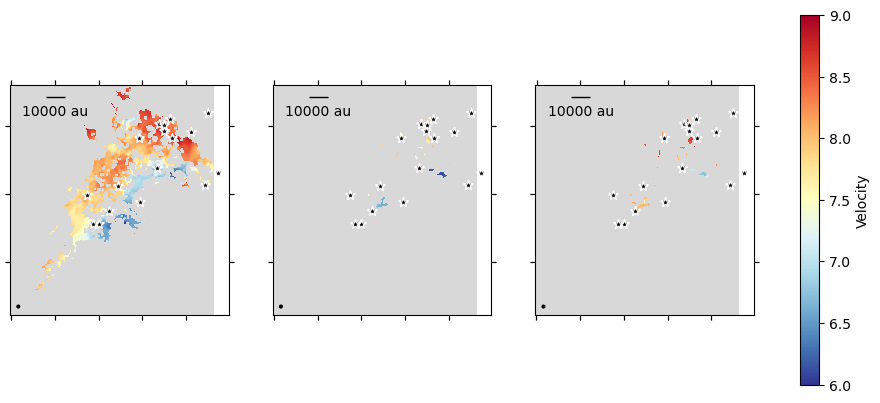

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(12,6), subplot_kw={'projection': wcs})
cmap = cm.get_cmap('RdYlBu_r').copy()
cmap.set_bad('0.85')
vmin = 6
vmax= 9

hc3nmlexlist = [hc3nmlex1[1], hc3nmlex2[1], hc3nmlex2[4]]

for i, ax in enumerate(axes):
    
    sc1 = ax.imshow(hc3nmlexlist[i], cmap=cmap, vmin=vmin, vmax=vmax)
    lon = ax.coords[0]
    lat = ax.coords[1]
    # ax.contour(ncompflag, levels=[0.5], colors='w', linewidths=0.5)
    if i==3:
        lon.set_axislabel('Right ascension (J2000)')
        lat.set_axislabel('Declination (J2000)')
        
    else:
        lon.set_ticklabel_visible(False)
        lat.set_ticklabel_visible(False)
        lon.set_axislabel('')
        lat.set_axislabel('')
        
    if i==2:
        fig.colorbar(sc1, ax=axes, label='Velocity',  shrink=0.8)

    add_beam(ax, major=bmaj, minor=bmin, angle=bpa, color='k', pad=0.1)
    add_scalebar(ax, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))

    for i in catalog_protostars.index.values:
        ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=50)

fig.savefig('figures/HC3N_ncompbayes_vel.pdf', bbox_inches='tight', dpi=100)

/tmp/ipykernel_356/2973575712.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('YlGnBu', 3).copy()


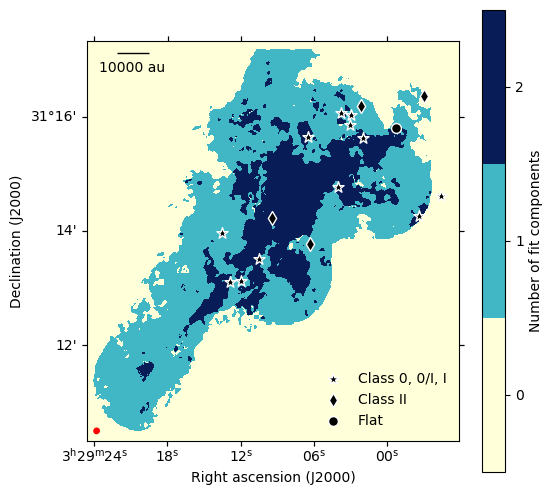

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), subplot_kw={'projection': wcsn2hp})
cmap = cm.get_cmap('YlGnBu', 3).copy()
cmap.set_bad('0.85')
n2hpncompbayes[np.where(np.isnan(n2hpncompbayes))] = 0
# ncompflag[np.where(np.isnan(ncompflag))] = 0.

sc1 = ax.imshow(n2hpncompbayes,  cmap=cmap, vmin=-0.5, vmax=2.5)
cax = plt.colorbar(sc1, ax=ax, label='Number of fit components', ticks=np.arange(4))
# ax.contour(ncompflag, levels=[0.5], colors='w', linewidths=0.5)

lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')

add_beam(ax, major=bmajn2hp, minor=bminn2hp, angle=bpan2hp, color='r', pad=0.1)


for i in catalog_protostars.index.values:
    if catalog_protostars.loc[i, 'Class'] == 'I' or catalog_protostars.loc[i, 'Class'] == '0' or catalog_protostars.loc[i, 'Class'] == '0/I':
        class0dot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=70, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'II' or catalog_protostars.loc[i, 'Class'] == 'III':
        classIIdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='d', facecolor='k', edgecolor='w', s=50, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'Flat':
        classflatdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='o', facecolor='k', edgecolor='w', s=50, zorder=100)
    else: continue
ax.legend([class0dot, classIIdot, classflatdot], ['Class 0, 0/I, I', 'Class II', 'Flat'], frameon=False, loc=4)
ax.set_facecolor(cmap(0))
add_scalebar(ax, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))

fig.savefig('figures/N2Hp_ncompbayes.pdf', bbox_inches='tight', dpi=100)

/tmp/ipykernel_356/2717919162.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdYlBu_r').copy()


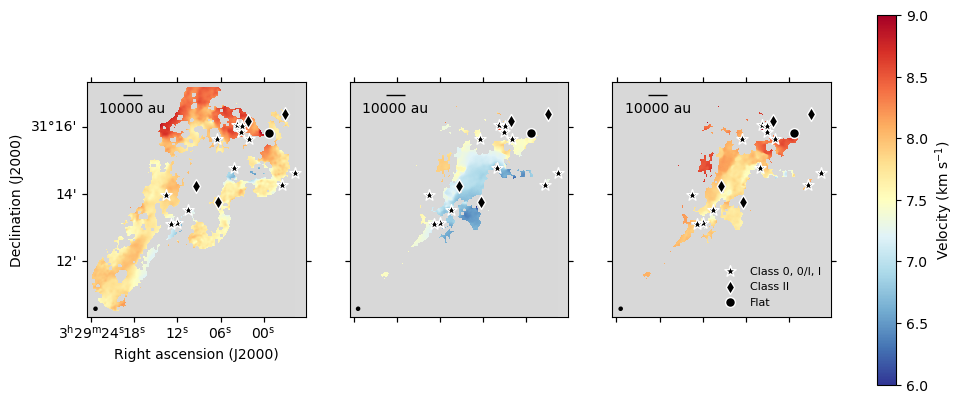

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(12,6), subplot_kw={'projection': wcsn2hp})
cmap = cm.get_cmap('RdYlBu_r').copy()
cmap.set_bad('0.85')
vmin = 6
vmax= 9

n2hpmlexlist = [n2hpmlex1[1], n2hpmlex2[1], n2hpmlex2[4]]

for i, ax in enumerate(axes):
    
    sc1 = ax.imshow(n2hpmlexlist[i], cmap=cmap, vmin=vmin, vmax=vmax)
    

    lon = ax.coords[0]
    lat = ax.coords[1]
    # ax.contour(ncompflag, levels=[0.5], colors='w', linewidths=0.5)
    if i:
        lon.set_ticklabel_visible(False)
        lat.set_ticklabel_visible(False)
        lon.set_axislabel('')
        lat.set_axislabel('')
    else:
        lon.set_axislabel('Right ascension (J2000)')
        lat.set_axislabel('Declination (J2000)')
        
    if i==2:
        fig.colorbar(sc1, ax=axes, label=r'Velocity (km s$^{-1}$)',  shrink=0.8)

    add_beam(ax, major=bmajn2hp, minor=bminn2hp, angle=bpan2hp, color='k', pad=0.1)
    add_scalebar(ax, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))

    ax.set_facecolor('0.85')
    for i in catalog_protostars.index.values:
        if catalog_protostars.loc[i, 'Class'] == 'I' or catalog_protostars.loc[i, 'Class'] == '0' or catalog_protostars.loc[i, 'Class'] == '0/I':
            class0dot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                       transform=ax.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=70, zorder=100)
        elif catalog_protostars.loc[i, 'Class'] == 'II' or catalog_protostars.loc[i, 'Class'] == 'III':
            classIIdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                       transform=ax.get_transform('world'), marker='d', facecolor='k', edgecolor='w', s=50, zorder=100)
        elif catalog_protostars.loc[i, 'Class'] == 'Flat':
            classflatdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                       transform=ax.get_transform('world'), marker='o', facecolor='k', edgecolor='w', s=50, zorder=100)
        else: continue
ax.legend([class0dot, classIIdot, classflatdot], ['Class 0, 0/I, I', 'Class II', 'Flat'], frameon=False, loc=4, fontsize=8)

fig.savefig('figures/N2Hp_ncompbayes_vel.pdf', bbox_inches='tight', dpi=100)

### Spectra examples

In [112]:
positionsx = [52.3095580, 52.3015442, 52.2992761, 52.2929745, 52.2940795, 52.2818201, 52.2874857, 52.2766957, 52.2545864, 52.2502420]
positionsy = [31.2140899, 31.2146415, 31.2196714, 31.2225458, 31.2262269, 31.2399025, 31.2460018, 31.2393496, 31.2388003, 31.2570277]

# position wings: 1 - IRAS 4A south, 2- IRAS4A north, 3 - Per-emb 27
position_wings_x = [52.2931059, 52.2937381, 52.2563474]
position_wings_y = [31.2224641, 31.2262481, 31.2381394]
labels_wings = ['IRAS 4A south', 'IRAS 4A north', 'IRAS 2B east']
labels_spectra = np.linspace(1, len(positionsx), len(positionsx))
mlex_all = [hc3nmlex1, hc3nmlex2, hc3nmlex3]

velocityarray = cubehc3n.spectral_axis

from astropy.modeling.functional_models import Gaussian1D

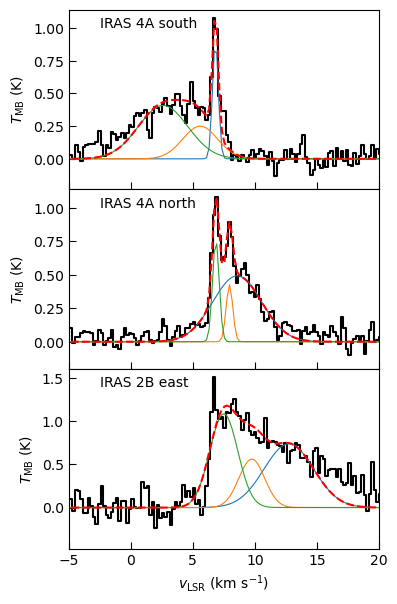

In [127]:
fig, axlist = plt.subplots(3, 1, figsize=(4,7), sharex=True)
fig.subplots_adjust(hspace=0)
for i, ax in enumerate(axlist):
    pixx, pixy = wcs.all_world2pix([position_wings_x[i]], [position_wings_y[i]], 0)
    pixx, pixy = int(pixx[0]), int(pixy[0])
    intensity = cubehc3n[:, pixy, pixx]
    ax.plot(velocityarray, intensity, drawstyle='steps-mid', color='k')
    # 
    ax.set_ylabel(r'$T_{\mathrm{MB}}$ (K)')
    ax.annotate(str(labels_wings[i]), (0.1, 0.9), xycoords='axes fraction')
    ax.set_xlim([-5, 20])
    curve_total = np.zeros(np.shape(velocityarray))
    n = 2
    while n != -1:
        gaussian = Gaussian1D(amplitude=mlex_all[2][0+n*3, pixy, pixx], mean=mlex_all[2][1+n*3, pixy, pixx], stddev=mlex_all[2][2+n*3, pixy, pixx])
        curve_total += gaussian(velocityarray.value)
        ax.plot(velocityarray, gaussian(velocityarray.value), linewidth=0.8)
        n -= 1
    ax.plot(velocityarray, curve_total, 'r--')
    ax.tick_params(axis='both', direction='in', length=5)
ax.set_xlabel(r'$v_{\mathrm{LSR}}$ (km s$^{-1}$)')

fig.savefig('figures/HC3N_spectra_wings.pdf', bbox_inches='tight', dpi=100)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), subplot_kw={'projection': wcs})
cmap = cm.get_cmap('YlGnBu', 4).copy()
ncompbayes[np.where(np.isnan(ncompbayes))] = 0
# ncompflag[np.where(np.isnan(ncompflag))] = 0.

sc1 = ax.imshow(ncompbayes,  cmap=cmap, vmin=-0.5, vmax=3.5)
cax = plt.colorbar(sc1, ax=ax, label='Number of fit components', ticks=np.arange(4))
# ax.contour(ncompflag, levels=[0.5], colors='w', linewidths=0.5)

lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')

add_beam(ax, major=bmaj, minor=bmin, angle=bpa, color='k', pad=0.1)
add_scalebar(ax, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))

for ra, dec, label in zip(positionsx, positionsy, labels_spectra):
    ax.scatter(ra, dec, transform=ax.get_transform('world'), marker='d', facecolor='None', edgecolor='w', s=50, zorder=100)
    ax.text(ra-0.002, dec-0.002, str(label), transform=ax.get_transform('world'), fontsize=8, color='k')
ax.set_facecolor(cmap(0))
# fig.savefig('figures/HC3N_ncompbayes_wsnr.pdf', bbox_inches='tight', dpi=100)

In [ ]:
for ra, dec, label in zip(positionsx, positionsy, labels_spectra):
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_subplot(111)
    pixx, pixy = wcs.all_world2pix([ra], [dec], 0)
    pixx, pixy = int(pixx[0]), int(pixy[0])
    
    intensity = cubehc3n[:, pixy, pixx]
    ax.plot(velocityarray, intensity, drawstyle='steps-mid', color='k', linewidth=0.5)
    ax.set_xlabel(r'$v_{\mathrm{LSR}}$ (km s$^{-1}$)')
    ax.set_ylabel(r'$T_{\mathrm{MB}}$ (K)')
    ax.annotate(str(label), (0.1, 0.9), xycoords='axes fraction')
    ax.set_xlim([-5, 20])
    n = int(ncompbayes[pixy, pixx] - 1)
    if n == -1: print('Position {0}, {1} has no fit'.format(ra, dec))
    elif n==0:
        gaussian = Gaussian1D(amplitude=mlex_all[0][0, pixy, pixx], mean=mlex_all[0][1, pixy, pixx], stddev=mlex_all[0][2, pixy, pixx])
        ax.plot(velocityarray, gaussian(velocityarray.value))
    elif n==1:
        curve_total = np.zeros(np.shape(velocityarray))
        while n != -1:
            gaussian = Gaussian1D(amplitude=mlex_all[1][0+n*3, pixy, pixx], mean=mlex_all[1][1+n*3, pixy, pixx], stddev=mlex_all[1][2+n*3, pixy, pixx])
            curve_total += gaussian(velocityarray.value)
            ax.plot(velocityarray, gaussian(velocityarray.value))
            n-=1
        ax.plot(velocityarray, curve_total, 'k--')
    else:
        curve_total = np.zeros(np.shape(velocityarray))
        while n != -1:
            gaussian = Gaussian1D(amplitude=mlex_all[2][0+n*3, pixy, pixx], mean=mlex_all[2][1+n*3, pixy, pixx], stddev=mlex_all[2][2+n*3, pixy, pixx])
            curve_total += gaussian(velocityarray.value)
            ax.plot(velocityarray, gaussian(velocityarray.value))
            n-=1
        ax.plot(velocityarray, curve_total, 'k--')
    
                      
    

In [ ]:
# we can also plot the spectra in the locations of the protostars
for i in catalog_protostars.index.values:
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_subplot(111)
    pixx, pixy = wcs.all_world2pix([catalog_protostars.loc[i, 'RAJ2000']], [catalog_protostars.loc[i, 'DEJ2000']], 0)
    pixx, pixy = int(pixx[0]), int(pixy[0])
    shape = np.shape(cubehc3n[0])
    if pixx > shape[1] or pixy > shape[0]: continue
    
    intensity = cubehc3n[:, pixy, pixx]
    ax.plot(velocityarray, intensity, drawstyle='steps-mid', color='k', linewidth=0.5)
    ax.set_xlabel(r'$v_{\mathrm{LSR}}$ (km s$^{-1}$)')
    ax.set_ylabel(r'$T_{\mathrm{MB}}$ (K)')
    ax.annotate(catalog_protostars.loc[i, 'Source'], (0.1, 0.9), xycoords='axes fraction')
    ax.set_xlim([-5, 20])
    n = int(ncompbayes[pixy, pixx] - 1)
    if n == -1: print('Position {0}, {1} has no fit'.format(ra, dec))
    elif n==0:
        gaussian = Gaussian1D(amplitude=mlex_all[0][0, pixy, pixx], mean=mlex_all[0][1, pixy, pixx], stddev=mlex_all[0][2, pixy, pixx])
        ax.plot(velocityarray, gaussian(velocityarray.value))
    elif n==1:
        curve_total = np.zeros(np.shape(velocityarray))
        while n != -1:
            gaussian = Gaussian1D(amplitude=mlex_all[1][0+n*3, pixy, pixx], mean=mlex_all[1][1+n*3, pixy, pixx], stddev=mlex_all[1][2+n*3, pixy, pixx])
            curve_total += gaussian(velocityarray.value)
            ax.plot(velocityarray, gaussian(velocityarray.value))
            n-=1
        ax.plot(velocityarray, curve_total, 'k--')
    else:
        curve_total = np.zeros(np.shape(velocityarray))
        while n != -1:
            gaussian = Gaussian1D(amplitude=mlex_all[2][0+n*3, pixy, pixx], mean=mlex_all[2][1+n*3, pixy, pixx], stddev=mlex_all[2][2+n*3, pixy, pixx])
            curve_total += gaussian(velocityarray.value)
            ax.plot(velocityarray, gaussian(velocityarray.value))
            n-=1
        ax.plot(velocityarray, curve_total, 'k--')
    
                      
    

In [ ]:
# there are two peaks that are only one gaussian that call my attention
# one of them coincides with an N2Hp peak, but the other one does not.
positionsx_peaks = [52.2503987, 52.2735308]
positionsy_peaks = [31.2515837, 31.2691702]
labels = ['Peak 1', 'Peak2']
for ra, dec, label in zip(positionsx_peaks, positionsy_peaks, labels):
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_subplot(111)
    pixx, pixy = wcs.all_world2pix([ra], [dec], 0)
    pixx, pixy = int(pixx[0]), int(pixy[0])
    
    intensity = cubehc3n[:, pixy, pixx]
    ax.plot(velocityarray, intensity, drawstyle='steps-mid', color='k', linewidth=0.5)
    ax.set_xlabel(r'$v_{\mathrm{LSR}}$ (km s$^{-1}$)')
    ax.set_ylabel(r'$T_{\mathrm{MB}}$ (K)')
    ax.annotate(str(label), (0.1, 0.9), xycoords='axes fraction')
    ax.set_xlim([-5, 20])
    n = int(ncompbayes[pixy, pixx] - 1)
    if n == -1: print('Position {0}, {1} has no fit'.format(ra, dec))
    elif n==0:
        gaussian = Gaussian1D(amplitude=mlex_all[0][0, pixy, pixx], mean=mlex_all[0][1, pixy, pixx], stddev=mlex_all[0][2, pixy, pixx])
        ax.plot(velocityarray, gaussian(velocityarray.value))
    elif n==1:
        curve_total = np.zeros(np.shape(velocityarray))
        while n != -1:
            gaussian = Gaussian1D(amplitude=mlex_all[1][0+n*3, pixy, pixx], mean=mlex_all[1][1+n*3, pixy, pixx], stddev=mlex_all[1][2+n*3, pixy, pixx])
            curve_total += gaussian(velocityarray.value)
            ax.plot(velocityarray, gaussian(velocityarray.value))
            n-=1
        ax.plot(velocityarray, curve_total, 'k--')
    else:
        curve_total = np.zeros(np.shape(velocityarray))
        while n != -1:
            gaussian = Gaussian1D(amplitude=mlex_all[2][0+n*3, pixy, pixx], mean=mlex_all[2][1+n*3, pixy, pixx], stddev=mlex_all[2][2+n*3, pixy, pixx])
            curve_total += gaussian(velocityarray.value)
            ax.plot(velocityarray, gaussian(velocityarray.value))
            n-=1
        ax.plot(velocityarray, curve_total, 'k--')
    



### Zoom: outflow region of Per-emb 27

/tmp/ipykernel_6193/435767601.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('inferno').copy()


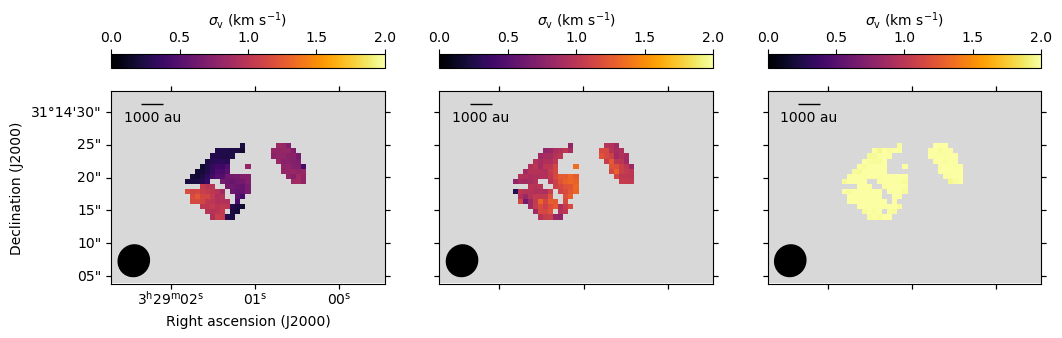

In [55]:
fig, axes = plt.subplots(1, 3, figsize=(12,6), subplot_kw={'projection': wcs})
cmap = cm.get_cmap('inferno').copy()
cmap.set_bad('0.85')
vminlist = [0, 0, 0]
vmaxlist = [2, 2, 2]

scalebarsizes = 1000
scalebardegs = (scalebarsizes / distance) / 3600 * u.deg

# velocity_maps = np.array([np.nansum([hc3nmlex3[1], hc3nmlex2[1]], axis=0), np.nansum([hc3nmlex3[4], hc3nmlex2[4]], axis=0), hc3nmlex3[7]])
velocity_maps = np.array([hc3nmlex3[2], hc3nmlex3[5], hc3nmlex3[8]])


for i, ax in enumerate(axes):
    sc = ax.imshow(velocity_maps[i], cmap=cmap, vmin=vminlist[i], vmax=vmaxlist[i])
    fig.colorbar(sc, ax=ax, location='top', label=r'$\sigma_{\mathrm{v}}$ (km s$^{-1}$)')
    ax.set_xlim([356, 410])
    ax.set_ylim([280, 318])
    lon = ax.coords[0]
    lat = ax.coords[1]
    if i:
        lon.set_ticklabel_visible(False)
        lat.set_ticklabel_visible(False)
        lon.set_axislabel('')
        lat.set_axislabel('')
    else:
        lon.set_axislabel('Right ascension (J2000)')
        lat.set_axislabel('Declination (J2000)')

    add_beam(ax, major=bmaj, minor=bmin, angle=bpa, color='k', pad=0.1)
    add_scalebar(ax, scalebardegs, corner='top left', label='{} au'.format(scalebarsizes))

## Clustering results

In [7]:
cluster0_N2Hp_file = 'clustering/cluster0_DBSCAN_N2Hp.fits'
cluster1_N2Hp_file = 'clustering/cluster1_DBSCAN_N2Hp.fits'
cluster2_N2Hp_file = 'clustering/cluster2_DBSCAN_N2Hp.fits'
cluster3_N2Hp_file = 'clustering/cluster3_DBSCAN_N2Hp.fits'
cluster4_N2Hp_file = 'clustering/cluster4_DBSCAN_N2Hp.fits'

cluster0_manual_HC3N_file = 'clustering/cluster0_manual_HC3N.fits'
cluster1_manual_HC3N_file = 'clustering/cluster1_manual_HC3N.fits'
cluster0_dist_HC3N_file = 'clustering/cluster1_HC3N_w0.5_r2.fits'

cluster0_HC3N_file = 'clustering/cluster0_HDBSCAN_HC3N.fits'
cluster1_HC3N_file = 'clustering/cluster1_HDBSCAN_HC3N.fits'
cluster2_HC3N_file = 'clustering/cluster2_HDBSCAN_HC3N.fits'
cluster3_HC3N_file = 'clustering/cluster3_HDBSCAN_HC3N.fits'
cluster4_HC3N_file = 'clustering/cluster4_HDBSCAN_HC3N.fits'
cluster5_HC3N_file = 'clustering/cluster5_HDBSCAN_HC3N.fits'
cluster6_HC3N_file = 'clustering/cluster6_HDBSCAN_HC3N.fits'
cluster7_HC3N_file = 'clustering/cluster7_HDBSCAN_HC3N.fits'

diff_cluster0_dist_HC3N_N2Hp_min_file = 'clustering/diff_HC3N_w_N2Hp_minimum' #this can be also kde 
diff_cluster0_manual_HC3N_cluster0_dbscan_N2Hp_file = 'clustering/diff_HC3N_0_w_N2Hp_clump0' #this can be also kde 
diff_cluster1_manual_HC3N_cluster1_dbscan_N2Hp_file = 'clustering/diff_HC3N_1_w_N2Hp_clump1' #this can be also kde 

In [8]:
cluster0_N2Hp, header_clusterN2Hp = fits.getdata(cluster0_N2Hp_file, header=True)
cluster1_N2Hp = fits.getdata(cluster1_N2Hp_file)
cluster2_N2Hp = fits.getdata(cluster2_N2Hp_file)
cluster3_N2Hp = fits.getdata(cluster3_N2Hp_file)
cluster4_N2Hp = fits.getdata(cluster4_N2Hp_file)

cluster0_dist_HC3N = fits.getdata(cluster0_dist_HC3N_file)
cluster0_manual_HC3N = fits.getdata(cluster0_manual_HC3N_file)
cluster1_manual_HC3N = fits.getdata(cluster1_manual_HC3N_file)

cluster0_HC3N, header_clusterHC3N = fits.getdata(cluster0_HC3N_file, header=True)
cluster1_HC3N = fits.getdata(cluster1_HC3N_file)
cluster2_HC3N = fits.getdata(cluster2_HC3N_file)
cluster3_HC3N = fits.getdata(cluster3_HC3N_file)
cluster4_HC3N = fits.getdata(cluster4_HC3N_file)
cluster5_HC3N = fits.getdata(cluster5_HC3N_file)
cluster6_HC3N = fits.getdata(cluster6_HC3N_file)
cluster7_HC3N = fits.getdata(cluster7_HC3N_file)


wcs_N2Hp = WCS(header_clusterN2Hp).celestial
wcs_HC3N = WCS(header_clusterHC3N).celestial

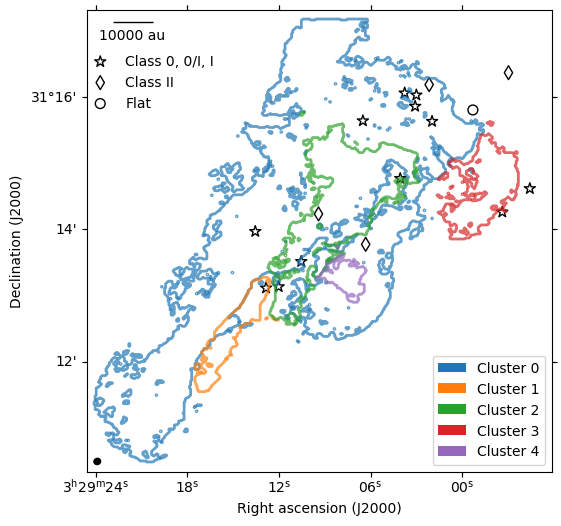

In [30]:
# we check the positions of all the clusters
n2hpclusterlist = [cluster0_N2Hp, cluster1_N2Hp, cluster2_N2Hp, cluster3_N2Hp, cluster4_N2Hp]
mask_n2hp_cluster = np.zeros((5, header_clusterN2Hp['NAXIS2'], header_clusterN2Hp['NAXIS1']))

palette = sns.color_palette()
colors = [palette[col] for col in range(len(n2hpclusterlist))]
fig, ax = plt.subplots(1, 1, figsize=(6,6), subplot_kw={'projection': wcsn2hp})

for i, cluster in enumerate(n2hpclusterlist):
    mask_n2hp_cluster[i, :, :] = np.where(~np.isnan(cluster[0]), 1, 0)
    color = colors[i]
    cs = ax.contour(mask_n2hp_cluster[i], colors=[color], levels=[0.5], linewidths=2, alpha=0.7)

proxy = [plt.Rectangle((0,0),1,1,fc = colors[i]) for i in range(len(n2hpclusterlist))]
legends = ['Cluster {}'.format(i) for i in range(len(n2hpclusterlist))]
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')
add_beam(ax, major=bmajn2hp, minor=bminn2hp, angle=bpan2hp, color='k', pad=0.1)
add_scalebar(ax, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))
first_legend = plt.legend(proxy, legends, loc=4)
ax.add_artist(first_legend)

for i in catalog_protostars.index.values:
    if catalog_protostars.loc[i, 'Class'] == 'I' or catalog_protostars.loc[i, 'Class'] == '0' or catalog_protostars.loc[i, 'Class'] == '0/I':
        class0dot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='*', facecolor='None', edgecolor='k', s=70)
    elif catalog_protostars.loc[i, 'Class'] == 'II' or catalog_protostars.loc[i, 'Class'] == 'III':
        classIIdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='d', facecolor='None', edgecolor='k', s=50)
    elif catalog_protostars.loc[i, 'Class'] == 'Flat':
        classflatdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='o', facecolor='None', edgecolor='k', s=50)
    else: continue
ax.legend([class0dot, classIIdot, classflatdot], ['Class 0, 0/I, I', 'Class II', 'Flat'], frameon=False, loc='upper right', bbox_to_anchor=(0.3, 0.93))

fig.savefig('figures/N2Hp_clusters_DBSCAN.pdf', bbox_inches='tight', dpi=100)

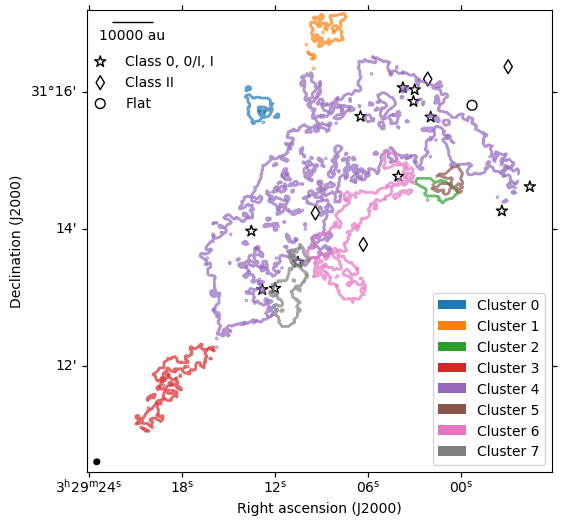

In [31]:
hc3nclusterlist = [cluster0_HC3N, cluster1_HC3N, cluster2_HC3N, cluster3_HC3N, cluster4_HC3N, cluster5_HC3N, cluster6_HC3N, cluster7_HC3N]
mask_hc3n_cluster = np.zeros((len(hc3nclusterlist), header_clusterHC3N['NAXIS2'], header_clusterHC3N['NAXIS1']))

palette = sns.color_palette()
colors = [palette[col] for col in range(len(hc3nclusterlist))]
fig, ax = plt.subplots(1, 1, figsize=(6,6), subplot_kw={'projection': wcs})

for i, cluster in enumerate(hc3nclusterlist):
    mask_hc3n_cluster[i, :, :] = np.where(~np.isnan(cluster[0]), 1, 0)
    color = colors[i]
    ax.contour(mask_hc3n_cluster[i], colors=[color], levels=[0.5], linewidths=2, alpha=0.7)

lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')
add_beam(ax, major=bmaj, minor=bmin, angle=bpa, color='k', pad=0.1)
add_scalebar(ax, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))
proxy = [plt.Rectangle((0,0),1,1,fc = colors[i]) for i in range(len(hc3nclusterlist))]
legends = ['Cluster {}'.format(i) for i in range(len(hc3nclusterlist))]
first_legend = plt.legend(proxy, legends, loc=4)
ax.add_artist(first_legend)

for i in catalog_protostars.index.values:
    if catalog_protostars.loc[i, 'Class'] == 'I' or catalog_protostars.loc[i, 'Class'] == '0' or catalog_protostars.loc[i, 'Class'] == '0/I':
        class0dot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='*', facecolor='None', edgecolor='k', s=70)
    elif catalog_protostars.loc[i, 'Class'] == 'II' or catalog_protostars.loc[i, 'Class'] == 'III':
        classIIdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='d', facecolor='None', edgecolor='k', s=50)
    elif catalog_protostars.loc[i, 'Class'] == 'Flat':
        classflatdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='o', facecolor='None', edgecolor='k', s=50)
    else: continue
ax.legend([class0dot, classIIdot, classflatdot], ['Class 0, 0/I, I', 'Class II', 'Flat'], frameon=False, loc='upper right', bbox_to_anchor=(0.3, 0.93))

fig.savefig('figures/HC3N_clusters_HDBSCAN.pdf', bbox_inches='tight', dpi=100)

/tmp/ipykernel_30919/4168421832.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmaplist[i]).copy()


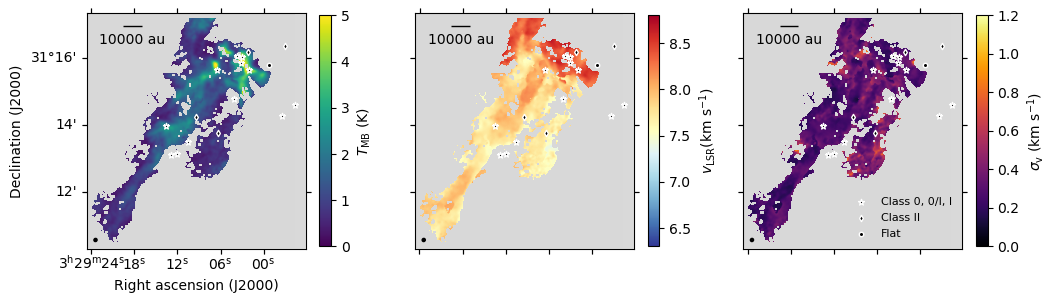

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(12,6), subplot_kw={'projection': wcs_N2Hp})

vminlist = [0,6.3,0]
vmaxlist = [5,8.8,1.2]
labels = [r'$T_{\mathrm{MB}}$ (K)', r'$v_{\mathrm{LSR}}$(km s$^{-1}$)', r'$\sigma_{\mathrm{v}}$ (km s$^{-1}$)']
cmaplist = ['viridis', 'RdYlBu_r','inferno']
for i, ax in enumerate(axes):
    cmap = cm.get_cmap(cmaplist[i]).copy()
    cmap.set_bad('0.85')
    sc1 = ax.imshow(cluster0_N2Hp[i], cmap=cmap, vmin=vminlist[i], vmax=vmaxlist[i])
    lon = ax.coords[0]
    lat = ax.coords[1]
    # ax.contour(ncompflag, levels=[0.5], colors='w', linewidths=0.5)
    if i:
        lon.set_ticklabel_visible(False)
        lat.set_ticklabel_visible(False)
        lon.set_axislabel('')
        lat.set_axislabel('')
    else:
        lon.set_axislabel('Right ascension (J2000)')
        lat.set_axislabel('Declination (J2000)')
    fig.colorbar(sc1, ax=ax, label=labels[i], shrink=0.5)
    add_beam(ax, major=bmajn2hp, minor=bminn2hp, angle=bpan2hp, color='k', pad=0.1)
    ax.set_facecolor('0.85')
    add_scalebar(ax, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))

    for j in catalog_protostars.index.values:
        if catalog_protostars.loc[j, 'Class'] == 'I' or catalog_protostars.loc[j, 'Class'] == '0' or catalog_protostars.loc[j, 'Class'] == '0/I':
            class0dot = ax.scatter(catalog_protostars.loc[j, 'RAJ2000'], catalog_protostars.loc[j, 'DEJ2000'], 
                       transform=ax.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=20, zorder=100)
        elif catalog_protostars.loc[j, 'Class'] == 'II' or catalog_protostars.loc[j, 'Class'] == 'III':
            classIIdot = ax.scatter(catalog_protostars.loc[j, 'RAJ2000'], catalog_protostars.loc[j, 'DEJ2000'], 
                       transform=ax.get_transform('world'), marker='d', facecolor='k', edgecolor='w', s=10, zorder=100)
        elif catalog_protostars.loc[j, 'Class'] == 'Flat':
            classflatdot = ax.scatter(catalog_protostars.loc[j, 'RAJ2000'], catalog_protostars.loc[j, 'DEJ2000'], 
                       transform=ax.get_transform('world'), marker='o', facecolor='k', edgecolor='w', s=10, zorder=100)
        else: continue
    if i == 2 : ax.legend([class0dot, classIIdot, classflatdot], ['Class 0, 0/I, I', 'Class II', 'Flat'], frameon=False, loc=4,fontsize=8)
fig.savefig('figures/N2Hp_cluster0_DBSCAN.pdf', bbox_inches='tight', dpi=100)

/tmp/ipykernel_30919/2270345674.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmaplist[i]).copy()


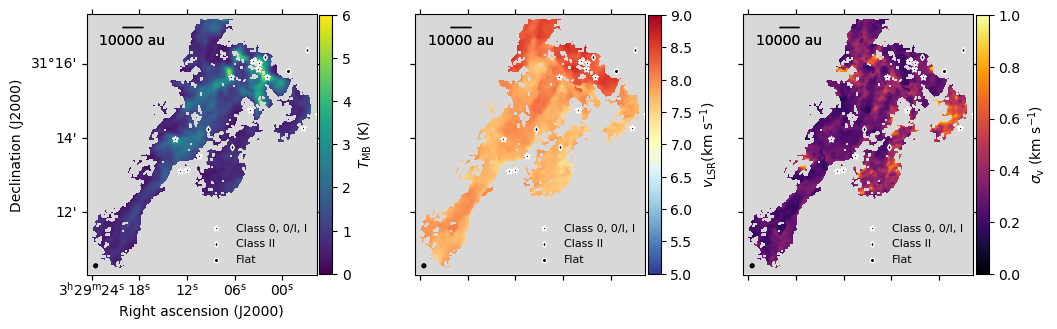

In [33]:
# We now know which clusters we can plot together in velocity:
# Clusters 0, and 3 for N2Hp

clusters_red_list_N2Hp = [cluster0_N2Hp, cluster3_N2Hp]

rangemin = [0, 5, 0]
rangemax = [6, 9, 1]

cmaplist = ['viridis', 'RdYlBu_r','inferno']
labels = [r'$T_{\mathrm{MB}}$ (K)', r'$v_{\mathrm{LSR}}$(km s$^{-1}$)', r'$\sigma_{\mathrm{v}}$ (km s$^{-1}$)']

fig, axes = plt.subplots(1, 3, figsize=(12,6), subplot_kw={'projection': wcsn2hp})
for k, cluster in enumerate(clusters_red_list_N2Hp):
    for i in range(3):
        cmap = cm.get_cmap(cmaplist[i]).copy()
        if not k: cmap.set_bad('0.85')
        else: cmap.set_bad('0.85', alpha=0)
        sc1 = axes[i].imshow(cluster[i], cmap = cmap, vmin=rangemin[i], vmax=rangemax[i])
        lon = axes[i].coords[0]
        lat = axes[i].coords[1]
        if i:
            lon.set_ticklabel_visible(False)
            lat.set_ticklabel_visible(False)
            lon.set_axislabel('')
            lat.set_axislabel('')
        else:
            lon.set_axislabel('Right ascension (J2000)')
            lat.set_axislabel('Declination (J2000)')
        if not k:
            fig.colorbar(sc1, ax=axes[i], label=labels[i], shrink=0.56, pad=0.01)
            
            for j in catalog_protostars.index.values:
                if catalog_protostars.loc[j, 'Class'] == 'I' or catalog_protostars.loc[j, 'Class'] == '0' or catalog_protostars.loc[j, 'Class'] == '0/I':
                    class0dot = axes[i].scatter(catalog_protostars.loc[j, 'RAJ2000'], catalog_protostars.loc[j, 'DEJ2000'], 
                               transform=axes[i].get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=20, zorder=100)
                elif catalog_protostars.loc[j, 'Class'] == 'II' or catalog_protostars.loc[j, 'Class'] == 'III':
                    classIIdot = axes[i].scatter(catalog_protostars.loc[j, 'RAJ2000'], catalog_protostars.loc[j, 'DEJ2000'], 
                               transform=axes[i].get_transform('world'), marker='d', facecolor='k', edgecolor='w', s=10, zorder=100)
                elif catalog_protostars.loc[j, 'Class'] == 'Flat':
                    classflatdot = axes[i].scatter(catalog_protostars.loc[j, 'RAJ2000'], catalog_protostars.loc[j, 'DEJ2000'], 
                               transform=axes[i].get_transform('world'), marker='o', facecolor='k', edgecolor='w', s=10, zorder=100)
                else: continue
            axes[i].legend([class0dot, classIIdot, classflatdot], ['Class 0, 0/I, I', 'Class II', 'Flat'], frameon=False, loc=4,fontsize=8)

        add_beam(axes[i], major=bmajn2hp, minor=bminn2hp, angle=bpan2hp, color='k', pad=0.1)

        add_scalebar(axes[i], scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))
fig.savefig('figures/N2Hp_cluster0_3_props.pdf', bbox_inches='tight', dpi=300)

/tmp/ipykernel_30919/144702077.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmaplist[i]).copy()


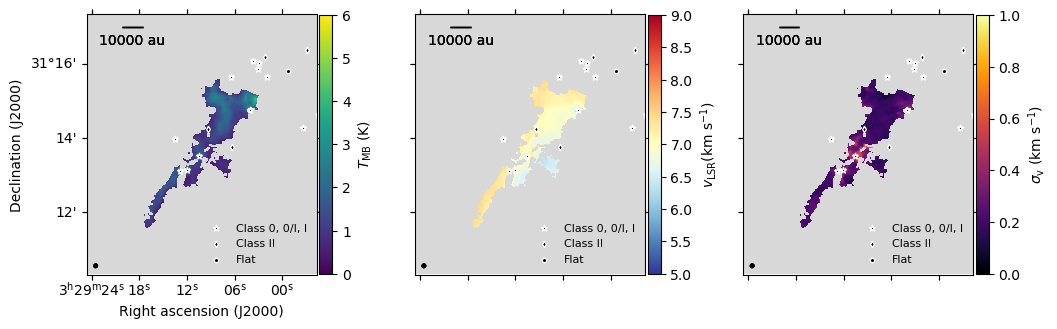

In [34]:
# We now know which clusters we can plot together in velocity:
# Clusters 1, 2 and 4 for N2Hp

clusters_blue_list_N2Hp = [cluster1_N2Hp, cluster2_N2Hp, cluster4_N2Hp]

rangemin = [0, 5, 0]
rangemax = [6, 9, 1]

cmaplist = ['viridis', 'RdYlBu_r','inferno']
labels = [r'$T_{\mathrm{MB}}$ (K)', r'$v_{\mathrm{LSR}}$(km s$^{-1}$)', r'$\sigma_{\mathrm{v}}$ (km s$^{-1}$)']

fig, axes = plt.subplots(1, 3, figsize=(12,6), subplot_kw={'projection': wcsn2hp})
for k, cluster in enumerate(clusters_blue_list_N2Hp):
    for i in range(3):
        cmap = cm.get_cmap(cmaplist[i]).copy()
        if not k: cmap.set_bad('0.85')
        else: cmap.set_bad('0.85', alpha=0)
        sc1 = axes[i].imshow(cluster[i], cmap = cmap, vmin=rangemin[i], vmax=rangemax[i])
        lon = axes[i].coords[0]
        lat = axes[i].coords[1]
        if i:
            lon.set_ticklabel_visible(False)
            lat.set_ticklabel_visible(False)
            lon.set_axislabel('')
            lat.set_axislabel('')
        else:
            lon.set_axislabel('Right ascension (J2000)')
            lat.set_axislabel('Declination (J2000)')
        if not k:
            fig.colorbar(sc1, ax=axes[i], label=labels[i], shrink=0.56, pad=0.01)
            
            for j in catalog_protostars.index.values:
                if catalog_protostars.loc[j, 'Class'] == 'I' or catalog_protostars.loc[j, 'Class'] == '0' or catalog_protostars.loc[j, 'Class'] == '0/I':
                    class0dot = axes[i].scatter(catalog_protostars.loc[j, 'RAJ2000'], catalog_protostars.loc[j, 'DEJ2000'], 
                               transform=axes[i].get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=20, zorder=100)
                elif catalog_protostars.loc[j, 'Class'] == 'II' or catalog_protostars.loc[j, 'Class'] == 'III':
                    classIIdot = axes[i].scatter(catalog_protostars.loc[j, 'RAJ2000'], catalog_protostars.loc[j, 'DEJ2000'], 
                               transform=axes[i].get_transform('world'), marker='d', facecolor='k', edgecolor='w', s=10, zorder=100)
                elif catalog_protostars.loc[j, 'Class'] == 'Flat':
                    classflatdot = axes[i].scatter(catalog_protostars.loc[j, 'RAJ2000'], catalog_protostars.loc[j, 'DEJ2000'], 
                               transform=axes[i].get_transform('world'), marker='o', facecolor='k', edgecolor='w', s=10, zorder=100)
                else: continue
            axes[i].legend([class0dot, classIIdot, classflatdot], ['Class 0, 0/I, I', 'Class II', 'Flat'], frameon=False, loc=4,fontsize=8)

        add_beam(axes[i], major=bmajn2hp, minor=bminn2hp, angle=bpan2hp, color='k', pad=0.1)

        add_scalebar(axes[i], scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))
fig.savefig('figures/N2Hp_cluster1_2_4_props.pdf', bbox_inches='tight', dpi=300)

/tmp/ipykernel_30919/3047141293.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdYlBu_r').copy()


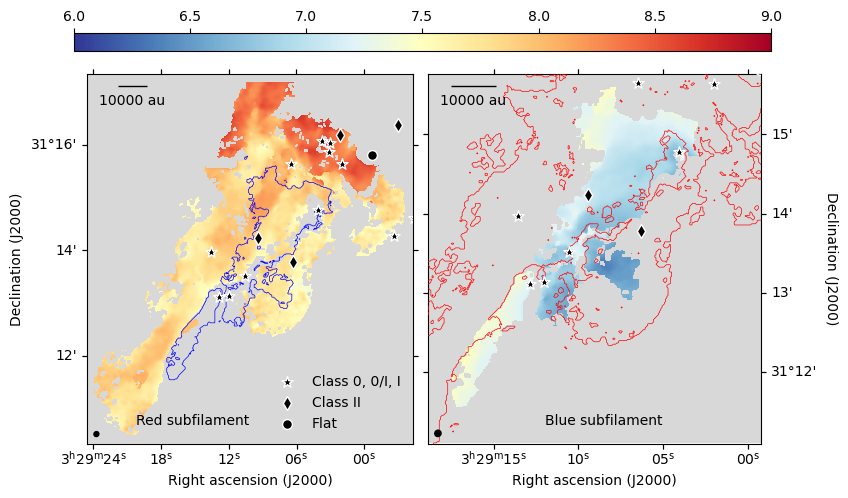

In [128]:
# Only velocity of both sub-filaments
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10,6), subplot_kw={'projection': wcsn2hp})
fig.subplots_adjust(wspace=-0.2)
vmin = 6
vmax = 9
cmap = cm.get_cmap('RdYlBu_r').copy()
cmap.set_bad('0.85')
map_blue = np.nansum(np.array(clusters_blue_list_N2Hp)[:, 1, :, :], axis=0)
map_blue[np.where(map_blue<1e-2)] = np.nan
mask_blue = np.where(~np.isnan(map_blue), 1, 0)
map_red = np.nansum(np.array(clusters_red_list_N2Hp)[:, 1, :, :], axis=0)
map_red[np.where(map_red<1e-2)] = np.nan
mask_red = np.where(~np.isnan(map_red), 1, 0)

sc1 = ax1.imshow(map_red, cmap = cmap, vmin=vmin, vmax=vmax)
lon = ax1.coords[0]
lat = ax1.coords[1]
ax1.contour(mask_blue, levels=[0.5], colors='b', linewidths=0.5)
add_beam(ax1, major=bmajn2hp, minor=bminn2hp, angle=bpan2hp, color='k', pad=0.1)
add_scalebar(ax1, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')

for i in catalog_protostars.index.values:
    if catalog_protostars.loc[i, 'Class'] == 'I' or catalog_protostars.loc[i, 'Class'] == '0' or catalog_protostars.loc[i, 'Class'] == '0/I':
        class0dot = ax1.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax1.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=70, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'II' or catalog_protostars.loc[i, 'Class'] == 'III':
        classIIdot = ax1.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax1.get_transform('world'), marker='d', facecolor='k', edgecolor='w', s=50, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'Flat':
        classflatdot = ax1.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax1.get_transform('world'), marker='o', facecolor='k', edgecolor='w', s=50, zorder=100)
    else: continue
ax1.legend([class0dot, classIIdot, classflatdot], ['Class 0, 0/I, I', 'Class II', 'Flat'], frameon=False, loc=4)
ax1.set_xlim([0, np.shape(map_red)[1]])
ax1.set_ylim([0, np.shape(map_red)[0]])
ax1.set_facecolor('0.85')

sc2 = ax2.imshow(map_blue, cmap = cmap, vmin=vmin, vmax=vmax)
lon = ax2.coords[0]
lat = ax2.coords[1]
ax2.tick_params(axis='y', which='both', labelleft=False, labelright=True)
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')
lat.set_axislabel_position('r')
ax2.contour(mask_red, levels=[0.5], colors='r', linewidths=0.5)
add_beam(ax2, major=bmaj, minor=bmin, angle=bpa, color='k', pad=0.1)
add_scalebar(ax2, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))
ax2.set_xlim([80, np.shape(map_blue)[1]-50])
ax2.set_ylim([50, np.shape(map_blue)[1]-50])
for i in catalog_protostars.index.values:
    if catalog_protostars.loc[i, 'Class'] == 'I' or catalog_protostars.loc[i, 'Class'] == '0' or catalog_protostars.loc[i, 'Class'] == '0/I':
        class0dot = ax2.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax2.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=70, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'II' or catalog_protostars.loc[i, 'Class'] == 'III':
        classIIdot = ax2.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax2.get_transform('world'), marker='d', facecolor='k', edgecolor='w', s=50, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'Flat':
        classflatdot = ax2.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax2.get_transform('world'), marker='o', facecolor='k', edgecolor='w', s=50, zorder=100)
    else: continue

fig.colorbar(sc1, ax=[ax1, ax2], location='top', shrink=0.9, aspect=40)
ax1.annotate('Red subfilament', (0.15, 0.05), xycoords='axes fraction')
ax2.annotate('Blue subfilament', (0.35, 0.05), xycoords='axes fraction')

# only if we want to add magnetic fields
# for ra_i, dec_i, dra_i, ddec_i in zip(ra_pol, dec_pol, dra_pol, ddec_pol):
#     position_i = SkyCoord(ra_i * u.deg, dec_i * u.deg, frame='fk5')
#     # two pieces of coordinates
#     position_vector_1 = position_i.spherical_offsets_by(dra_i * u.arcsec, ddec_i * u.arcsec)
#     position_vector_2 = position_i.spherical_offsets_by(-dra_i * u.arcsec, -ddec_i * u.arcsec)
#     ax1.plot([position_vector_1.ra.deg, position_vector_2.ra.deg], 
#             [position_vector_1.dec.deg, position_vector_2.dec.deg], zorder=10, 
#             color='black', transform=ax1.get_transform('world'), lw=2)
#     ax2.plot([position_vector_1.ra.deg, position_vector_2.ra.deg], 
#             [position_vector_1.dec.deg, position_vector_2.dec.deg], zorder=10, 
#             color='black', transform=ax2.get_transform('world'), lw=2)
#     ax1.plot([position_vector_1.ra.deg, position_vector_2.ra.deg], 
#             [position_vector_1.dec.deg, position_vector_2.dec.deg], zorder=11,
#             color='white', transform=ax1.get_transform('world'), lw=1)
#     ax2.plot([position_vector_1.ra.deg, position_vector_2.ra.deg], 
#             [position_vector_1.dec.deg, position_vector_2.dec.deg], zorder=11,
#             color='white', transform=ax2.get_transform('world'), lw=1)


fig.savefig('figures/N2Hp_clusters_subfilaments_vel.pdf', bbox_inches='tight', dpi=300)

/tmp/ipykernel_30919/686664147.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmaplist[i]).copy()


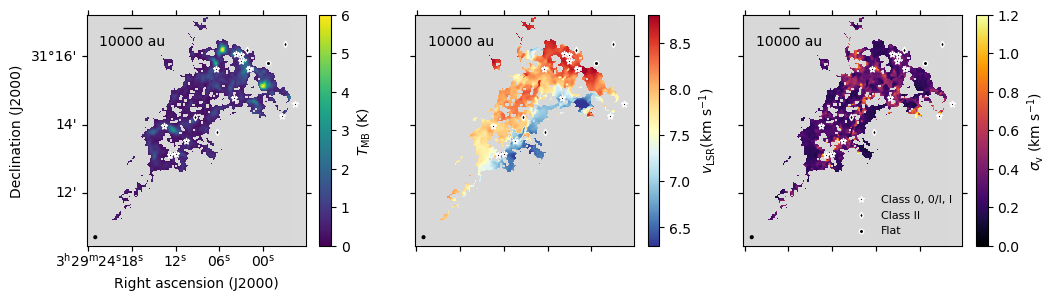

In [35]:
fig, axes = plt.subplots(1, 3, figsize=(12,6), subplot_kw={'projection': wcs_HC3N})

vminlist = [0,6.3,0]
vmaxlist = [6,8.8,1.2]
labels = [r'$T_{\mathrm{MB}}$ (K)', r'$v_{\mathrm{LSR}}$(km s$^{-1}$)', r'$\sigma_{\mathrm{v}}$ (km s$^{-1}$)']
cmaplist = ['viridis', 'RdYlBu_r','inferno']
for i, ax in enumerate(axes):
    cmap = cm.get_cmap(cmaplist[i]).copy()
    cmap.set_bad('0.85')
    sc1 = ax.imshow(cluster0_dist_HC3N[i], cmap=cmap, vmin=vminlist[i], vmax=vmaxlist[i])
    lon = ax.coords[0]
    lat = ax.coords[1]
    # ax.contour(ncompflag, levels=[0.5], colors='w', linewidths=0.5)
    if i:
        lon.set_ticklabel_visible(False)
        lat.set_ticklabel_visible(False)
        lon.set_axislabel('')
        lat.set_axislabel('')
    else:
        lon.set_axislabel('Right ascension (J2000)')
        lat.set_axislabel('Declination (J2000)')
    fig.colorbar(sc1, ax=ax, label=labels[i], shrink=0.5)
    add_beam(ax, major=bmaj, minor=bmin, angle=bpa, color='k', pad=0.1)
    ax.set_facecolor('0.85')
    add_scalebar(ax, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))

    for j in catalog_protostars.index.values:
        if catalog_protostars.loc[j, 'Class'] == 'I' or catalog_protostars.loc[j, 'Class'] == '0' or catalog_protostars.loc[j, 'Class'] == '0/I':
            class0dot = ax.scatter(catalog_protostars.loc[j, 'RAJ2000'], catalog_protostars.loc[j, 'DEJ2000'], 
                       transform=ax.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=20, zorder=100)
        elif catalog_protostars.loc[j, 'Class'] == 'II' or catalog_protostars.loc[j, 'Class'] == 'III':
            classIIdot = ax.scatter(catalog_protostars.loc[j, 'RAJ2000'], catalog_protostars.loc[j, 'DEJ2000'], 
                       transform=ax.get_transform('world'), marker='d', facecolor='k', edgecolor='w', s=10, zorder=100)
        elif catalog_protostars.loc[j, 'Class'] == 'Flat':
            classflatdot = ax.scatter(catalog_protostars.loc[j, 'RAJ2000'], catalog_protostars.loc[j, 'DEJ2000'], 
                       transform=ax.get_transform('world'), marker='o', facecolor='k', edgecolor='w', s=10, zorder=100)
        else: continue
    if i == 2 : ax.legend([class0dot, classIIdot, classflatdot], ['Class 0, 0/I, I', 'Class II', 'Flat'], frameon=False, loc=4,fontsize=8)
fig.savefig('figures/HC3N_cluster0_distance.pdf', bbox_inches='tight', dpi=300)

/tmp/ipykernel_30919/4000363550.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmaplist[i]).copy()


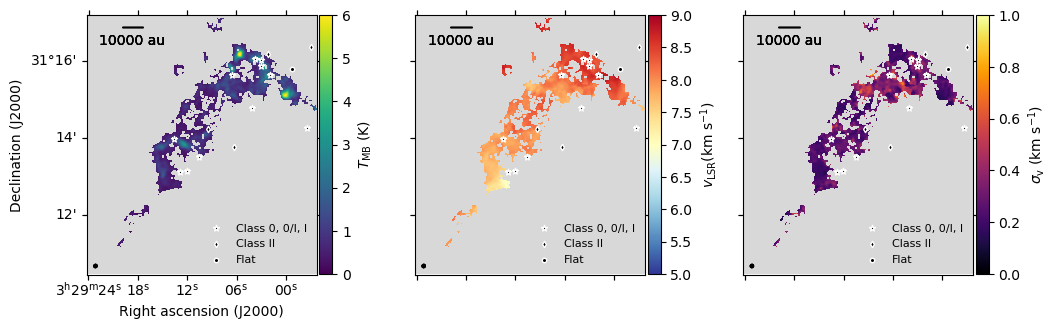

In [36]:
# We now know which clusters we can plot together in velocity:
# Clusters 0, 1, 3 and 4

clusters_red_list_HC3N = [cluster0_HC3N, cluster1_HC3N, cluster3_HC3N, cluster4_HC3N]

rangemin = [0, 5, 0]
rangemax = [6, 9, 1]

cmaplist = ['viridis', 'RdYlBu_r','inferno']
labels = [r'$T_{\mathrm{MB}}$ (K)', r'$v_{\mathrm{LSR}}$(km s$^{-1}$)', r'$\sigma_{\mathrm{v}}$ (km s$^{-1}$)']

fig, axes = plt.subplots(1, 3, figsize=(12,6), subplot_kw={'projection': wcs})
for k, cluster in enumerate(clusters_red_list_HC3N):
    for i in range(3):
        cmap = cm.get_cmap(cmaplist[i]).copy()
        if not k: cmap.set_bad('0.85')
        else: cmap.set_bad('0.85', alpha=0)
        sc1 = axes[i].imshow(cluster[i], cmap = cmap, vmin=rangemin[i], vmax=rangemax[i])
        lon = axes[i].coords[0]
        lat = axes[i].coords[1]
        if i:
            lon.set_ticklabel_visible(False)
            lat.set_ticklabel_visible(False)
            lon.set_axislabel('')
            lat.set_axislabel('')
        else:
            lon.set_axislabel('Right ascension (J2000)')
            lat.set_axislabel('Declination (J2000)')
        if not k:
            fig.colorbar(sc1, ax=axes[i], label=labels[i], shrink=0.56, pad=0.01)
            
            for j in catalog_protostars.index.values:
                if catalog_protostars.loc[j, 'Class'] == 'I' or catalog_protostars.loc[j, 'Class'] == '0' or catalog_protostars.loc[j, 'Class'] == '0/I':
                    class0dot = axes[i].scatter(catalog_protostars.loc[j, 'RAJ2000'], catalog_protostars.loc[j, 'DEJ2000'], 
                               transform=axes[i].get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=20, zorder=100)
                elif catalog_protostars.loc[j, 'Class'] == 'II' or catalog_protostars.loc[j, 'Class'] == 'III':
                    classIIdot = axes[i].scatter(catalog_protostars.loc[j, 'RAJ2000'], catalog_protostars.loc[j, 'DEJ2000'], 
                               transform=axes[i].get_transform('world'), marker='d', facecolor='k', edgecolor='w', s=10, zorder=100)
                elif catalog_protostars.loc[j, 'Class'] == 'Flat':
                    classflatdot = axes[i].scatter(catalog_protostars.loc[j, 'RAJ2000'], catalog_protostars.loc[j, 'DEJ2000'], 
                               transform=axes[i].get_transform('world'), marker='o', facecolor='k', edgecolor='w', s=10, zorder=100)
                else: continue
            axes[i].legend([class0dot, classIIdot, classflatdot], ['Class 0, 0/I, I', 'Class II', 'Flat'], frameon=False, loc=4,fontsize=8)

        add_beam(axes[i], major=bmaj, minor=bmin, angle=bpa, color='k', pad=0.1)

        add_scalebar(axes[i], scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))
fig.savefig('figures/HC3N_cluster0_1_3_4_props.pdf', bbox_inches='tight', dpi=300)

/tmp/ipykernel_30919/3865417587.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmaplist[i]).copy()


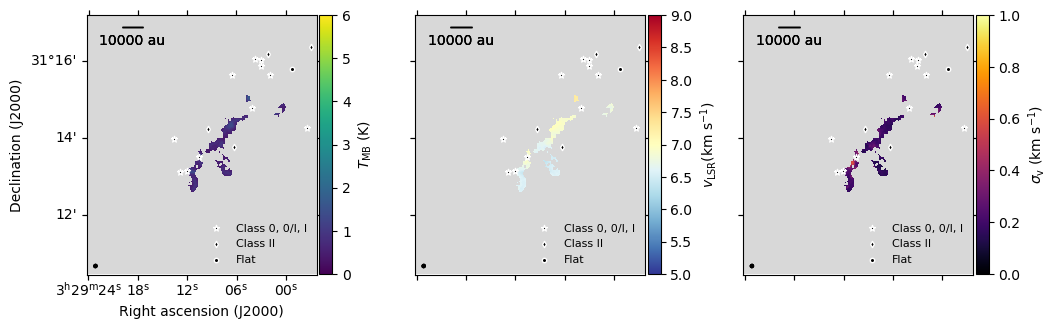

In [37]:
# We now know which clusters we can plot together in velocity:
# Clusters 5, 6 and 7

clusters_blue_list_HC3N = [cluster5_HC3N, cluster6_HC3N, cluster7_HC3N]

rangemin = [0, 5, 0]
rangemax = [6, 9, 1]

cmaplist = ['viridis', 'RdYlBu_r','inferno']
labels = [r'$T_{\mathrm{MB}}$ (K)', r'$v_{\mathrm{LSR}}$(km s$^{-1}$)', r'$\sigma_{\mathrm{v}}$ (km s$^{-1}$)']

fig, axes = plt.subplots(1, 3, figsize=(12,6), subplot_kw={'projection': wcs})
for k, cluster in enumerate(clusters_blue_list_HC3N):
    for i in range(3):
        cmap = cm.get_cmap(cmaplist[i]).copy()
        if not k: cmap.set_bad('0.85')
        else: cmap.set_bad('0.85', alpha=0)
        sc1 = axes[i].imshow(cluster[i], cmap = cmap, vmin=rangemin[i], vmax=rangemax[i])
        lon = axes[i].coords[0]
        lat = axes[i].coords[1]
        if i:
            lon.set_ticklabel_visible(False)
            lat.set_ticklabel_visible(False)
            lon.set_axislabel('')
            lat.set_axislabel('')
        else:
            lon.set_axislabel('Right ascension (J2000)')
            lat.set_axislabel('Declination (J2000)')
        if not k:
            fig.colorbar(sc1, ax=axes[i], label=labels[i], shrink=0.56, pad=0.01)
            
            for j in catalog_protostars.index.values:
                if catalog_protostars.loc[j, 'Class'] == 'I' or catalog_protostars.loc[j, 'Class'] == '0' or catalog_protostars.loc[j, 'Class'] == '0/I':
                    class0dot = axes[i].scatter(catalog_protostars.loc[j, 'RAJ2000'], catalog_protostars.loc[j, 'DEJ2000'], 
                               transform=axes[i].get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=20, zorder=100)
                elif catalog_protostars.loc[j, 'Class'] == 'II' or catalog_protostars.loc[j, 'Class'] == 'III':
                    classIIdot = axes[i].scatter(catalog_protostars.loc[j, 'RAJ2000'], catalog_protostars.loc[j, 'DEJ2000'], 
                               transform=axes[i].get_transform('world'), marker='d', facecolor='k', edgecolor='w', s=10, zorder=100)
                elif catalog_protostars.loc[j, 'Class'] == 'Flat':
                    classflatdot = axes[i].scatter(catalog_protostars.loc[j, 'RAJ2000'], catalog_protostars.loc[j, 'DEJ2000'], 
                               transform=axes[i].get_transform('world'), marker='o', facecolor='k', edgecolor='w', s=10, zorder=100)
                else: continue
            axes[i].legend([class0dot, classIIdot, classflatdot], ['Class 0, 0/I, I', 'Class II', 'Flat'], frameon=False, loc=4,fontsize=8)

        add_beam(axes[i], major=bmaj, minor=bmin, angle=bpa, color='k', pad=0.1)

        add_scalebar(axes[i], scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))
fig.savefig('figures/HC3N_cluster5_6_7_props.pdf', bbox_inches='tight', dpi=300)

/tmp/ipykernel_30919/1062984294.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdYlBu_r').copy()


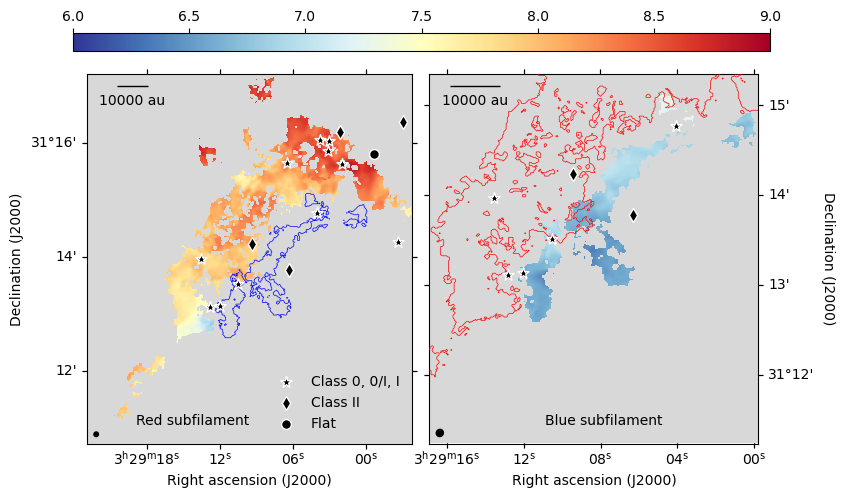

In [129]:
# Only velocity of both sub-filaments
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10,6), subplot_kw={'projection': wcs_HC3N})
fig.subplots_adjust(wspace=-0.2)
vmin = 6
vmax = 9
cmap = cm.get_cmap('RdYlBu_r').copy()
cmap.set_bad('0.85')
map_blue = np.nansum(np.array(clusters_blue_list_HC3N)[:, 1, :, :], axis=0)
map_blue[np.where(map_blue<1e-2)] = np.nan
mask_blue = np.where(~np.isnan(map_blue), 1, 0)
map_red = np.nansum(np.array(clusters_red_list_HC3N)[:, 1, :, :], axis=0)
map_red[np.where(map_red<1e-2)] = np.nan
mask_red = np.where(~np.isnan(map_red), 1, 0)

sc1 = ax1.imshow(map_red, cmap = cmap, vmin=vmin, vmax=vmax)
lon = ax1.coords[0]
lat = ax1.coords[1]
ax1.contour(mask_blue, levels=[0.5], colors='b', linewidths=0.5)
add_beam(ax1, major=bmaj, minor=bmin, angle=bpa, color='k', pad=0.1)
add_scalebar(ax1, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')

for i in catalog_protostars.index.values:
    if catalog_protostars.loc[i, 'Class'] == 'I' or catalog_protostars.loc[i, 'Class'] == '0' or catalog_protostars.loc[i, 'Class'] == '0/I':
        class0dot = ax1.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax1.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=70, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'II' or catalog_protostars.loc[i, 'Class'] == 'III':
        classIIdot = ax1.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax1.get_transform('world'), marker='d', facecolor='k', edgecolor='w', s=50, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'Flat':
        classflatdot = ax1.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax1.get_transform('world'), marker='o', facecolor='k', edgecolor='w', s=50, zorder=100)
    else: continue
ax1.legend([class0dot, classIIdot, classflatdot], ['Class 0, 0/I, I', 'Class II', 'Flat'], frameon=False, loc=4)
ax1.set_xlim([20, np.shape(map_red)[1]])
ax1.set_ylim([20, np.shape(map_red)[0]])
ax1.set_facecolor('0.85')

sc2 = ax2.imshow(map_blue, cmap = cmap, vmin=vmin, vmax=vmax)
lon = ax2.coords[0]
lat = ax2.coords[1]
ax2.tick_params(axis='y', which='both', labelleft=False, labelright=True)
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')
lat.set_axislabel_position('r')
ax2.contour(mask_red, levels=[0.5], colors='r', linewidths=0.5)
add_beam(ax2, major=bmaj, minor=bmin, angle=bpa, color='k', pad=0.1)
add_scalebar(ax2, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))
ax2.set_xlim([120, 405])
ax2.set_ylim([60, 380])
for i in catalog_protostars.index.values:
    if catalog_protostars.loc[i, 'Class'] == 'I' or catalog_protostars.loc[i, 'Class'] == '0' or catalog_protostars.loc[i, 'Class'] == '0/I':
        class0dot = ax2.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax2.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=70, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'II' or catalog_protostars.loc[i, 'Class'] == 'III':
        classIIdot = ax2.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax2.get_transform('world'), marker='d', facecolor='k', edgecolor='w', s=50, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'Flat':
        classflatdot = ax2.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax2.get_transform('world'), marker='o', facecolor='k', edgecolor='w', s=50, zorder=100)
    else: continue

fig.colorbar(sc1, ax=[ax1, ax2], location='top', shrink=0.9, aspect=40)
ax1.annotate('Red subfilament', (0.15, 0.05), xycoords='axes fraction')
ax2.annotate('Blue subfilament', (0.35, 0.05), xycoords='axes fraction')


# only if we want to add magnetic fields
# for ra_i, dec_i, dra_i, ddec_i in zip(ra_pol, dec_pol, dra_pol, ddec_pol):
#     position_i = SkyCoord(ra_i * u.deg, dec_i * u.deg, frame='fk5')
#     # two pieces of coordinates
#     position_vector_1 = position_i.spherical_offsets_by(dra_i * u.arcsec, ddec_i * u.arcsec)
#     position_vector_2 = position_i.spherical_offsets_by(-dra_i * u.arcsec, -ddec_i * u.arcsec)
#     ax1.plot([position_vector_1.ra.deg, position_vector_2.ra.deg], 
#             [position_vector_1.dec.deg, position_vector_2.dec.deg], zorder=10, 
#             color='black', transform=ax1.get_transform('world'), lw=2)
#     ax2.plot([position_vector_1.ra.deg, position_vector_2.ra.deg], 
#             [position_vector_1.dec.deg, position_vector_2.dec.deg], zorder=10, 
#             color='black', transform=ax2.get_transform('world'), lw=2)
#     ax1.plot([position_vector_1.ra.deg, position_vector_2.ra.deg], 
#             [position_vector_1.dec.deg, position_vector_2.dec.deg], zorder=11,
#             color='white', transform=ax1.get_transform('world'), lw=1)
#     ax2.plot([position_vector_1.ra.deg, position_vector_2.ra.deg], 
#             [position_vector_1.dec.deg, position_vector_2.dec.deg], zorder=11,
#             color='white', transform=ax2.get_transform('world'), lw=1)


fig.savefig('figures/HC3N_clusters_subfilaments_vel.pdf', bbox_inches='tight', dpi=300)

In [ ]:
# just in case I am interested in the uncertainties of the mle
fig, ax = plt.subplots(1, 1, figsize=(4,4), subplot_kw={'projection': wcs})

for i, cluster in enumerate(clusters_blue_list_HC3N):
    cmap = cm.get_cmap('inferno').copy()
    if not i: cmap.set_bad('0.85')
    else: cmap.set_bad('0.85', alpha=0)
    sc1 = ax.imshow(cluster[4], cmap =cmap, vmax=0.06)
    if not i: fig.colorbar(sc1, ax=ax)

lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')
add_beam(ax, major=bmaj, minor=bmin, angle=bpa, color='k', pad=0.1)
add_scalebar(ax, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))

fig.savefig('figures/HC3N_clusters_blue_HDBSCAN_HC3N_vel_unc.pdf', bbox_inches='tight', dpi=100)

In [ ]:
# just in case I am interested in the uncertainties of the mle
fig, ax = plt.subplots(1, 1, figsize=(4,4), subplot_kw={'projection': wcs})

for i, cluster in enumerate(clusters_red_list_HC3N):
    cmap = cm.get_cmap('inferno').copy()
    if not i: cmap.set_bad('0.85')
    else: cmap.set_bad('0.85', alpha=0)
    sc1 = ax.imshow(cluster[4], cmap =cmap, vmax=0.06)
    if not i: fig.colorbar(sc1, ax=ax)

lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')
add_beam(ax, major=bmaj, minor=bmin, angle=bpa, color='k', pad=0.1)
add_scalebar(ax, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))

fig.savefig('figures/HC3N_clusters_red_HDBSCAN_HC3N_vel_unc.pdf', bbox_inches='tight', dpi=100)

### Difference between the groups' velocities

In [184]:
diff_blue_clumps_vel_file = 'clustering/diff_HC3N_w_N2Hp_clump_blue_vel.fits'
diff_red_clumps_vel_file = 'clustering/diff_HC3N_w_N2Hp_clump_red_vel.fits'
diff_all_vel_file = 'clustering/NGC1333-SE_HC3N-N2Hp_mindiff.fits'

diffkde_blue_file = 'clustering/diff_HC3N_w_N2Hp_blue_kde2d.npy'
diffkde_red_file = 'clustering/diff_HC3N_w_N2Hp_red_kde2d.npy'

/tmp/ipykernel_356/3762569567.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdYlBu_r').copy()


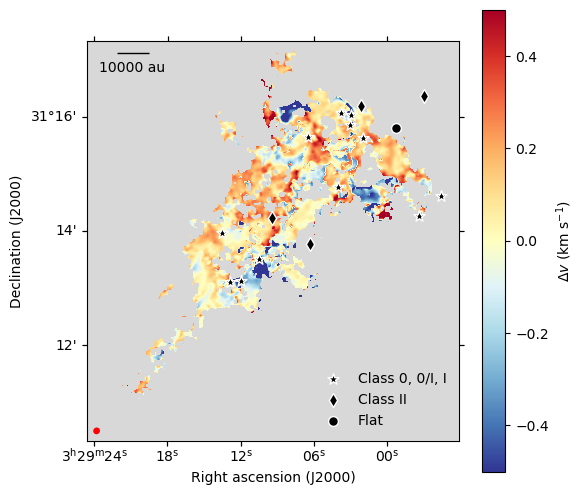

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), subplot_kw={'projection': wcsn2hp})
cmap = cm.get_cmap('RdYlBu_r').copy()
cmap.set_bad('0.85')
diff_all_clumps = fits.getdata(diff_all_vel_file)

sc1 = ax.imshow(diff_all_clumps,  cmap=cmap, vmin=-0.5, vmax=0.5)
cax = plt.colorbar(sc1, ax=ax, label=r'$\Delta v$ (km s$^{-1}$)')
# ax.contour(ncompflag, levels=[0.5], colors='w', linewidths=0.5)

lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')

add_beam(ax, major=bmajn2hp, minor=bminn2hp, angle=bpan2hp, color='r', pad=0.1)


for i in catalog_protostars.index.values:
    if catalog_protostars.loc[i, 'Class'] == 'I' or catalog_protostars.loc[i, 'Class'] == '0' or catalog_protostars.loc[i, 'Class'] == '0/I':
        class0dot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=70, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'II' or catalog_protostars.loc[i, 'Class'] == 'III':
        classIIdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='d', facecolor='k', edgecolor='w', s=50, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'Flat':
        classflatdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='o', facecolor='k', edgecolor='w', s=50, zorder=100)
    else: continue
ax.legend([class0dot, classIIdot, classflatdot], ['Class 0, 0/I, I', 'Class II', 'Flat'], frameon=False, loc=4)
ax.set_facecolor('0.85')
add_scalebar(ax, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))

fig.savefig('figures/diff_clusters_all.pdf', bbox_inches='tight', dpi=300)

/tmp/ipykernel_30919/1815066751.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdYlBu_r').copy()


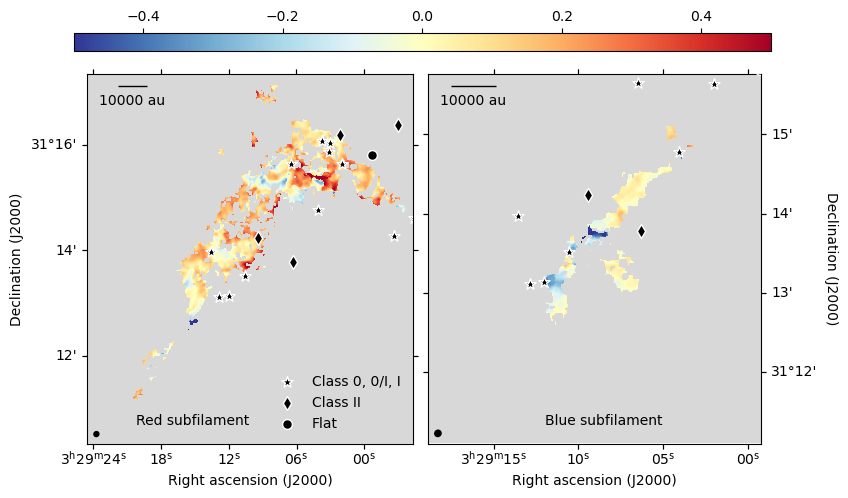

In [154]:
# Velocity diff for both in one plot
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10,6), subplot_kw={'projection': wcsn2hp})
fig.subplots_adjust(wspace=-0.2)
cmap = cm.get_cmap('RdYlBu_r').copy()
cmap.set_bad('0.85')
diff_blue_clumps = fits.getdata(diff_blue_clumps_vel_file)
diff_red_clumps = fits.getdata(diff_red_clumps_vel_file)

sc1 = ax1.imshow(diff_red_clumps[0],  cmap=cmap, vmin=-0.5, vmax=0.5)
lon = ax1.coords[0]
lat = ax1.coords[1]
add_beam(ax1, major=bmajn2hp, minor=bminn2hp, angle=bpan2hp, color='k', pad=0.1)
add_scalebar(ax1, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')

for i in catalog_protostars.index.values:
    if catalog_protostars.loc[i, 'Class'] == 'I' or catalog_protostars.loc[i, 'Class'] == '0' or catalog_protostars.loc[i, 'Class'] == '0/I':
        class0dot = ax1.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax1.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=70, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'II' or catalog_protostars.loc[i, 'Class'] == 'III':
        classIIdot = ax1.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax1.get_transform('world'), marker='d', facecolor='k', edgecolor='w', s=50, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'Flat':
        classflatdot = ax1.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax1.get_transform('world'), marker='o', facecolor='k', edgecolor='w', s=50, zorder=100)
    else: continue
ax1.legend([class0dot, classIIdot, classflatdot], ['Class 0, 0/I, I', 'Class II', 'Flat'], frameon=False, loc=4)
ax1.set_xlim([0, np.shape(diff_red_clumps[0])[1]])
ax1.set_ylim([0, np.shape(diff_red_clumps[0])[0]])
ax1.set_facecolor('0.85')

sc2 = ax2.imshow(diff_blue_clumps[0],  cmap=cmap, vmin=-0.5, vmax=0.5)
lon = ax2.coords[0]
lat = ax2.coords[1]
ax2.tick_params(axis='y', which='both', labelleft=False, labelright=True)
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')
lat.set_axislabel_position('r')
add_beam(ax2, major=bmaj, minor=bmin, angle=bpa, color='k', pad=0.1)
add_scalebar(ax2, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))
ax2.set_xlim([80, np.shape(diff_blue_clumps[0])[1]-50])
ax2.set_ylim([50, np.shape(diff_blue_clumps[0])[1]-50])
for i in catalog_protostars.index.values:
    if catalog_protostars.loc[i, 'Class'] == 'I' or catalog_protostars.loc[i, 'Class'] == '0' or catalog_protostars.loc[i, 'Class'] == '0/I':
        class0dot = ax2.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax2.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=70, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'II' or catalog_protostars.loc[i, 'Class'] == 'III':
        classIIdot = ax2.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax2.get_transform('world'), marker='d', facecolor='k', edgecolor='w', s=50, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'Flat':
        classflatdot = ax2.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax2.get_transform('world'), marker='o', facecolor='k', edgecolor='w', s=50, zorder=100)
    else: continue

fig.colorbar(sc1, ax=[ax1, ax2], location='top', shrink=0.9, aspect=40)
ax1.annotate('Red subfilament', (0.15, 0.05), xycoords='axes fraction')
ax2.annotate('Blue subfilament', (0.35, 0.05), xycoords='axes fraction')


fig.savefig('figures/diff_clusters_subfilaments.pdf', bbox_inches='tight', dpi=300)

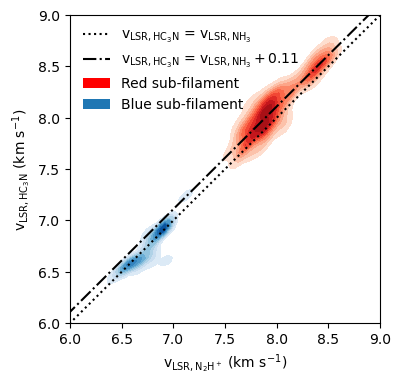

In [187]:
# p_range = np.array([0.15865 * 100, 50., 0.84135 * 100]) # one sigma
xmin = 6
xmax = 9.5
    # y is v_LSR of 2Hp
ymin = 6
ymax = 9.5
datasave = np.load(diffkde_blue_file)
xx, yy, zz_blue = datasave
datasave2 = np.load(diffkde_red_file)
xx, yy, zz_red = datasave2

def shifted_line(velx, shift):
    return velx + shift

linesample = np.linspace(5.5,9.4, 10)
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.contourf(xx, yy, zz_blue, cmap='Blues', levels=np.arange(0.1, 1.2, 0.1), vmin=0., vmax=1.1)
ax.contourf(xx, yy, zz_red, cmap='Reds', levels=np.arange(0.1, 1.2, 0.1), vmin=0., vmax=1.1)
ax.set_ylabel(r'v$_{\mathrm{LSR}, \mathrm{HC}_3\mathrm{N}}$ (km s$^{-1}$)')
ax.set_xlabel(r'v$_{\mathrm{LSR}, \mathrm{N}_2\mathrm{H}^+}$ (km s$^{-1}$)')
ax.plot(linesample, linesample, 'k:', label='v$_{\mathrm{LSR}, \mathrm{HC}_3\mathrm{N}}$ = v$_{\mathrm{LSR}, \mathrm{NH}_3}$')
ax.plot(linesample, shifted_line(linesample, 0.11), color='k', linestyle='dashdot', label='v$_{\mathrm{LSR}, \mathrm{HC}_3\mathrm{N}}$ = v$_{\mathrm{LSR}, \mathrm{NH}_3} + 0.11$')
# ax.annotate('\n HC$_3$N v/s NH$_{3}$ v$_{\mathrm{LSR}}$', (0.1, 0.9), xycoords='axes fraction', size=12)
ax.set_xlim([6,9])
ax.set_ylim([6,9])
handles, labels = ax.get_legend_handles_labels()

proxy = [handles[0], handles[1], plt.Rectangle((0,0),1,1,fc='red') , plt.Rectangle((0,0),1,1,fc='C0')]
ax.legend(proxy, [labels[0], labels[1], 'Red sub-filament', 'Blue sub-filament'], loc=0, frameon=False, fontsize=10)

# $\mathrm{V}_{LSR, \mathrm{HC}_3\mathrm{N}} - \mathrm{V}_{LSR, \mathrm{NH}_3}$
fig.savefig('figures/KDE_vlsr_groups_diff.pdf', bbox_inches='tight')

## Velocity gradient results

In [9]:
velgradient_base_file = 'analysis/vel_grad_{0}_{1}_{2}.fits' # quantity, molecule, cluster number

velxfiles_HC3N_blue = [velgradient_base_file.format('x', 'HC3N', cn) for cn in [5,6,7]]
velyfiles_HC3N_blue = [velgradient_base_file.format('y', 'HC3N', cn) for cn in [5,6,7]]
velabsfiles_HC3N_blue = [velgradient_base_file.format('magnitude', 'HC3N', cn) for cn in [5,6,7]]

velx_HC3N_blue = [fits.getdata(filename) for filename in velxfiles_HC3N_blue]
vely_HC3N_blue = [fits.getdata(filename) for filename in velyfiles_HC3N_blue]
velabs_HC3N_blue = [fits.getdata(filename) for filename in velabsfiles_HC3N_blue]

velxfiles_HC3N_red = [velgradient_base_file.format('x', 'HC3N', cn) for cn in [0,1,3,4]]
velyfiles_HC3N_red = [velgradient_base_file.format('y', 'HC3N', cn) for cn in [0,1,3,4]]
velabsfiles_HC3N_red = [velgradient_base_file.format('magnitude', 'HC3N', cn) for cn in [0,1,3,4]]

velx_HC3N_red = [fits.getdata(filename) for filename in velxfiles_HC3N_red]
vely_HC3N_red = [fits.getdata(filename) for filename in velyfiles_HC3N_red]
velabs_HC3N_red = [fits.getdata(filename) for filename in velabsfiles_HC3N_red]

clusters_HC3N_blue_list = [cluster5_HC3N[1], cluster6_HC3N[1], cluster7_HC3N[1]]
clusters_HC3N_red_list = [cluster0_HC3N[1], cluster1_HC3N[1], cluster3_HC3N[1], cluster4_HC3N[1]] # we are only interested in the velocities

velx_HC3N_blue_tot = np.nansum(velx_HC3N_blue, axis=0)
velx_HC3N_blue_tot[np.where(np.abs(velx_HC3N_blue_tot)<1e-2)] = np.nan
vely_HC3N_blue_tot = np.nansum(vely_HC3N_blue, axis=0)
vely_HC3N_blue_tot[np.where(np.abs(vely_HC3N_blue_tot)<1e-2)] = np.nan
velabs_HC3N_blue_tot = np.nansum(velabs_HC3N_blue, axis=0)
velabs_HC3N_blue_tot[np.where(velabs_HC3N_blue_tot<1e-2)] = np.nan
velx_HC3N_red_tot = np.nansum(velx_HC3N_red, axis=0)
velx_HC3N_red_tot[np.where(np.abs(velx_HC3N_red_tot)<1e-2)] = np.nan
vely_HC3N_red_tot = np.nansum(vely_HC3N_red, axis=0)
vely_HC3N_red_tot[np.where(np.abs(vely_HC3N_red_tot)<1e-2)] = np.nan
velabs_HC3N_red_tot = np.nansum(velabs_HC3N_red, axis=0)
velabs_HC3N_red_tot[np.where(velabs_HC3N_red_tot<1e-2)] = np.nan


/tmp/ipykernel_30919/488724401.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdYlBu_r').copy()


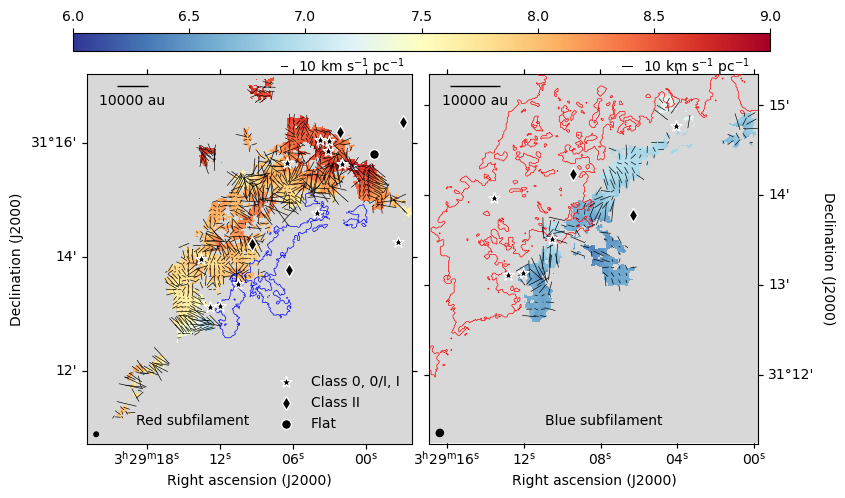

In [143]:
# Velocity of both sub-filaments with gradients
# load the sample of quivers
ns = 6
xx = np.linspace(0, np.shape(velx_HC3N_red_tot)[1], np.shape(velx_HC3N_red_tot)[1])
yy = np.linspace(0, np.shape(velx_HC3N_red_tot)[0], np.shape(velx_HC3N_red_tot)[0])
xx_red = xx[2::ns].copy()
yy_red = yy[2::ns].copy()
vectorx = velx_HC3N_red_tot[2::ns, 2::ns]
vectory = vely_HC3N_red_tot[2::ns, 2::ns]
xx2 = np.linspace(0, np.shape(velx_HC3N_blue_tot)[1], np.shape(velx_HC3N_blue_tot)[1])
yy2 = np.linspace(0, np.shape(velx_HC3N_blue_tot)[0], np.shape(velx_HC3N_blue_tot)[0])
xx_blue = xx2[2::ns].copy()
yy_blue = yy2[2::ns].copy()
vectorx2 = velx_HC3N_blue_tot[2::ns, 2::ns]
vectory2 = vely_HC3N_blue_tot[2::ns, 2::ns]

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10,6), subplot_kw={'projection': wcs_HC3N})
fig.subplots_adjust(wspace=-0.2)
vmin = 6
vmax = 9
cmap = cm.get_cmap('RdYlBu_r').copy()
cmap.set_bad('0.85')
map_blue = np.nansum(np.array(clusters_blue_list_HC3N)[:, 1, :, :], axis=0)
map_blue[np.where(map_blue<1e-2)] = np.nan
mask_blue = np.where(~np.isnan(map_blue), 1, 0)
map_red = np.nansum(np.array(clusters_red_list_HC3N)[:, 1, :, :], axis=0)
map_red[np.where(map_red<1e-2)] = np.nan
mask_red = np.where(~np.isnan(map_red), 1, 0)

sc1 = ax1.imshow(map_red, cmap = cmap, vmin=vmin, vmax=vmax)
lon = ax1.coords[0]
lat = ax1.coords[1]
ax1.contour(mask_blue, levels=[0.5], colors='b', linewidths=0.5)
add_beam(ax1, major=bmaj, minor=bmin, angle=bpa, color='k', pad=0.1)
add_scalebar(ax1, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')
qui = ax1.quiver(xx_red, yy_red, vectorx, vectory, scale=1, scale_units='y', pivot='mid', width=0.002, color='k', zorder=100, headwidth=0, headlength=0, headaxislength=0)
ax1.quiverkey(qui, X=0.62, Y=1.02, U=10,label=r'10 km s$^{-1}$ pc$^{-1}$', labelpos='E', coordinates='axes', labelcolor='k')

for i in catalog_protostars.index.values:
    if catalog_protostars.loc[i, 'Class'] == 'I' or catalog_protostars.loc[i, 'Class'] == '0' or catalog_protostars.loc[i, 'Class'] == '0/I':
        class0dot = ax1.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax1.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=70, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'II' or catalog_protostars.loc[i, 'Class'] == 'III':
        classIIdot = ax1.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax1.get_transform('world'), marker='d', facecolor='k', edgecolor='w', s=50, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'Flat':
        classflatdot = ax1.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax1.get_transform('world'), marker='o', facecolor='k', edgecolor='w', s=50, zorder=100)
    else: continue
ax1.legend([class0dot, classIIdot, classflatdot], ['Class 0, 0/I, I', 'Class II', 'Flat'], frameon=False, loc=4)
ax1.set_xlim([20, np.shape(map_red)[1]])
ax1.set_ylim([20, np.shape(map_red)[0]])
ax1.set_facecolor('0.85')

sc2 = ax2.imshow(map_blue, cmap = cmap, vmin=vmin, vmax=vmax)
lon = ax2.coords[0]
lat = ax2.coords[1]
ax2.tick_params(axis='y', which='both', labelleft=False, labelright=True)
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')
lat.set_axislabel_position('r')
ax2.contour(mask_red, levels=[0.5], colors='r', linewidths=0.5)
add_beam(ax2, major=bmaj, minor=bmin, angle=bpa, color='k', pad=0.1)
add_scalebar(ax2, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))
ax2.set_xlim([120, 405])
ax2.set_ylim([60, 380])
qui = ax2.quiver(xx_blue, yy_blue, vectorx2, vectory2, scale=1, scale_units='y', pivot='mid', width=0.002, color='k', zorder=100, headwidth=0, headlength=0, headaxislength=0)
ax2.quiverkey(qui, X=0.62, Y=1.02, U=10,label=r'10 km s$^{-1}$ pc$^{-1}$', labelpos='E', coordinates='axes', labelcolor='k')

for i in catalog_protostars.index.values:
    if catalog_protostars.loc[i, 'Class'] == 'I' or catalog_protostars.loc[i, 'Class'] == '0' or catalog_protostars.loc[i, 'Class'] == '0/I':
        class0dot = ax2.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax2.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=70, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'II' or catalog_protostars.loc[i, 'Class'] == 'III':
        classIIdot = ax2.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax2.get_transform('world'), marker='d', facecolor='k', edgecolor='w', s=50, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'Flat':
        classflatdot = ax2.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax2.get_transform('world'), marker='o', facecolor='k', edgecolor='w', s=50, zorder=100)
    else: continue

fig.colorbar(sc1, ax=[ax1, ax2], location='top', shrink=0.9, aspect=40)
ax1.annotate('Red subfilament', (0.15, 0.05), xycoords='axes fraction')
ax2.annotate('Blue subfilament', (0.35, 0.05), xycoords='axes fraction')


# only if we want to add magnetic fields
# for ra_i, dec_i, dra_i, ddec_i in zip(ra_pol, dec_pol, dra_pol, ddec_pol):
#     position_i = SkyCoord(ra_i * u.deg, dec_i * u.deg, frame='fk5')
#     # two pieces of coordinates
#     position_vector_1 = position_i.spherical_offsets_by(dra_i * u.arcsec, ddec_i * u.arcsec)
#     position_vector_2 = position_i.spherical_offsets_by(-dra_i * u.arcsec, -ddec_i * u.arcsec)
#     ax1.plot([position_vector_1.ra.deg, position_vector_2.ra.deg], 
#             [position_vector_1.dec.deg, position_vector_2.dec.deg], zorder=10, 
#             color='black', transform=ax1.get_transform('world'), lw=2)
#     ax2.plot([position_vector_1.ra.deg, position_vector_2.ra.deg], 
#             [position_vector_1.dec.deg, position_vector_2.dec.deg], zorder=10, 
#             color='black', transform=ax2.get_transform('world'), lw=2)
#     ax1.plot([position_vector_1.ra.deg, position_vector_2.ra.deg], 
#             [position_vector_1.dec.deg, position_vector_2.dec.deg], zorder=11,
#             color='white', transform=ax1.get_transform('world'), lw=1)
#     ax2.plot([position_vector_1.ra.deg, position_vector_2.ra.deg], 
#             [position_vector_1.dec.deg, position_vector_2.dec.deg], zorder=11,
#             color='white', transform=ax2.get_transform('world'), lw=1)


fig.savefig('figures/HC3N_clusters_subfilaments_vel_wgradients.pdf', bbox_inches='tight', dpi=300)

/tmp/ipykernel_356/2079840997.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdYlBu_r').copy()


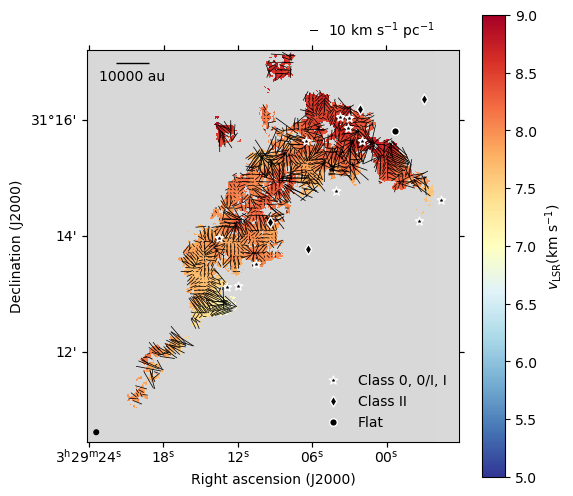

In [42]:
# gradients vs velocity in the red components of HC3N
fig, ax = plt.subplots(1, 1, figsize=(6,6), subplot_kw={'projection': wcs})
vmin = 5
vmax = 9

ns = 5
xx = np.linspace(0, np.shape(velx_HC3N_red[0])[1], np.shape(velx_HC3N_red[0])[1])
yy = np.linspace(0, np.shape(velx_HC3N_red[0])[0], np.shape(velx_HC3N_red[0])[0])
xx2 = xx[2::ns].copy()
yy2 = yy[2::ns].copy()



for k, cluster in enumerate(clusters_HC3N_red_list):
    cmap = cm.get_cmap('RdYlBu_r').copy()
    if not k: cmap.set_bad('0.85')
    else: cmap.set_bad('0.85', alpha=0)

    sc1 = ax.imshow(cluster, cmap=cmap, vmin=vmin, vmax=vmax, interpolation='nearest')
    if not k: fig.colorbar(sc1, ax=ax, label=r'$v_{\mathrm{LSR}}$(km s$^{-1}$)') 
    vectorx = velx_HC3N_red[k]
    vectory = vely_HC3N_red[k]
    vectorx2 = vectorx[2::ns, 2::ns]
    vectory2 = vectory[2::ns, 2::ns]
    qui = ax.quiver(xx2, yy2, vectorx2, vectory2, scale=1, scale_units='y', pivot='mid', width=0.002, color='k', zorder=100, headwidth=0, headlength=0, headaxislength=0)
    if not k: ax.quiverkey(qui, X=0.62, Y=1.05, U=10,label=r'10 km s$^{-1}$ pc$^{-1}$', labelpos='E', coordinates='axes', labelcolor='k')

ax.set_facecolor('0.85')
add_beam(ax, major=bmaj, minor=bmin, angle=bpa, color='k', pad=0.1)
add_scalebar(ax, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')
for j in catalog_protostars.index.values:
    if catalog_protostars.loc[j, 'Class'] == 'I' or catalog_protostars.loc[j, 'Class'] == '0' or catalog_protostars.loc[j, 'Class'] == '0/I':
        class0dot = ax.scatter(catalog_protostars.loc[j, 'RAJ2000'], catalog_protostars.loc[j, 'DEJ2000'], 
                    transform=ax.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=40, zorder=100)
    elif catalog_protostars.loc[j, 'Class'] == 'II' or catalog_protostars.loc[j, 'Class'] == 'III':
        classIIdot = ax.scatter(catalog_protostars.loc[j, 'RAJ2000'], catalog_protostars.loc[j, 'DEJ2000'], 
                    transform=ax.get_transform('world'), marker='d', facecolor='k', edgecolor='w', s=30, zorder=100)
    elif catalog_protostars.loc[j, 'Class'] == 'Flat':
        classflatdot = ax.scatter(catalog_protostars.loc[j, 'RAJ2000'], catalog_protostars.loc[j, 'DEJ2000'], 
                    transform=ax.get_transform('world'), marker='o', facecolor='k', edgecolor='w', s=30, zorder=100)
    else: continue
    
ax.legend([class0dot, classIIdot, classflatdot], ['Class 0, 0/I, I', 'Class II', 'Flat'], frameon=False, loc=4,fontsize=10)
fig.savefig('figures/velocity_gradients_HC3N_red_clusters_quiver.pdf', bbox_inches='tight', dpi=300)

/tmp/ipykernel_356/3457186531.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdYlBu_r').copy()


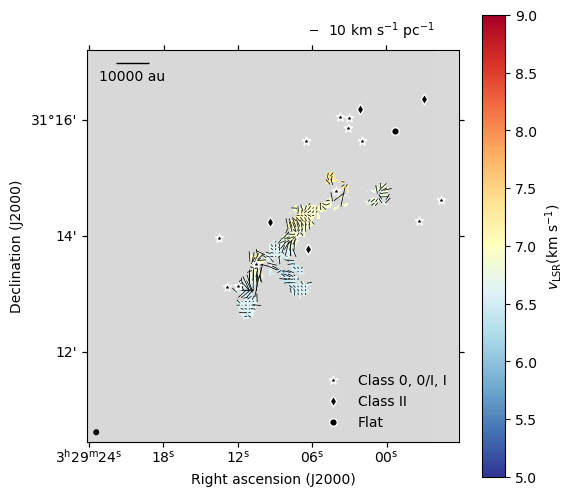

In [43]:
# gradients vs velocity in the blue components of HC3N
fig, ax = plt.subplots(1, 1, figsize=(6,6), subplot_kw={'projection': wcs})
vmin = 5
vmax = 9

ns = 5
xx = np.linspace(0, np.shape(velx_HC3N_blue[0])[1], np.shape(velx_HC3N_blue[0])[1])
yy = np.linspace(0, np.shape(velx_HC3N_blue[0])[0], np.shape(velx_HC3N_blue[0])[0])
xx2 = xx[2::ns].copy()
yy2 = yy[2::ns].copy()



for k, cluster in enumerate(clusters_HC3N_blue_list):
    cmap = cm.get_cmap('RdYlBu_r').copy()
    if not k: cmap.set_bad('0.85')
    else: cmap.set_bad('0.85', alpha=0)

    sc1 = ax.imshow(cluster, cmap=cmap, vmin=vmin, vmax=vmax, interpolation='nearest')
    if not k: fig.colorbar(sc1, ax=ax, label=r'$v_{\mathrm{LSR}}$(km s$^{-1}$)') 
    vectorx = velx_HC3N_blue[k]
    vectory = vely_HC3N_blue[k]
    vectorx2 = vectorx[2::ns, 2::ns]
    vectory2 = vectory[2::ns, 2::ns]
    qui = ax.quiver(xx2, yy2, vectorx2, vectory2, scale=1, scale_units='y', pivot='mid', width=0.002, color='k', zorder=100, headwidth=0, headlength=0, headaxislength=0)
    if not k: ax.quiverkey(qui, X=0.62, Y=1.05, U=10,label=r'10 km s$^{-1}$ pc$^{-1}$', labelpos='E', coordinates='axes', labelcolor='k')

ax.set_facecolor('0.85')
add_beam(ax, major=bmaj, minor=bmin, angle=bpa, color='k', pad=0.1)
add_scalebar(ax, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')
for j in catalog_protostars.index.values:
    if catalog_protostars.loc[j, 'Class'] == 'I' or catalog_protostars.loc[j, 'Class'] == '0' or catalog_protostars.loc[j, 'Class'] == '0/I':
        class0dot = ax.scatter(catalog_protostars.loc[j, 'RAJ2000'], catalog_protostars.loc[j, 'DEJ2000'], 
                    transform=ax.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=40, zorder=100)
    elif catalog_protostars.loc[j, 'Class'] == 'II' or catalog_protostars.loc[j, 'Class'] == 'III':
        classIIdot = ax.scatter(catalog_protostars.loc[j, 'RAJ2000'], catalog_protostars.loc[j, 'DEJ2000'], 
                    transform=ax.get_transform('world'), marker='d', facecolor='k', edgecolor='w', s=30, zorder=100)
    elif catalog_protostars.loc[j, 'Class'] == 'Flat':
        classflatdot = ax.scatter(catalog_protostars.loc[j, 'RAJ2000'], catalog_protostars.loc[j, 'DEJ2000'], 
                    transform=ax.get_transform('world'), marker='o', facecolor='k', edgecolor='w', s=30, zorder=100)
    else: continue
    
ax.legend([class0dot, classIIdot, classflatdot], ['Class 0, 0/I, I', 'Class II', 'Flat'], frameon=False, loc=4,fontsize=10)
fig.savefig('figures/velocity_gradients_HC3N_blue_clusters_quiver.pdf', bbox_inches='tight', dpi=300)

/tmp/ipykernel_30919/3129961154.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdYlBu_r').copy()


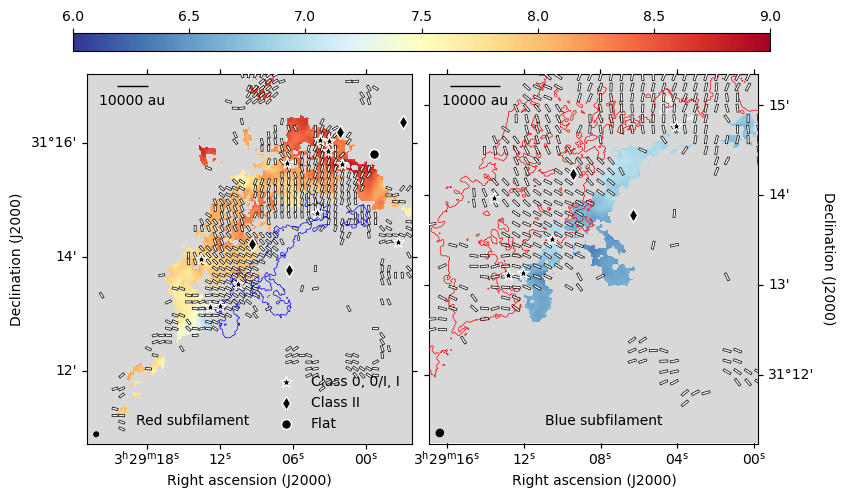

In [190]:
# velocity compared to magnetic field direction


fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10,6), subplot_kw={'projection': wcs_HC3N})
fig.subplots_adjust(wspace=-0.2)
vmin = 6
vmax = 9
cmap = cm.get_cmap('RdYlBu_r').copy()
cmap.set_bad('0.85')
map_blue = np.nansum(np.array(clusters_blue_list_HC3N)[:, 1, :, :], axis=0)
map_blue[np.where(map_blue<1e-2)] = np.nan
mask_blue = np.where(~np.isnan(map_blue), 1, 0)
map_red = np.nansum(np.array(clusters_red_list_HC3N)[:, 1, :, :], axis=0)
map_red[np.where(map_red<1e-2)] = np.nan
mask_red = np.where(~np.isnan(map_red), 1, 0)

sc1 = ax1.imshow(map_red, cmap = cmap, vmin=vmin, vmax=vmax)
lon = ax1.coords[0]
lat = ax1.coords[1]
ax1.contour(mask_blue, levels=[0.5], colors='b', linewidths=0.5)
add_beam(ax1, major=bmaj, minor=bmin, angle=bpa, color='k', pad=0.1)
add_scalebar(ax1, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')

for i in catalog_protostars.index.values:
    if catalog_protostars.loc[i, 'Class'] == 'I' or catalog_protostars.loc[i, 'Class'] == '0' or catalog_protostars.loc[i, 'Class'] == '0/I':
        class0dot = ax1.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax1.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=70, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'II' or catalog_protostars.loc[i, 'Class'] == 'III':
        classIIdot = ax1.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax1.get_transform('world'), marker='d', facecolor='k', edgecolor='w', s=50, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'Flat':
        classflatdot = ax1.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax1.get_transform('world'), marker='o', facecolor='k', edgecolor='w', s=50, zorder=100)
    else: continue
ax1.legend([class0dot, classIIdot, classflatdot], ['Class 0, 0/I, I', 'Class II', 'Flat'], frameon=False, loc=4)
ax1.set_xlim([20, np.shape(map_red)[1]])
ax1.set_ylim([20, np.shape(map_red)[0]])
ax1.set_facecolor('0.85')

sc2 = ax2.imshow(map_blue, cmap = cmap, vmin=vmin, vmax=vmax)
lon = ax2.coords[0]
lat = ax2.coords[1]
ax2.tick_params(axis='y', which='both', labelleft=False, labelright=True)
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')
lat.set_axislabel_position('r')
ax2.contour(mask_red, levels=[0.5], colors='r', linewidths=0.5)
add_beam(ax2, major=bmaj, minor=bmin, angle=bpa, color='k', pad=0.1)
add_scalebar(ax2, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))
ax2.set_xlim([120, 405])
ax2.set_ylim([60, 380])

for i in catalog_protostars.index.values:
    if catalog_protostars.loc[i, 'Class'] == 'I' or catalog_protostars.loc[i, 'Class'] == '0' or catalog_protostars.loc[i, 'Class'] == '0/I':
        class0dot = ax2.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax2.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=70, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'II' or catalog_protostars.loc[i, 'Class'] == 'III':
        classIIdot = ax2.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax2.get_transform('world'), marker='d', facecolor='k', edgecolor='w', s=50, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'Flat':
        classflatdot = ax2.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax2.get_transform('world'), marker='o', facecolor='k', edgecolor='w', s=50, zorder=100)
    else: continue

fig.colorbar(sc1, ax=[ax1, ax2], location='top', shrink=0.9, aspect=40)
ax1.annotate('Red subfilament', (0.15, 0.05), xycoords='axes fraction')
ax2.annotate('Blue subfilament', (0.35, 0.05), xycoords='axes fraction')


for ra_i, dec_i, dra_i, ddec_i in zip(ra_pol, dec_pol, dra_pol, ddec_pol):
    position_i = SkyCoord(ra_i * u.deg, dec_i * u.deg, frame='fk5')
    # two pieces of coordinates
    position_vector_1 = position_i.spherical_offsets_by(dra_i * u.arcsec, ddec_i * u.arcsec)
    position_vector_2 = position_i.spherical_offsets_by(-dra_i * u.arcsec, -ddec_i * u.arcsec)
    ax1.plot([position_vector_1.ra.deg, position_vector_2.ra.deg], 
            [position_vector_1.dec.deg, position_vector_2.dec.deg], zorder=10, 
            color='black', transform=ax1.get_transform('world'), lw=2)
    ax2.plot([position_vector_1.ra.deg, position_vector_2.ra.deg], 
            [position_vector_1.dec.deg, position_vector_2.dec.deg], zorder=10, 
            color='black', transform=ax2.get_transform('world'), lw=2)
    ax1.plot([position_vector_1.ra.deg, position_vector_2.ra.deg], 
            [position_vector_1.dec.deg, position_vector_2.dec.deg], zorder=11,
            color='white', transform=ax1.get_transform('world'), lw=1)
    ax2.plot([position_vector_1.ra.deg, position_vector_2.ra.deg], 
            [position_vector_1.dec.deg, position_vector_2.dec.deg], zorder=11,
            color='white', transform=ax2.get_transform('world'), lw=1)


fig.savefig('figures/HC3N_clusters_subfilaments_vel_wmagfields.pdf', bbox_inches='tight', dpi=300)

In [146]:
velgradient_base_N2Hp_file = 'analysis/vel_grad_{0}_{1}_{2}.fits' # quantity, molecule, cluster number

velxfiles_N2Hp_blue = [velgradient_base_N2Hp_file.format('x', 'N2Hp', cn) for cn in [1, 2, 4]]
velyfiles_N2Hp_blue = [velgradient_base_N2Hp_file.format('y', 'N2Hp', cn) for cn in [1, 2, 4]]
velabsfiles_N2Hp_blue = [velgradient_base_N2Hp_file.format('magnitude', 'N2Hp', cn) for cn in [1, 2, 4]]

velx_N2Hp_blue = [fits.getdata(filename) for filename in velxfiles_N2Hp_blue]
vely_N2Hp_blue = [fits.getdata(filename) for filename in velyfiles_N2Hp_blue]
velabs_N2Hp_blue = [fits.getdata(filename) for filename in velabsfiles_N2Hp_blue]

velxfiles_N2Hp_red = [velgradient_base_N2Hp_file.format('x', 'N2Hp', cn) for cn in [0,3]]
velyfiles_N2Hp_red = [velgradient_base_N2Hp_file.format('y', 'N2Hp', cn) for cn in [0,3]]
velabsfiles_N2Hp_red = [velgradient_base_N2Hp_file.format('magnitude', 'N2Hp', cn) for cn in [0,3]]

velx_N2Hp_red = [fits.getdata(filename) for filename in velxfiles_N2Hp_red]
vely_N2Hp_red = [fits.getdata(filename) for filename in velyfiles_N2Hp_red]
velabs_N2Hp_red = [fits.getdata(filename) for filename in velabsfiles_N2Hp_red]

clusters_N2Hp_blue_list = [cluster1_N2Hp[1], cluster2_N2Hp[1], cluster4_N2Hp[1]]
clusters_N2Hp_red_list = [cluster0_N2Hp[1], cluster3_N2Hp[1]] # we are only interested in the velocities


velx_N2Hp_blue_tot = np.nansum(velx_N2Hp_blue, axis=0)
velx_N2Hp_blue_tot[np.where(np.abs(velx_N2Hp_blue_tot)<1e-2)] = np.nan
vely_N2Hp_blue_tot = np.nansum(vely_N2Hp_blue, axis=0)
vely_N2Hp_blue_tot[np.where(np.abs(vely_N2Hp_blue_tot)<1e-2)] = np.nan
velabs_N2Hp_blue_tot = np.nansum(velabs_N2Hp_blue, axis=0)
velabs_N2Hp_blue_tot[np.where(velabs_N2Hp_blue_tot<1e-2)] = np.nan
velx_N2Hp_red_tot = np.nansum(velx_N2Hp_red, axis=0)
velx_N2Hp_red_tot[np.where(np.abs(velx_N2Hp_red_tot)<1e-2)] = np.nan
vely_N2Hp_red_tot = np.nansum(vely_N2Hp_red, axis=0)
vely_N2Hp_red_tot[np.where(np.abs(vely_N2Hp_red_tot)<1e-2)] = np.nan
velabs_N2Hp_red_tot = np.nansum(velabs_N2Hp_red, axis=0)
velabs_N2Hp_red_tot[np.where(velabs_N2Hp_red_tot<1e-2)] = np.nan


/tmp/ipykernel_30919/322051474.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdYlBu_r').copy()


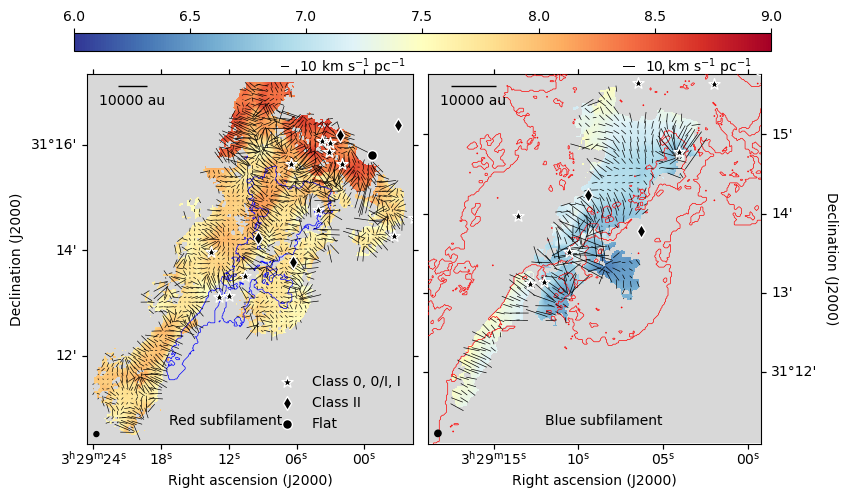

In [149]:
# velocity of both sub-filaments with gradients
# load the sample of quivers
ns = 6
xx = np.linspace(0, np.shape(velx_N2Hp_red_tot)[1], np.shape(velx_N2Hp_red_tot)[1])
yy = np.linspace(0, np.shape(velx_N2Hp_red_tot)[0], np.shape(velx_N2Hp_red_tot)[0])
xx_red = xx[2::ns].copy()
yy_red = yy[2::ns].copy()
vectorx = velx_N2Hp_red_tot[2::ns, 2::ns]
vectory = vely_N2Hp_red_tot[2::ns, 2::ns]
xx2 = np.linspace(0, np.shape(velx_N2Hp_blue_tot)[1], np.shape(velx_N2Hp_blue_tot)[1])
yy2 = np.linspace(0, np.shape(velx_N2Hp_blue_tot)[0], np.shape(velx_N2Hp_blue_tot)[0])
xx_blue = xx2[2::ns].copy()
yy_blue = yy2[2::ns].copy()
vectorx2 = velx_N2Hp_blue_tot[2::ns, 2::ns]
vectory2 = vely_N2Hp_blue_tot[2::ns, 2::ns]

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10,6), subplot_kw={'projection': wcsn2hp})
fig.subplots_adjust(wspace=-0.2)
vmin = 6
vmax = 9
cmap = cm.get_cmap('RdYlBu_r').copy()
cmap.set_bad('0.85')
map_blue = np.nansum(np.array(clusters_blue_list_N2Hp)[:, 1, :, :], axis=0)
map_blue[np.where(map_blue<1e-2)] = np.nan
mask_blue = np.where(~np.isnan(map_blue), 1, 0)
map_red = np.nansum(np.array(clusters_red_list_N2Hp)[:, 1, :, :], axis=0)
map_red[np.where(map_red<1e-2)] = np.nan
mask_red = np.where(~np.isnan(map_red), 1, 0)

sc1 = ax1.imshow(map_red, cmap = cmap, vmin=vmin, vmax=vmax)
lon = ax1.coords[0]
lat = ax1.coords[1]
ax1.contour(mask_blue, levels=[0.5], colors='b', linewidths=0.5)
add_beam(ax1, major=bmajn2hp, minor=bminn2hp, angle=bpan2hp, color='k', pad=0.1)
add_scalebar(ax1, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')
qui = ax1.quiver(xx_red, yy_red, vectorx, vectory, scale=1, scale_units='y', pivot='mid', width=0.002, color='k', zorder=100, headwidth=0, headlength=0, headaxislength=0)
ax1.quiverkey(qui, X=0.62, Y=1.02, U=10,label=r'10 km s$^{-1}$ pc$^{-1}$', labelpos='E', coordinates='axes', labelcolor='k')

for i in catalog_protostars.index.values:
    if catalog_protostars.loc[i, 'Class'] == 'I' or catalog_protostars.loc[i, 'Class'] == '0' or catalog_protostars.loc[i, 'Class'] == '0/I':
        class0dot = ax1.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax1.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=70, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'II' or catalog_protostars.loc[i, 'Class'] == 'III':
        classIIdot = ax1.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax1.get_transform('world'), marker='d', facecolor='k', edgecolor='w', s=50, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'Flat':
        classflatdot = ax1.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax1.get_transform('world'), marker='o', facecolor='k', edgecolor='w', s=50, zorder=100)
    else: continue
ax1.legend([class0dot, classIIdot, classflatdot], ['Class 0, 0/I, I', 'Class II', 'Flat'], frameon=False, loc=4)
ax1.set_xlim([0, np.shape(map_red)[1]])
ax1.set_ylim([0, np.shape(map_red)[0]])
ax1.set_facecolor('0.85')

sc2 = ax2.imshow(map_blue, cmap = cmap, vmin=vmin, vmax=vmax)
lon = ax2.coords[0]
lat = ax2.coords[1]
ax2.tick_params(axis='y', which='both', labelleft=False, labelright=True)
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')
lat.set_axislabel_position('r')
ax2.contour(mask_red, levels=[0.5], colors='r', linewidths=0.5)
add_beam(ax2, major=bmaj, minor=bmin, angle=bpa, color='k', pad=0.1)
add_scalebar(ax2, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))
ax2.set_xlim([80, np.shape(map_blue)[1]-50])
ax2.set_ylim([50, np.shape(map_blue)[1]-50])
qui = ax2.quiver(xx_blue, yy_blue, vectorx2, vectory2, scale=1, scale_units='y', pivot='mid', width=0.002, color='k', zorder=100, headwidth=0, headlength=0, headaxislength=0)
ax2.quiverkey(qui, X=0.62, Y=1.02, U=10,label=r'10 km s$^{-1}$ pc$^{-1}$', labelpos='E', coordinates='axes', labelcolor='k')
for i in catalog_protostars.index.values:
    if catalog_protostars.loc[i, 'Class'] == 'I' or catalog_protostars.loc[i, 'Class'] == '0' or catalog_protostars.loc[i, 'Class'] == '0/I':
        class0dot = ax2.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax2.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=70, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'II' or catalog_protostars.loc[i, 'Class'] == 'III':
        classIIdot = ax2.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax2.get_transform('world'), marker='d', facecolor='k', edgecolor='w', s=50, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'Flat':
        classflatdot = ax2.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax2.get_transform('world'), marker='o', facecolor='k', edgecolor='w', s=50, zorder=100)
    else: continue

fig.colorbar(sc1, ax=[ax1, ax2], location='top', shrink=0.9, aspect=40)
ax1.annotate('Red subfilament', (0.25, 0.05), xycoords='axes fraction')
ax2.annotate('Blue subfilament', (0.35, 0.05), xycoords='axes fraction')

fig.savefig('figures/N2Hp_clusters_subfilaments_vel_wgradients.pdf', bbox_inches='tight', dpi=300)

/tmp/ipykernel_356/2933844054.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdYlBu_r').copy()


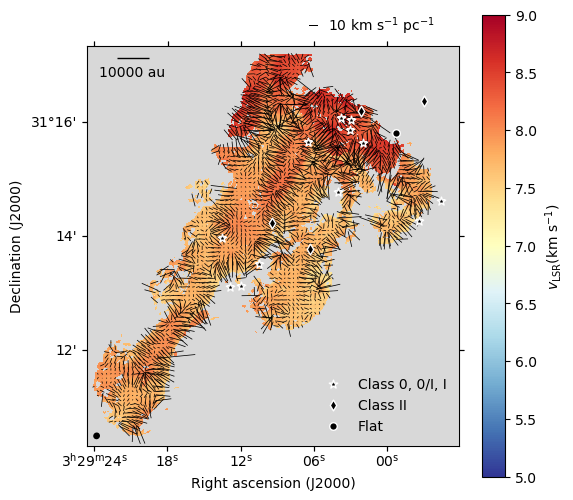

In [45]:
# gradients vs velocity in the red components of N2Hp
fig, ax = plt.subplots(1, 1, figsize=(6,6), subplot_kw={'projection': wcsn2hp})
vmin = 5
vmax = 9

ns = 5
xx = np.linspace(0, np.shape(velx_N2Hp_red[0])[1], np.shape(velx_N2Hp_red[0])[1])
yy = np.linspace(0, np.shape(velx_N2Hp_red[0])[0], np.shape(velx_N2Hp_red[0])[0])
xx2 = xx[2::ns].copy()
yy2 = yy[2::ns].copy()



for k, cluster in enumerate(clusters_N2Hp_red_list):
    cmap = cm.get_cmap('RdYlBu_r').copy()
    if not k: cmap.set_bad('0.85')
    else: cmap.set_bad('0.85', alpha=0)

    sc1 = ax.imshow(cluster, cmap=cmap, vmin=vmin, vmax=vmax, interpolation='nearest')
    if not k: fig.colorbar(sc1, ax=ax, label=r'$v_{\mathrm{LSR}}$(km s$^{-1}$)') 
    vectorx = velx_N2Hp_red[k]
    vectory = vely_N2Hp_red[k]
    vectorx2 = vectorx[2::ns, 2::ns]
    vectory2 = vectory[2::ns, 2::ns]
    qui = ax.quiver(xx2, yy2, vectorx2, vectory2, scale=1, scale_units='y', pivot='mid', width=0.002, color='k', zorder=100, headwidth=0, headlength=0, headaxislength=0)
    if not k: ax.quiverkey(qui, X=0.62, Y=1.05, U=10,label=r'10 km s$^{-1}$ pc$^{-1}$', labelpos='E', coordinates='axes', labelcolor='k')

ax.set_facecolor('0.85')
add_beam(ax, major=bmajn2hp, minor=bminn2hp, angle=bpan2hp, color='k', pad=0.1)
add_scalebar(ax, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')
for j in catalog_protostars.index.values:
    if catalog_protostars.loc[j, 'Class'] == 'I' or catalog_protostars.loc[j, 'Class'] == '0' or catalog_protostars.loc[j, 'Class'] == '0/I':
        class0dot = ax.scatter(catalog_protostars.loc[j, 'RAJ2000'], catalog_protostars.loc[j, 'DEJ2000'], 
                    transform=ax.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=40, zorder=100)
    elif catalog_protostars.loc[j, 'Class'] == 'II' or catalog_protostars.loc[j, 'Class'] == 'III':
        classIIdot = ax.scatter(catalog_protostars.loc[j, 'RAJ2000'], catalog_protostars.loc[j, 'DEJ2000'], 
                    transform=ax.get_transform('world'), marker='d', facecolor='k', edgecolor='w', s=30, zorder=100)
    elif catalog_protostars.loc[j, 'Class'] == 'Flat':
        classflatdot = ax.scatter(catalog_protostars.loc[j, 'RAJ2000'], catalog_protostars.loc[j, 'DEJ2000'], 
                    transform=ax.get_transform('world'), marker='o', facecolor='k', edgecolor='w', s=30, zorder=100)
    else: continue
    
ax.legend([class0dot, classIIdot, classflatdot], ['Class 0, 0/I, I', 'Class II', 'Flat'], frameon=False, loc=4,fontsize=10)
fig.savefig('figures/velocity_gradients_N2Hp_red_clusters_quiver.pdf', bbox_inches='tight', dpi=300)

/tmp/ipykernel_356/2764926415.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdYlBu_r').copy()


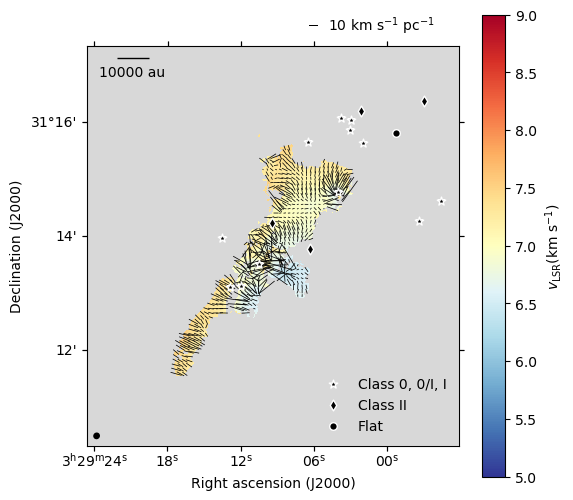

In [46]:
# gradients vs velocity in the bluecomponents of N2Hp
fig, ax = plt.subplots(1, 1, figsize=(6,6), subplot_kw={'projection': wcsn2hp})
vmin = 5
vmax = 9

ns = 5
xx = np.linspace(0, np.shape(velx_N2Hp_blue[0])[1], np.shape(velx_N2Hp_blue[0])[1])
yy = np.linspace(0, np.shape(velx_N2Hp_blue[0])[0], np.shape(velx_N2Hp_blue[0])[0])
xx2 = xx[2::ns].copy()
yy2 = yy[2::ns].copy()



for k, cluster in enumerate(clusters_N2Hp_blue_list):
    cmap = cm.get_cmap('RdYlBu_r').copy()
    if not k: cmap.set_bad('0.85')
    else: cmap.set_bad('0.85', alpha=0)

    sc1 = ax.imshow(cluster, cmap=cmap, vmin=vmin, vmax=vmax, interpolation='nearest')
    if not k: fig.colorbar(sc1, ax=ax, label=r'$v_{\mathrm{LSR}}$(km s$^{-1}$)') 
    vectorx = velx_N2Hp_blue[k]
    vectory = vely_N2Hp_blue[k]
    vectorx2 = vectorx[2::ns, 2::ns]
    vectory2 = vectory[2::ns, 2::ns]
    qui = ax.quiver(xx2, yy2, vectorx2, vectory2, scale=1, scale_units='y', pivot='mid', width=0.002, color='k', zorder=100, headwidth=0, headlength=0, headaxislength=0)
    if not k: ax.quiverkey(qui, X=0.62, Y=1.05, U=10,label=r'10 km s$^{-1}$ pc$^{-1}$', labelpos='E', coordinates='axes', labelcolor='k')

ax.set_facecolor('0.85')
add_beam(ax, major=bmajn2hp, minor=bminn2hp, angle=bpan2hp, color='k', pad=0.1)
add_scalebar(ax, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')
for j in catalog_protostars.index.values:
    if catalog_protostars.loc[j, 'Class'] == 'I' or catalog_protostars.loc[j, 'Class'] == '0' or catalog_protostars.loc[j, 'Class'] == '0/I':
        class0dot = ax.scatter(catalog_protostars.loc[j, 'RAJ2000'], catalog_protostars.loc[j, 'DEJ2000'], 
                    transform=ax.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=40, zorder=100)
    elif catalog_protostars.loc[j, 'Class'] == 'II' or catalog_protostars.loc[j, 'Class'] == 'III':
        classIIdot = ax.scatter(catalog_protostars.loc[j, 'RAJ2000'], catalog_protostars.loc[j, 'DEJ2000'], 
                    transform=ax.get_transform('world'), marker='d', facecolor='k', edgecolor='w', s=30, zorder=100)
    elif catalog_protostars.loc[j, 'Class'] == 'Flat':
        classflatdot = ax.scatter(catalog_protostars.loc[j, 'RAJ2000'], catalog_protostars.loc[j, 'DEJ2000'], 
                    transform=ax.get_transform('world'), marker='o', facecolor='k', edgecolor='w', s=30, zorder=100)
    else: continue
    
ax.legend([class0dot, classIIdot, classflatdot], ['Class 0, 0/I, I', 'Class II', 'Flat'], frameon=False, loc=4,fontsize=10)
fig.savefig('figures/velocity_gradients_N2Hp_blue_clusters_quiver.pdf', bbox_inches='tight', dpi=300)

/tmp/ipykernel_30919/3385615945.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdYlBu_r').copy()


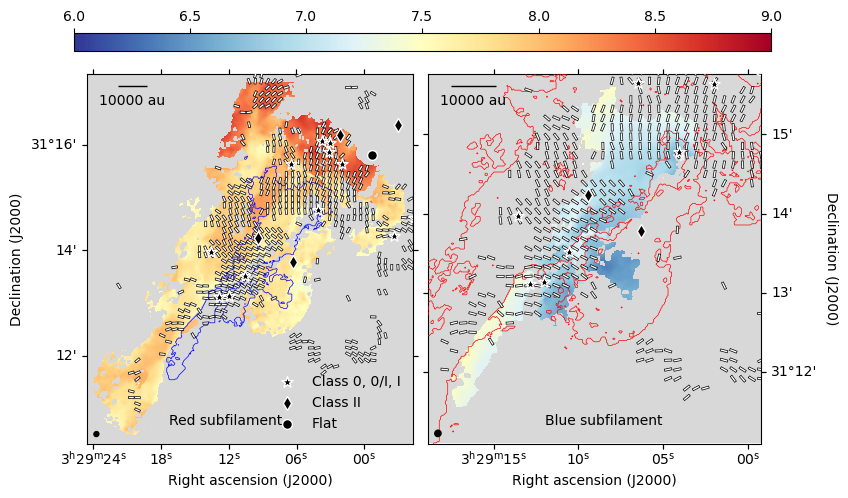

In [189]:
# velocity gradients in comparison to the magnetic field direction

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10,6), subplot_kw={'projection': wcsn2hp})
fig.subplots_adjust(wspace=-0.2)
vmin = 6
vmax = 9
cmap = cm.get_cmap('RdYlBu_r').copy()
cmap.set_bad('0.85')
map_blue = np.nansum(np.array(clusters_blue_list_N2Hp)[:, 1, :, :], axis=0)
map_blue[np.where(map_blue<1e-2)] = np.nan
mask_blue = np.where(~np.isnan(map_blue), 1, 0)
map_red = np.nansum(np.array(clusters_red_list_N2Hp)[:, 1, :, :], axis=0)
map_red[np.where(map_red<1e-2)] = np.nan
mask_red = np.where(~np.isnan(map_red), 1, 0)

sc1 = ax1.imshow(map_red, cmap = cmap, vmin=vmin, vmax=vmax)
lon = ax1.coords[0]
lat = ax1.coords[1]
ax1.contour(mask_blue, levels=[0.5], colors='b', linewidths=0.5)
add_beam(ax1, major=bmajn2hp, minor=bminn2hp, angle=bpan2hp, color='k', pad=0.1)
add_scalebar(ax1, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')

for i in catalog_protostars.index.values:
    if catalog_protostars.loc[i, 'Class'] == 'I' or catalog_protostars.loc[i, 'Class'] == '0' or catalog_protostars.loc[i, 'Class'] == '0/I':
        class0dot = ax1.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax1.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=70, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'II' or catalog_protostars.loc[i, 'Class'] == 'III':
        classIIdot = ax1.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax1.get_transform('world'), marker='d', facecolor='k', edgecolor='w', s=50, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'Flat':
        classflatdot = ax1.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax1.get_transform('world'), marker='o', facecolor='k', edgecolor='w', s=50, zorder=100)
    else: continue
ax1.legend([class0dot, classIIdot, classflatdot], ['Class 0, 0/I, I', 'Class II', 'Flat'], frameon=False, loc=4)
ax1.set_xlim([0, np.shape(map_red)[1]])
ax1.set_ylim([0, np.shape(map_red)[0]])
ax1.set_facecolor('0.85')

sc2 = ax2.imshow(map_blue, cmap = cmap, vmin=vmin, vmax=vmax)
lon = ax2.coords[0]
lat = ax2.coords[1]
ax2.tick_params(axis='y', which='both', labelleft=False, labelright=True)
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')
lat.set_axislabel_position('r')
ax2.contour(mask_red, levels=[0.5], colors='r', linewidths=0.5)
add_beam(ax2, major=bmaj, minor=bmin, angle=bpa, color='k', pad=0.1)
add_scalebar(ax2, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))
ax2.set_xlim([80, np.shape(map_blue)[1]-50])
ax2.set_ylim([50, np.shape(map_blue)[1]-50])

for i in catalog_protostars.index.values:
    if catalog_protostars.loc[i, 'Class'] == 'I' or catalog_protostars.loc[i, 'Class'] == '0' or catalog_protostars.loc[i, 'Class'] == '0/I':
        class0dot = ax2.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax2.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=70, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'II' or catalog_protostars.loc[i, 'Class'] == 'III':
        classIIdot = ax2.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax2.get_transform('world'), marker='d', facecolor='k', edgecolor='w', s=50, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'Flat':
        classflatdot = ax2.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax2.get_transform('world'), marker='o', facecolor='k', edgecolor='w', s=50, zorder=100)
    else: continue

fig.colorbar(sc1, ax=[ax1, ax2], location='top', shrink=0.9, aspect=40)
ax1.annotate('Red subfilament', (0.25, 0.05), xycoords='axes fraction')
ax2.annotate('Blue subfilament', (0.35, 0.05), xycoords='axes fraction')

for ra_i, dec_i, dra_i, ddec_i in zip(ra_pol, dec_pol, dra_pol, ddec_pol):
    position_i = SkyCoord(ra_i * u.deg, dec_i * u.deg, frame='fk5')
    # two pieces of coordinates
    position_vector_1 = position_i.spherical_offsets_by(dra_i * u.arcsec, ddec_i * u.arcsec)
    position_vector_2 = position_i.spherical_offsets_by(-dra_i * u.arcsec, -ddec_i * u.arcsec)
    ax1.plot([position_vector_1.ra.deg, position_vector_2.ra.deg], 
            [position_vector_1.dec.deg, position_vector_2.dec.deg], zorder=10, 
            color='black', transform=ax1.get_transform('world'), lw=2)
    ax2.plot([position_vector_1.ra.deg, position_vector_2.ra.deg], 
            [position_vector_1.dec.deg, position_vector_2.dec.deg], zorder=10, 
            color='black', transform=ax2.get_transform('world'), lw=2)
    ax1.plot([position_vector_1.ra.deg, position_vector_2.ra.deg], 
            [position_vector_1.dec.deg, position_vector_2.dec.deg], zorder=11,
            color='white', transform=ax1.get_transform('world'), lw=1)
    ax2.plot([position_vector_1.ra.deg, position_vector_2.ra.deg], 
            [position_vector_1.dec.deg, position_vector_2.dec.deg], zorder=11,
            color='white', transform=ax2.get_transform('world'), lw=1)


fig.savefig('figures/N2Hp_clusters_subfilaments_vel_wmagfields.pdf', bbox_inches='tight', dpi=300)

## Results from zooming into the protostars

In [10]:
def distance_au(x, y, xcent, ycent, header, distance_source=298):
    dist = np.hypot(np.abs(x-xcent), np.abs(y-ycent))
    return (dist*header['CDELT2'] * u.deg).to(u.arcsec).value * distance_source

def do_kde(velplane, header, ra_star, dec_star, region, distsource, xmin=0, xmax=5000, ymin=6, ymax=9):
    wcssky = WCS(header).celestial
    ylen, xlen = np.shape(velplane)
    centerxsmall, centerysmall = wcssky.all_world2pix([ra_star], [dec_star], 0)
    centerxsmall, centerysmall = int(centerxsmall), int(centerysmall)
    XX, YY = np.meshgrid(np.linspace(0, xlen-1, xlen), np.linspace(0, ylen-1, ylen))
    distance_subcube = distance_au(XX, YY, centerxsmall, centerysmall, header, distance_source=distsource)
    mask = region.to_mask()
    cut_vel = mask.cutout(velplane)
    distance_subcube_cut = mask.cutout(distance_subcube)
    gd = (mask.data == 1)
    velsample = cut_vel[gd]
    distance_sample = distance_subcube_cut[gd]
    
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    gd_vlos = np.isfinite(velsample*distance_sample)
    values = np.vstack([distance_sample[gd_vlos], velsample[gd_vlos]])
    kernel = gaussian_kde(values)
    zz = np.reshape(kernel(positions).T, xx.shape)
    zz /= zz.max() 
    return xx, yy, zz


def get_streamer(mass, v_lsr, r0, theta0, phi0, omega0, v_r0, inc, PA, distance, ra_yso, dec_yso):
    refcenter = SkyCoord(ra_yso*u.deg, dec_yso*u.deg, frame='fk5')
    refframe = refcenter.skyoffset_frame()
    r_c = SL.r_cent(mass, omega0, r0)
    (x1, y1, z1), (vx1, vy1, vz1) = SL.xyz_stream(mass=mass, r0=r0, theta0=theta0, phi0=phi0, omega=omega0, v_r0=v_r0, inc=inc, pa=PA, rmin=r_c)
    # we obtain the distance of each point in the sky
    d_sky_au = np.sqrt(x1**2 + z1**2)
    # Stream line into arcsec
    dra_stream = -x1.value / distance
    ddec_stream = z1.value / distance
    fil = SkyCoord(dra_stream*u.arcsec, ddec_stream*u.arcsec, frame=refframe).transform_to(FK5)
    velocity = v_lsr + vy1
    return fil, d_sky_au, velocity


### IRAS 4 system

In [11]:
# IRAS 4A

iras4a_hc3nclusterfile = 'analysis/protostar_cutouts/IRAS4A_HC3N_cluster7.fits'
iras4a_n2hpclusterfile = 'analysis/protostar_cutouts/IRAS4A_N2Hp_cluster2.fits'
iras4a_regionfile = 'analysis/protostar_cutouts/candidate_region_IRAS4A.reg'

iras4a_hc3ncluster, iras4a_hc3nhead = fits.getdata(iras4a_hc3nclusterfile, header=True)
iras4a_wcsskyhc3n = WCS(iras4a_hc3nhead).celestial
iras4a_n2hpcluster, iras4a_n2hphead = fits.getdata(iras4a_n2hpclusterfile, header=True)
iras4a_region = Regions.read(iras4a_regionfile)[0]
iras4a_vlsr = catalog_protostars.loc[0, 'vlsr']

/tmp/ipykernel_5410/895141125.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis').copy()
/tmp/ipykernel_5410/895141125.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap('RdYlBu_r').copy()
/tmp/ipykernel_5410/2412344006.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  centerxsmall, centerysmall = int(centerxsmall), int(centerysmall)


rc=46.99779223360992 AU


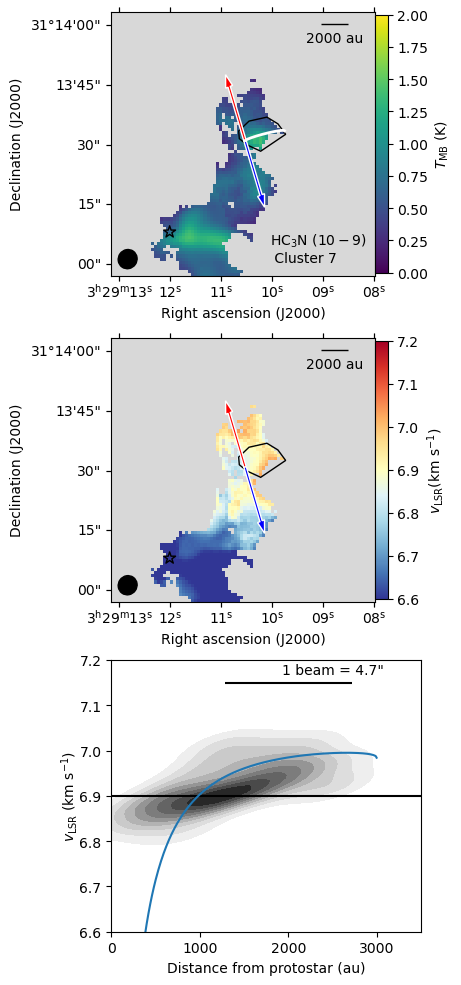

In [28]:
fig = plt.figure(figsize=(4,12))
ax = fig.add_subplot(311, projection=iras4a_wcsskyhc3n)
map = iras4a_hc3ncluster[0]
map2 = iras4a_hc3ncluster[1]
cmap = cm.get_cmap('viridis').copy()
cmap.set_bad('0.85')
cmap2 = cm.get_cmap('RdYlBu_r').copy()
cmap2.set_bad('0.85')
tmin=0
tmax=2

vmin = iras4a_vlsr-0.3
vmax = iras4a_vlsr+0.3
label = r'$T_{\mathrm{MB}}$ (K)'#r'$v_{\mathrm{LSR}}$(km s$^{-1}$)'

sc1 = ax.imshow(map, cmap=cmap, vmin=tmin, vmax=tmax)
fig.colorbar(sc1, ax=ax, label=label, pad=-0.002, shrink=0.95)
reg_load_pix = iras4a_region.to_pixel(iras4a_wcsskyhc3n)
reg_load_pix.visual['edgecolor'] = 'black'
reg_load_pix.plot(ax=ax)
# IRAS 4B
ax.scatter(catalog_protostars.loc[1, 'RAJ2000'], catalog_protostars.loc[1, 'DEJ2000'], transform=ax.get_transform('world'), marker='*', s=80, ec ='k', fc='None')
add_beam(ax, major=bmaj, minor=bmin, angle=bpa, color='k', pad=0.1)
ax.annotate('HC$_3$N ($10-9$) \n Cluster 7', (0.6, 0.05), xycoords='axes fraction', fontsize=10)
add_scalebar(ax, 2000/293*u.arcsec, corner='top right', label='2000 au')
# outflow
ax.arrow(catalog_protostars.loc[0, 'RAJ2000'], catalog_protostars.loc[0, 'DEJ2000'],  0.004*np.sin((19*u.deg).to(u.rad).value), 0.004*np.cos((19*u.deg).to(u.rad).value), transform=ax.get_transform('world'), fc='r', ec='w', width=0.0002)
ax.arrow(catalog_protostars.loc[0, 'RAJ2000'], catalog_protostars.loc[0, 'DEJ2000'],  -0.004*np.sin((19*u.deg).to(u.rad).value), -0.004*np.cos((19*u.deg).to(u.rad).value), transform=ax.get_transform('world'), fc='b', ec='w', width=0.0002)
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')

ax3 = fig.add_subplot(312, projection=iras4a_wcsskyhc3n)
sc2 = ax3.imshow(map2, cmap=cmap2, vmin=vmin, vmax=vmax)
fig.colorbar(sc2, ax=ax3, label=r'$v_{\mathrm{LSR}}$(km s$^{-1}$)', pad=-0.002, shrink=0.95)
# reg_load_pix = iras4a_region.to_pixel(iras4a_wcsskyhc3n)
# reg_load_pix.visual['edgecolor'] = 'black'
reg_load_pix.plot(ax=ax3)
# IRAS 4B
ax3.scatter(catalog_protostars.loc[1, 'RAJ2000'], catalog_protostars.loc[1, 'DEJ2000'], transform=ax3.get_transform('world'), marker='*', s=80, ec ='k', fc='None')
add_beam(ax3, major=bmaj, minor=bmin, angle=bpa, color='k', pad=0.1)
# ax.annotate('HC$_3$N ($10-9$) \n Cluster 7', (0.6, 0.05), xycoords='axes fraction', fontsize=10)
add_scalebar(ax3, 2000/293*u.arcsec, corner='top right', label='2000 au')
# outflow
ax3.arrow(catalog_protostars.loc[0, 'RAJ2000'], catalog_protostars.loc[0, 'DEJ2000'],  0.004*np.sin((19*u.deg).to(u.rad).value), 0.004*np.cos((19*u.deg).to(u.rad).value), transform=ax3.get_transform('world'), fc='r', ec='w', width=0.0002)
ax3.arrow(catalog_protostars.loc[0, 'RAJ2000'], catalog_protostars.loc[0, 'DEJ2000'],  -0.004*np.sin((19*u.deg).to(u.rad).value), -0.004*np.cos((19*u.deg).to(u.rad).value), transform=ax3.get_transform('world'), fc='b', ec='w', width=0.0002)
lon = ax3.coords[0]
lat = ax3.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')

xx, yy, zz = do_kde(iras4a_hc3ncluster[1], iras4a_hc3nhead, catalog_protostars.loc[0, 'RAJ2000'], catalog_protostars.loc[0, 'DEJ2000'], 
                    reg_load_pix, 293, 0, 3500, vmin, vmax)

ax2 = fig.add_subplot(313)
ax2.contourf(xx, yy, zz, cmap='Greys', levels=np.arange(0.1, 1.2, 0.1), vmin=0., vmax=1.1)
ax2.axhline(iras4a_vlsr, color='k')
ax2.set_ylim([6.6, 7.2])
ax2.set_xlabel('Distance from protostar (au)')
ax2.set_ylabel(r'$v_{\mathrm{LSR}}$ (km s$^{-1}$)',labelpad=-0.1)
ax2.hlines(y=7.15, xmin=2000-(bmaj.to(u.arcsec).value/2*293), xmax=2000+(bmaj.to(u.arcsec).value/2*293), color='k')
ax2.annotate('1 beam = 4.7"', (0.55, 0.95), xycoords='axes fraction')

# if we want to add the streamer
Mtot = 2.3 *u.Msun
r0 = 3000 * u.au
theta0 = 92 * u.deg  # rotate clockwise
phi0 = -5 * u.deg
v_r0 = 0.0 * u.km/u.s
omega0 = 2.3e-13 / u.s
inc = (-35) * u.deg
PA_ang = (19)*u.deg
fil0, dsky0, velo0 = get_streamer(Mtot, catalog_protostars.loc[0, 'vlsr']*u.km/u.s, r0, theta0, phi0, 
                                  omega0, v_r0, inc, PA_ang, 293, catalog_protostars.loc[0, 'RAJ2000'], 
                                  catalog_protostars.loc[0, 'DEJ2000'])

line_image, = ax.plot(fil0.ra, fil0.dec, transform=ax.get_transform('fk5'), ls='-', lw=2, color='w')
line_vel, = ax2.plot(dsky0, velo0)

fig.savefig('figures/zoom_iras4a_hc3n_tmb_wstreamer.pdf', bbox_inches='tight', dpi=300)

/tmp/ipykernel_5410/1022358501.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdYlBu_r').copy()
/tmp/ipykernel_5410/1022358501.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis').copy()


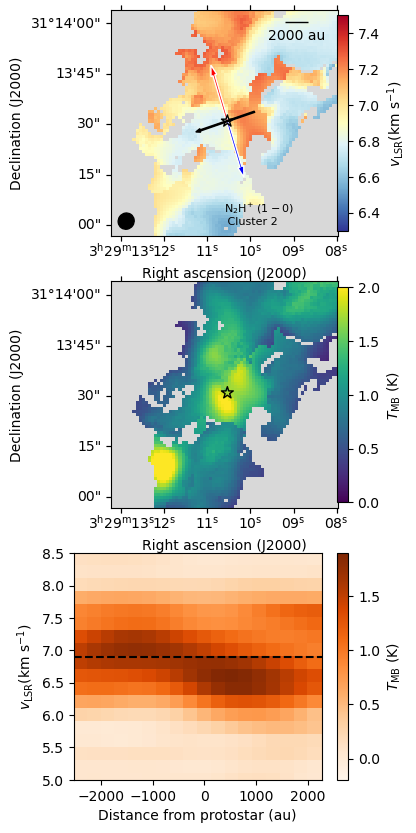

In [24]:
fig = plt.figure(figsize=(4,10))
ax = fig.add_subplot(311, projection=WCS(iras4a_n2hphead).celestial)
map = iras4a_n2hpcluster[1]
cmap = cm.get_cmap('RdYlBu_r').copy()
cmap.set_bad('0.85')
vmin = iras4a_vlsr-0.6
vmax = iras4a_vlsr+0.6

label = r'$v_{\mathrm{LSR}}$(km s$^{-1}$)'

sc1 = ax.imshow(map, cmap=cmap, vmin=vmin, vmax=vmax)
fig.colorbar(sc1, ax=ax, label=label, pad=-0.002, shrink=0.95)
ax.scatter(catalog_protostars.loc[0, 'RAJ2000'], catalog_protostars.loc[0, 'DEJ2000'], transform=ax.get_transform('world'), marker='*', s=80, ec ='k', fc='None', zorder=100)
add_beam(ax, major=bmaj, minor=bmin, angle=bpa, color='k', pad=0.1)
ax.annotate('N$_2$H$^{+}$ ($1-0$)\n Cluster 2', (0.5, 0.05), xycoords='axes fraction', fontsize=8)
add_scalebar(ax, 2000/293*u.arcsec, corner='top right', label='2000 au')
# outflow
ax.arrow(catalog_protostars.loc[0, 'RAJ2000'], catalog_protostars.loc[0, 'DEJ2000'],  0.004*np.sin((19*u.deg).to(u.rad).value), 0.004*np.cos((19*u.deg).to(u.rad).value), transform=ax.get_transform('world'), fc='r', ec='w', width=0.0002)
ax.arrow(catalog_protostars.loc[0, 'RAJ2000'], catalog_protostars.loc[0, 'DEJ2000'],  -0.004*np.sin((19*u.deg).to(u.rad).value), -0.004*np.cos((19*u.deg).to(u.rad).value), transform=ax.get_transform('world'), fc='b', ec='w', width=0.0002)
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')

ax2 = fig.add_subplot(312, projection=WCS(iras4a_n2hphead).celestial)
map = iras4a_n2hpcluster[0]
cmap = cm.get_cmap('viridis').copy()
cmap.set_bad('0.85')
tmin=0
tmax=2
sc2 = ax2.imshow(map, cmap=cmap, vmin=tmin, vmax=tmax)
fig.colorbar(sc2, ax=ax2, label=r'$T_{\mathrm{MB}}$ (K)', pad=-0.002, shrink=0.95)
ax2.scatter(catalog_protostars.loc[0, 'RAJ2000'], catalog_protostars.loc[0, 'DEJ2000'], transform=ax2.get_transform('world'), marker='*', s=80, ec ='k', fc='None')
lon = ax2.coords[0]
lat = ax2.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')

pvarcsecfilename = 'analysis/protostar_cutouts/IRAS4A_N2Hp_pvdiag_arcsec.fits'
pvdata, pvheader = fits.getdata(pvarcsecfilename, header=True)
pa_angle = (19+90)*u.deg #degrees from north
centerxdeg, centerydeg = catalog_protostars.loc[0, 'RAJ2000']*u.deg, catalog_protostars.loc[0, 'DEJ2000']*u.deg
length = (5000 / 293 *u.arcsec).to(u.deg)
pathcenter = PathFromCenter(SkyCoord(centerxdeg, centerydeg), length, angle=pa_angle)
pathcoords = pathcenter._coords

# ax.plot(pathcoords.ra.value, pathcoords.dec.value,transform=ax.get_transform('world'), color='k')
ax.arrow(pathcoords.ra.value[0], pathcoords.dec.value[0], pathcoords.ra.value[1]-pathcoords.ra.value[0],  pathcoords.dec.value[1]- pathcoords.dec.value[0],
        width=0.0001, color='k', transform=ax.get_transform('world'))
ax3 = fig.add_subplot(313)
delta0 = pvheader['CRVAL1']
delta_delta = pvheader['CDELT1']
delta_pix0 = pvheader['CRPIX1']
delta_npix = pvheader['NAXIS1']
vel0 = pvheader['CRVAL2']
delta_vel = pvheader['CDELT2']
vel_pix0 = pvheader['CRPIX2']
vel_npix = pvheader['NAXIS2']
delta_array = np.array([delta0 + delta_delta*(i-delta_pix0) for i in range(delta_npix)]) * u.arcsec
vel_array = np.array([vel0 + delta_vel * (i - vel_pix0) for i in range(vel_npix)]) * u.m/u.s
vel_array = vel_array.to(u.km/u.s)
distance_array = (delta_array).value * 293 * u.au 
# we create the meshgrid to plot
offset, vel = np.meshgrid(distance_array, vel_array)

pcolor = ax3.pcolor(offset.value, vel.value, pvdata, shading='auto', cmap='Oranges')
fig.colorbar(pcolor, ax=ax3, label=r'$T_{\mathrm{MB}}$ (K)')
# ax3.axhline(per15_vlsr, color='k', ls=':', alpha=0.5)
ax3.axhline(iras4a_vlsr, color='k', linestyle='dashed')
ax3.set_xlabel('Distance from protostar (au)')
ax3.set_ylabel(r'$v_{\mathrm{LSR}}$(km s$^{-1}$)')
ax3.set_ylim([5,8.5])
fig.savefig('figures/zoom_iras4a_n2hp_tmb_vlsr_cut.pdf', bbox_inches='tight', dpi=300)

In [12]:
# IRAS 4B

iras4b_hc3nclusterfile = 'analysis/protostar_cutouts/IRAS4B_HC3N_cluster7.fits'
iras4b_hc3nclusterfile2 = 'analysis/protostar_cutouts/IRAS4B_HC3N_cluster4.fits'
iras4b_regionfile = 'analysis/protostar_cutouts/candidate_region_IRAS4B_2.reg'
iras4b_regionfile_outflow = 'analysis/protostar_cutouts/candidate_region_IRAS4B.reg'

iras4b_n2hpclusterfile = 'analysis/protostar_cutouts/IRAS4B_N2Hp_cluster2.fits'
iras4b_n2hpclusterfile2 = 'analysis/protostar_cutouts/IRAS4B_N2Hp_cluster1.fits'
iras4b_blueoutflow = 'data/MASSES/Per13.12CO21.robust1_blue.fits'
iras4b_redoutflow = 'data/MASSES/Per13.12CO21.robust1_red.fits'

iras4b_hc3ncluster, iras4b_hc3nhead = fits.getdata(iras4b_hc3nclusterfile, header=True)
iras4b_hc3ncluster2 = fits.getdata(iras4b_hc3nclusterfile2)
iras4b_wcsskyhc3n = WCS(iras4b_hc3nhead).celestial
iras4b_n2hpcluster, iras4b_n2hphead = fits.getdata(iras4b_n2hpclusterfile, header=True)
iras4b_n2hpcluster2 = fits.getdata(iras4b_n2hpclusterfile2)
iras4b_wcsskyn2hp = WCS(iras4b_n2hphead).celestial
iras4b_region = Regions.read(iras4b_regionfile)[0]
iras4b_region_outflow = Regions.read(iras4b_regionfile_outflow)[0]
iras4b_vlsr = catalog_protostars.loc[1, 'vlsr']
iras4b_blue, iras4b_cohead = fits.getdata(iras4b_blueoutflow, header=True)
iras4b_red = fits.getdata(iras4b_redoutflow)

/tmp/ipykernel_30919/3097338408.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis').copy()
/tmp/ipykernel_30919/3097338408.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmaptransparent = cm.get_cmap('viridis').copy()
/tmp/ipykernel_30919/3097338408.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap('RdYlBu_r').copy()
/tmp/ipykernel_30919/3097338408.py:16: MatplotlibDeprecationWarning: The get_cmap function was depreca

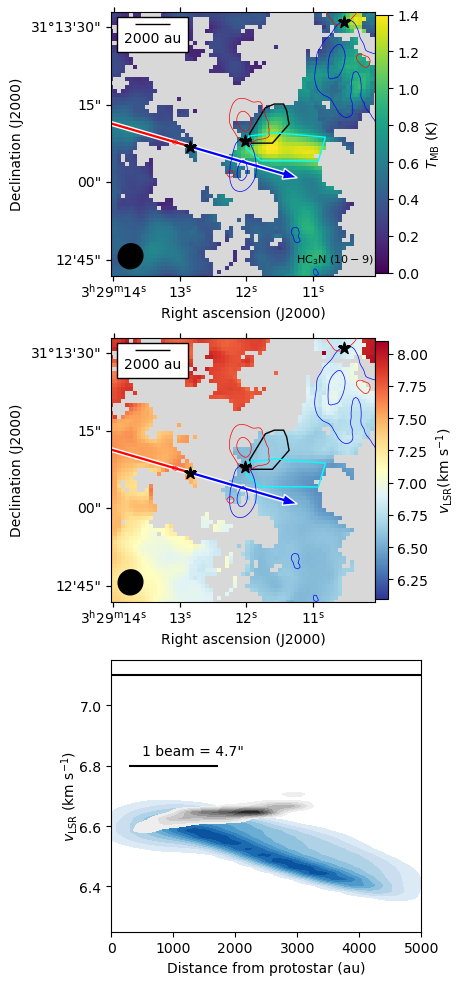

In [183]:
# this plot shows the streamer candidate
# fig, [ax, ax2, ax3] = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=True, figsize=(4,8), subplot_kw={'projection': iras4b_wcsskyhc3n})

fig = plt.figure(figsize=(4,12))
ax = fig.add_subplot(311, projection=iras4b_wcsskyhc3n)
ax2 = fig.add_subplot(312, projection=iras4b_wcsskyhc3n)
ax3 = fig.add_subplot(313)
map = iras4b_hc3ncluster[0]
map2 = iras4b_hc3ncluster[1]
cmap = cm.get_cmap('viridis').copy()
cmap.set_bad('0.85')
cmaptransparent = cm.get_cmap('viridis').copy()
cmaptransparent.set_bad('0.85', alpha=0)
cmap2 = cm.get_cmap('RdYlBu_r').copy()
cmap2.set_bad('0.85')
cmap2transparent = cm.get_cmap('RdYlBu_r').copy()
cmap2transparent.set_bad('0.85', alpha=0)
tmin=0
tmax=1.4
bluerange = np.arange(3, 3*100, 18)
redrange = np.arange(1.6, 1.6*100, 15)
vmin = iras4b_vlsr-1
vmax = iras4b_vlsr+1
label = r'$T_{\mathrm{MB}}$ (K)'#r'$v_{\mathrm{LSR}}$(km s$^{-1}$)'

sc1 = ax.imshow(map, cmap=cmap, vmin=tmin, vmax=tmax)
fig.colorbar(sc1, ax=ax, label=label, pad=-0.002, shrink=0.95)
ax.imshow(iras4b_hc3ncluster2[0], cmap=cmaptransparent, vmin=tmin, vmax=tmax)
ax.scatter(catalog_protostars.loc[0, 'RAJ2000'], catalog_protostars.loc[0, 'DEJ2000'], transform=ax.get_transform('world'), marker='*', s=80, ec ='k', fc='k', zorder=100)
ax.scatter(catalog_protostars.loc[1, 'RAJ2000'], catalog_protostars.loc[1, 'DEJ2000'], transform=ax.get_transform('world'), marker='*', s=80, ec ='k', fc='k', zorder=100)
ax.scatter(catalog_protostars.loc[9, 'RAJ2000'], catalog_protostars.loc[9, 'DEJ2000'], transform=ax.get_transform('world'), marker='*', s=80, ec ='k', fc='k', zorder=100)
# IRAS 4B2
ax.arrow(catalog_protostars.loc[9, 'RAJ2000'], catalog_protostars.loc[9, 'DEJ2000'],  0.006*np.sin(1.32645), 0.006*np.cos(1.32645), transform=ax.get_transform('world'), fc='r', ec='w', width=0.0002)
ax.arrow(catalog_protostars.loc[9, 'RAJ2000'], catalog_protostars.loc[9, 'DEJ2000'],  -0.006*np.sin(1.32645), -0.006*np.cos(1.32645), transform=ax.get_transform('world'), fc='b', ec='w', width=0.0002)
ax.contour(iras4b_blue, transform=ax.get_transform(WCS(iras4b_cohead)), levels=bluerange, colors='blue', linewidths=0.5)
ax.contour(iras4b_red, transform=ax.get_transform(WCS(iras4b_cohead)), levels=redrange, colors='red', linewidths=0.5)
add_beam(ax, major=bmaj, minor=bmin, angle=bpa, color='k', pad=0.1)
ax.annotate(r'HC$_3$N ($10-9$)', (0.7, 0.05), xycoords='axes fraction', fontsize=8)
add_scalebar(ax, 2000/293*u.arcsec, corner='top left', label='2000 au', frame=True)
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')
ax.set_xlim([10, np.shape(map2)[1]-10])
ax.set_ylim([10, np.shape(map2)[0]-10])
reg_load_pix = iras4b_region.to_pixel(iras4b_wcsskyhc3n)
reg_load_pix.visual['edgecolor'] = 'black'
reg_load_pix.plot(ax=ax)
reg_load_pix2 = iras4b_region_outflow.to_pixel(iras4b_wcsskyhc3n)
reg_load_pix2.visual['edgecolor'] = 'cyan'
reg_load_pix2.plot(ax=ax)

sc2 = ax2.imshow(map2, cmap=cmap2, vmin=vmin, vmax=vmax)
ax2.scatter(catalog_protostars.loc[0, 'RAJ2000'], catalog_protostars.loc[0, 'DEJ2000'], transform=ax2.get_transform('world'), marker='*', s=80, ec ='k', fc='k', zorder=100)
ax2.scatter(catalog_protostars.loc[1, 'RAJ2000'], catalog_protostars.loc[1, 'DEJ2000'], transform=ax2.get_transform('world'), marker='*', s=80, ec ='k', fc='k', zorder=100)
ax2.scatter(catalog_protostars.loc[9, 'RAJ2000'], catalog_protostars.loc[9, 'DEJ2000'], transform=ax2.get_transform('world'), marker='*', s=80, ec ='k', fc='k', zorder=100)
ax2.imshow(iras4b_hc3ncluster2[1], cmap=cmap2transparent, vmin=vmin, vmax=vmax)

fig.colorbar(sc2, ax=ax2, label=r'$v_{\mathrm{LSR}}$(km s$^{-1}$)', pad=-0.002, shrink=0.95)
ax2.contour(iras4b_blue, transform=ax2.get_transform(WCS(iras4b_cohead)), levels=bluerange, colors='blue', linewidths=0.5)
ax2.contour(iras4b_red, transform=ax2.get_transform(WCS(iras4b_cohead)), levels=redrange, colors='red', linewidths=0.5)
ax2.set_xlim([10, np.shape(map2)[1]-10])
ax2.set_ylim([10, np.shape(map2)[0]-10])
# IRAS 4B2
ax2.arrow(catalog_protostars.loc[9, 'RAJ2000'], catalog_protostars.loc[9, 'DEJ2000'],  0.006*np.sin(1.32645), 0.006*np.cos(1.32645), transform=ax2.get_transform('world'), fc='r', ec='w', width=0.0002)
ax2.arrow(catalog_protostars.loc[9, 'RAJ2000'], catalog_protostars.loc[9, 'DEJ2000'],  -0.006*np.sin(1.32645), -0.006*np.cos(1.32645), transform=ax2.get_transform('world'), fc='b', ec='w', width=0.0002)
lon = ax2.coords[0]
lat = ax2.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')
add_scalebar(ax2, 2000/293*u.arcsec, corner='top left', label='2000 au', frame=True)
reg_load_pix.plot(ax=ax2)
reg_load_pix2.plot(ax=ax2)
add_beam(ax2, major=bmaj, minor=bmin, angle=bpa, color='k', pad=0.1)

xx, yy, zz = do_kde(iras4b_hc3ncluster[1], iras4b_hc3nhead, catalog_protostars.loc[1, 'RAJ2000'], catalog_protostars.loc[1, 'DEJ2000'], 
                    reg_load_pix, 293, 0, 3500, vmin, vmax)
xx2, yy2, zz2 = do_kde(iras4b_hc3ncluster[1], iras4b_hc3nhead, catalog_protostars.loc[1, 'RAJ2000'], catalog_protostars.loc[1, 'DEJ2000'], 
                    reg_load_pix2, 293, 0, 5000, vmin, vmax)


ax3.contourf(xx, yy, zz, cmap='Greys', levels=np.arange(0.1, 1.2, 0.1), vmin=0., vmax=1.1, zorder=100)
ax3.contourf(xx2, yy2, zz2, cmap='Blues', levels=np.arange(0.1, 1.2, 0.1), vmin=0., vmax=1.1)
ax3.axhline(iras4b_vlsr, color='k')
ax3.set_ylim([6.25, 7.15])
ax3.set_xlabel('Distance from protostar (au)')
ax3.set_ylabel(r'$v_{\mathrm{LSR}}$ (km s$^{-1}$)',labelpad=-0.1)
ax3.hlines(y=6.8, xmin=1000-(bmaj.to(u.arcsec).value/2*293), xmax=1000+(bmaj.to(u.arcsec).value/2*293), color='k')
ax3.annotate('1 beam = 4.7"', (0.1, 0.65), xycoords='axes fraction')

fig.savefig('figures/zoom_iras4b_hc3n_tmb_vlsr.pdf', bbox_inches='tight', dpi=300)


In [ ]:
# this plot shows the IRAS4B2 outflow
# fig, [ax, ax2, ax3] = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=True, figsize=(4,8), subplot_kw={'projection': iras4b_wcsskyhc3n})

fig = plt.figure(figsize=(4,12))
ax = fig.add_subplot(311, projection=iras4b_wcsskyhc3n)
ax2 = fig.add_subplot(312, projection=iras4b_wcsskyhc3n)
ax3 = fig.add_subplot(313)
map = iras4b_hc3ncluster[0]
map2 = iras4b_hc3ncluster[1]
cmap = cm.get_cmap('viridis').copy()
cmap.set_bad('0.85')
cmaptransparent = cm.get_cmap('viridis').copy()
cmaptransparent.set_bad('0.85', alpha=0)
cmap2 = cm.get_cmap('RdYlBu_r').copy()
cmap2.set_bad('0.85')
cmap2transparent = cm.get_cmap('RdYlBu_r').copy()
cmap2transparent.set_bad('0.85', alpha=0)
tmin=0
tmax=1.4
bluerange = np.arange(3, 3*100, 18)
redrange = np.arange(1.6, 1.6*100, 15)
vmin = iras4b_vlsr-1
vmax = iras4b_vlsr+1
label = r'$T_{\mathrm{MB}}$ (K)'#r'$v_{\mathrm{LSR}}$(km s$^{-1}$)'

sc1 = ax.imshow(map, cmap=cmap, vmin=tmin, vmax=tmax)
fig.colorbar(sc1, ax=ax, label=label, pad=-0.002, shrink=0.95)
ax.imshow(iras4b_hc3ncluster2[0], cmap=cmaptransparent, vmin=tmin, vmax=tmax)
ax.scatter(catalog_protostars.loc[0, 'RAJ2000'], catalog_protostars.loc[0, 'DEJ2000'], transform=ax.get_transform('world'), marker='*', s=80, ec ='k', fc='k', zorder=100)
ax.scatter(catalog_protostars.loc[1, 'RAJ2000'], catalog_protostars.loc[1, 'DEJ2000'], transform=ax.get_transform('world'), marker='*', s=80, ec ='k', fc='k', zorder=100)
ax.scatter(catalog_protostars.loc[9, 'RAJ2000'], catalog_protostars.loc[9, 'DEJ2000'], transform=ax.get_transform('world'), marker='*', s=80, ec ='k', fc='k', zorder=100)
# IRAS 4B2
ax.arrow(catalog_protostars.loc[9, 'RAJ2000'], catalog_protostars.loc[9, 'DEJ2000'],  0.006*np.sin(1.32645), 0.006*np.cos(1.32645), transform=ax.get_transform('world'), fc='r', ec='w', width=0.0002)
ax.arrow(catalog_protostars.loc[9, 'RAJ2000'], catalog_protostars.loc[9, 'DEJ2000'],  -0.006*np.sin(1.32645), -0.006*np.cos(1.32645), transform=ax.get_transform('world'), fc='b', ec='w', width=0.0002)
ax.contour(iras4b_blue, transform=ax.get_transform(WCS(iras4b_cohead)), levels=bluerange, colors='blue', linewidths=0.5)
ax.contour(iras4b_red, transform=ax.get_transform(WCS(iras4b_cohead)), levels=redrange, colors='red', linewidths=0.5)
add_beam(ax, major=bmaj, minor=bmin, angle=bpa, color='k', pad=0.1)
ax.annotate(r'HC$_3$N ($10-9$)', (0.7, 0.05), xycoords='axes fraction', fontsize=8)
add_scalebar(ax, 2000/293*u.arcsec, corner='top left', label='2000 au', frame=True)
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')
ax.set_xlim([10, np.shape(map2)[1]-10])
ax.set_ylim([10, np.shape(map2)[0]-10])
reg_load_pix = iras4b_region_outflow.to_pixel(iras4b_wcsskyhc3n)
reg_load_pix.visual['edgecolor'] = 'black'
reg_load_pix.plot(ax=ax)

sc2 = ax2.imshow(map2, cmap=cmap2, vmin=vmin, vmax=vmax)
ax2.scatter(catalog_protostars.loc[0, 'RAJ2000'], catalog_protostars.loc[0, 'DEJ2000'], transform=ax2.get_transform('world'), marker='*', s=80, ec ='k', fc='k', zorder=100)
ax2.scatter(catalog_protostars.loc[1, 'RAJ2000'], catalog_protostars.loc[1, 'DEJ2000'], transform=ax2.get_transform('world'), marker='*', s=80, ec ='k', fc='k', zorder=100)
ax2.scatter(catalog_protostars.loc[9, 'RAJ2000'], catalog_protostars.loc[9, 'DEJ2000'], transform=ax2.get_transform('world'), marker='*', s=80, ec ='k', fc='k', zorder=100)
ax2.imshow(iras4b_hc3ncluster2[1], cmap=cmap2transparent, vmin=vmin, vmax=vmax)

fig.colorbar(sc2, ax=ax2, label=r'$v_{\mathrm{LSR}}$(km s$^{-1}$)', pad=-0.002, shrink=0.95)
ax2.contour(iras4b_blue, transform=ax2.get_transform(WCS(iras4b_cohead)), levels=bluerange, colors='blue', linewidths=0.5)
ax2.contour(iras4b_red, transform=ax2.get_transform(WCS(iras4b_cohead)), levels=redrange, colors='red', linewidths=0.5)
ax2.set_xlim([10, np.shape(map2)[1]-10])
ax2.set_ylim([10, np.shape(map2)[0]-10])
# IRAS 4B2
ax2.arrow(catalog_protostars.loc[9, 'RAJ2000'], catalog_protostars.loc[9, 'DEJ2000'],  0.006*np.sin(1.32645), 0.006*np.cos(1.32645), transform=ax2.get_transform('world'), fc='r', ec='w', width=0.0002)
ax2.arrow(catalog_protostars.loc[9, 'RAJ2000'], catalog_protostars.loc[9, 'DEJ2000'],  -0.006*np.sin(1.32645), -0.006*np.cos(1.32645), transform=ax2.get_transform('world'), fc='b', ec='w', width=0.0002)
lon = ax2.coords[0]
lat = ax2.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')
add_scalebar(ax2, 2000/293*u.arcsec, corner='top left', label='2000 au', frame=True)
reg_load_pix.plot(ax=ax2)
add_beam(ax2, major=bmaj, minor=bmin, angle=bpa, color='k', pad=0.1)

xx, yy, zz = do_kde(iras4b_hc3ncluster[1], iras4b_hc3nhead, catalog_protostars.loc[1, 'RAJ2000'], catalog_protostars.loc[1, 'DEJ2000'], 
                    reg_load_pix, 293, 0, 3500, vmin, vmax)


ax3.contourf(xx, yy, zz, cmap='Greys', levels=np.arange(0.1, 1.2, 0.1), vmin=0., vmax=1.1)
ax3.axhline(iras4b_vlsr, color='k')
ax3.set_ylim([6.55, 7.15])
ax3.set_xlabel('Distance from protostar (au)')
ax3.set_ylabel(r'$v_{\mathrm{LSR}}$ (km s$^{-1}$)',labelpad=-0.1)
ax3.hlines(y=6.8, xmin=1000-(bmaj.to(u.arcsec).value/2*293), xmax=1000+(bmaj.to(u.arcsec).value/2*293), color='k')
ax3.annotate('1 beam = 4.7"', (0.1, 0.45), xycoords='axes fraction')

fig.savefig('figures/zoom_iras4b_hc3n_tmb_vlsr_outflow.pdf', bbox_inches='tight', dpi=300)


/tmp/ipykernel_5410/3339987119.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis').copy()
/tmp/ipykernel_5410/3339987119.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmaptransparent = cm.get_cmap('viridis').copy()
/tmp/ipykernel_5410/3339987119.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap('RdYlBu_r').copy()
/tmp/ipykernel_5410/3339987119.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in

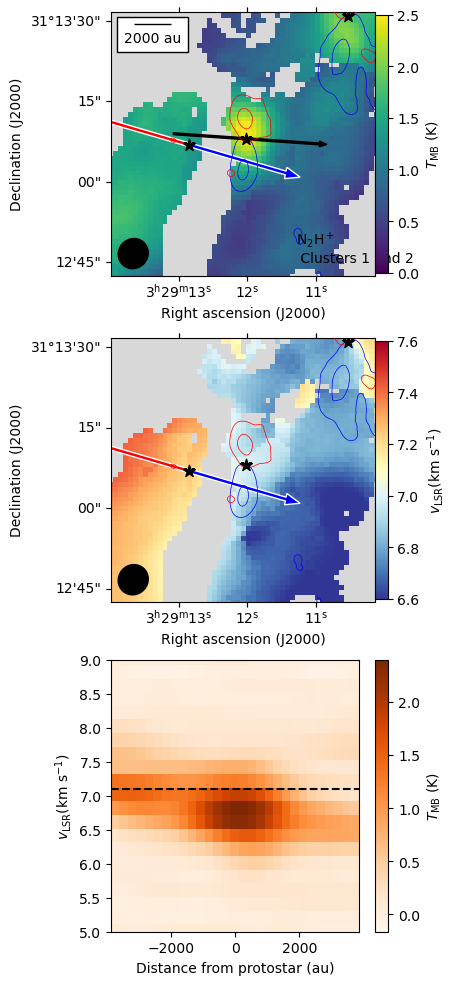

In [37]:
# fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, figsize=(4,4), subplot_kw={'projection': iras4b_wcsskyn2hp})
# fig.subplots_adjust(wspace=0, hspace=0)
fig = plt.figure(figsize=(4,12))
ax = fig.add_subplot(311, projection=iras4b_wcsskyn2hp)
map = iras4b_n2hpcluster[0]
map2 = iras4b_n2hpcluster[1]
cmap = cm.get_cmap('viridis').copy()
cmap.set_bad('0.85')
cmaptransparent = cm.get_cmap('viridis').copy()
cmaptransparent.set_bad('0.85', alpha=0)
cmap2 = cm.get_cmap('RdYlBu_r').copy()
cmap2.set_bad('0.85')
cmap2transparent = cm.get_cmap('RdYlBu_r').copy()
cmap2transparent.set_bad('0.85', alpha=0)

tmin=0
tmax=2.5
vmin = iras4b_vlsr - 0.5
vmax = iras4b_vlsr + 0.5
bluerange = np.arange(3, 3*100, 18)
redrange = np.arange(1.6, 1.6*100, 15)
label = r'$T_{\mathrm{MB}}$ (K)'#r'$v_{\mathrm{LSR}}$(km s$^{-1}$)'

sc1 = ax.imshow(map, cmap=cmap, vmin=tmin, vmax=tmax)
fig.colorbar(sc1, ax=ax, label=label, pad=-0.002, shrink=0.95)
ax.imshow(iras4b_n2hpcluster2[0], cmap=cmaptransparent, vmin=tmin, vmax=tmax)
ax.scatter(catalog_protostars.loc[0, 'RAJ2000'], catalog_protostars.loc[0, 'DEJ2000'], transform=ax.get_transform('world'), marker='*', s=80, ec ='k', fc='k', zorder=100)
ax.scatter(catalog_protostars.loc[1, 'RAJ2000'], catalog_protostars.loc[1, 'DEJ2000'], transform=ax.get_transform('world'), marker='*', s=80, ec ='k', fc='k', zorder=100)
ax.scatter(catalog_protostars.loc[9, 'RAJ2000'], catalog_protostars.loc[9, 'DEJ2000'], transform=ax.get_transform('world'), marker='*', s=80, ec ='k', fc='k', zorder=100)
# IRAS 4B2
ax.arrow(catalog_protostars.loc[9, 'RAJ2000'], catalog_protostars.loc[9, 'DEJ2000'],  0.006*np.sin(1.32645), 0.006*np.cos(1.32645), transform=ax.get_transform('world'), fc='r', ec='w', width=0.0002)
ax.arrow(catalog_protostars.loc[9, 'RAJ2000'], catalog_protostars.loc[9, 'DEJ2000'],  -0.006*np.sin(1.32645), -0.006*np.cos(1.32645), transform=ax.get_transform('world'), fc='b', ec='w', width=0.0002)
ax.contour(iras4b_blue, transform=ax.get_transform(WCS(iras4b_cohead)), levels=bluerange, colors='blue', linewidths=0.5)
ax.contour(iras4b_red, transform=ax.get_transform(WCS(iras4b_cohead)), levels=redrange, colors='red', linewidths=0.5)
add_beam(ax, major=bmajn2hp, minor=bminn2hp, angle=bpan2hp, color='k', pad=0.1)
ax.annotate('N$_2$H$^+$ \n Clusters 1 and 2', (0.7, 0.05), xycoords='axes fraction', fontsize=10)
add_scalebar(ax, 2000/293*u.arcsec, corner='top left', label='2000 au', frame=True)
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')
ax.set_xlim([10, np.shape(map2)[1]-10])
ax.set_ylim([10, np.shape(map2)[0]-10])

ax3 = fig.add_subplot(312, projection=iras4b_wcsskyn2hp)
sc2 = ax3.imshow(map2, cmap=cmap2, vmin=vmin, vmax=vmax)
fig.colorbar(sc2, ax=ax3, label=r'$v_{\mathrm{LSR}}$(km s$^{-1}$)', pad=-0.002, shrink=0.95)
ax3.imshow(iras4b_n2hpcluster2[1], cmap=cmap2transparent, vmin=vmin, vmax=vmax)
ax3.scatter(catalog_protostars.loc[0, 'RAJ2000'], catalog_protostars.loc[0, 'DEJ2000'], transform=ax3.get_transform('world'), marker='*', s=80, ec ='k', fc='k', zorder=100)
ax3.scatter(catalog_protostars.loc[1, 'RAJ2000'], catalog_protostars.loc[1, 'DEJ2000'], transform=ax3.get_transform('world'), marker='*', s=80, ec ='k', fc='k', zorder=100)
ax3.scatter(catalog_protostars.loc[9, 'RAJ2000'], catalog_protostars.loc[9, 'DEJ2000'], transform=ax3.get_transform('world'), marker='*', s=80, ec ='k', fc='k', zorder=100)
# IRAS 4B2
ax3.arrow(catalog_protostars.loc[9, 'RAJ2000'], catalog_protostars.loc[9, 'DEJ2000'],  0.006*np.sin(1.32645), 0.006*np.cos(1.32645), transform=ax3.get_transform('world'), fc='r', ec='w', width=0.0002)
ax3.arrow(catalog_protostars.loc[9, 'RAJ2000'], catalog_protostars.loc[9, 'DEJ2000'],  -0.006*np.sin(1.32645), -0.006*np.cos(1.32645), transform=ax3.get_transform('world'), fc='b', ec='w', width=0.0002)
ax3.contour(iras4b_blue, transform=ax3.get_transform(WCS(iras4b_cohead)), levels=bluerange, colors='blue', linewidths=0.5)
ax3.contour(iras4b_red, transform=ax3.get_transform(WCS(iras4b_cohead)), levels=redrange, colors='red', linewidths=0.5)
add_beam(ax3, major=bmajn2hp, minor=bminn2hp, angle=bpan2hp, color='k', pad=0.1)
lon = ax3.coords[0]
lat = ax3.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')
ax3.set_xlim([10, np.shape(map2)[1]-10])
ax3.set_ylim([10, np.shape(map2)[0]-10])

ax2 = fig.add_subplot(313)

pvarcsecfilename = 'analysis/protostar_cutouts/IRAS4B_N2Hp_pvdiag_arcsec.fits'
pvdata, pvheader = fits.getdata(pvarcsecfilename, header=True)
pa_angle = (176+90)*u.deg #degrees from north
centerxdeg, centerydeg = catalog_protostars.loc[1, 'RAJ2000']*u.deg, catalog_protostars.loc[1, 'DEJ2000']*u.deg
length = (8000 / 293 *u.arcsec).to(u.deg)
pathcenter = PathFromCenter(SkyCoord(centerxdeg, centerydeg), length, angle=pa_angle)
pathcoords = pathcenter._coords

# ax.plot(pathcoords.ra.value, pathcoords.dec.value,transform=ax.get_transform('world'), color='k')
ax.arrow(pathcoords.ra.value[0], pathcoords.dec.value[0], pathcoords.ra.value[1]-pathcoords.ra.value[0],  pathcoords.dec.value[1]- pathcoords.dec.value[0],
        width=0.0001, color='k', transform=ax.get_transform('world'))
delta0 = pvheader['CRVAL1']
delta_delta = pvheader['CDELT1']
delta_pix0 = pvheader['CRPIX1']
delta_npix = pvheader['NAXIS1']
vel0 = pvheader['CRVAL2']
delta_vel = pvheader['CDELT2']
vel_pix0 = pvheader['CRPIX2']
vel_npix = pvheader['NAXIS2']
delta_array = np.array([delta0 + delta_delta*(i-delta_pix0) for i in range(delta_npix)]) * u.arcsec
vel_array = np.array([vel0 + delta_vel * (i - vel_pix0) for i in range(vel_npix)]) * u.m/u.s
vel_array = vel_array.to(u.km/u.s)
distance_array = (delta_array).value * 293 * u.au 
# we create the meshgrid to plot
offset, vel = np.meshgrid(distance_array, vel_array)

pcolor = ax2.pcolor(offset.value, vel.value, pvdata, shading='auto', cmap='Oranges')
fig.colorbar(pcolor, ax=ax2, label=r'$T_{\mathrm{MB}}$ (K)')
# ax3.axhline(per15_vlsr, color='k', ls=':', alpha=0.5)
ax2.axhline(iras4b_vlsr, color='k', linestyle='dashed')
ax2.set_xlabel('Distance from protostar (au)')
ax2.set_ylabel(r'$v_{\mathrm{LSR}}$(km s$^{-1}$)')
# ax2.invert_xaxis()
ax2.set_ylim([5, 9])
fig.savefig('figures/zoom_iras4b_n2hp_tmb_vlsr_cut.pdf', bbox_inches='tight', dpi=300)


In [13]:
# IRAS 4C


iras4c_hc3nclusterfile = 'analysis/protostar_cutouts/IRAS4C_HC3N_cluster4.fits'
iras4c_n2hpclusterfile = 'analysis/protostar_cutouts/IRAS4C_N2Hp_cluster0.fits'
iras4c_regionfile1 = 'analysis/protostar_cutouts/candidate_region_IRAS4C.reg'
iras4c_regionfile2 = 'analysis/protostar_cutouts/candidate_region_IRAS4C_2.reg'
iras4c_regionfile3 = 'analysis/protostar_cutouts/candidate_region_IRAS4C_3.reg'
# iras4c_regionfile4 = 'analysis/protostar_cutouts/candidate_region_IRAS4C_4.reg'

iras4c_hc3ncluster, iras4c_hc3nhead = fits.getdata(iras4c_hc3nclusterfile, header=True)
iras4c_wcsskyhc3n = WCS(iras4c_hc3nhead).celestial
iras4c_n2hpcluster, iras4c_n2hphead = fits.getdata(iras4c_n2hpclusterfile, header=True)
iras4c_wcsskyn2hp = WCS(iras4c_n2hphead).celestial
iras4c_vlsr = catalog_protostars.loc[2, 'vlsr']
iras4c_region1 = Regions.read(iras4c_regionfile1)[0]
iras4c_region2 = Regions.read(iras4c_regionfile2)[0]
iras4c_region3 = Regions.read(iras4c_regionfile3)[0]
# iras4c_region4 = Regions.read(iras4c_regionfile4)[0]

/tmp/ipykernel_30919/760041751.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis').copy()
/tmp/ipykernel_30919/760041751.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap('RdYlBu_r').copy()
/tmp/ipykernel_30919/2412344006.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  centerxsmall, centerysmall = int(centerxsmall), int(centerysmall)
/tmp/ipykernel_30919/2412344006.py:9: DeprecationWarning: Conversion of an array wi

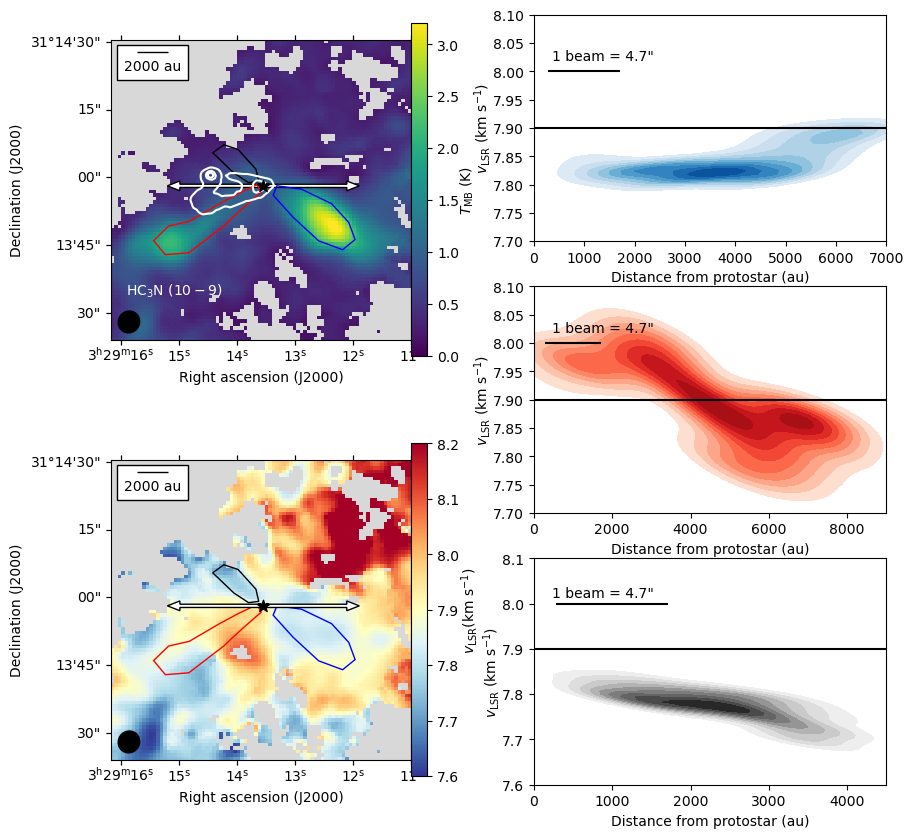

In [176]:
# fig, [ax, ax2] = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, figsize=(4,8), subplot_kw={'projection': iras4c_wcsskyhc3n})

inner_mosaic_right = [
    ["inner A"],
    ["inner B"],
    ["inner C"]
]
inner_mosaic_left = [
    ["A"],
    ["B"]
]
mosaic = [
    [inner_mosaic_left, inner_mosaic_right]
]

fig = plt.figure(figsize=(10,10))
axd = fig.subplot_mosaic(mosaic,per_subplot_kw={("A", "B"): {"projection":iras4c_wcsskyhc3n}})
# ax = fig.add_subplot(311, projection=iras4c_wcsskyhc3n)
# ax2 = fig.add_subplot(312, projection=iras4c_wcsskyhc3n)
# ax3 = fig.add_subplot(313)
contourdata, contourhead  =fits.getdata('data/IRAS4C_Spitzer_4.5_cutout.fits', header=True)
map = iras4c_hc3ncluster[0]
map2 = iras4c_hc3ncluster[1]
cmap = cm.get_cmap('viridis').copy()
cmap.set_bad('0.85')
cmap2 = cm.get_cmap('RdYlBu_r').copy()
cmap2.set_bad('0.85')
tmin=0
tmax=3.2

vmin = iras4c_vlsr-0.3
vmax = iras4c_vlsr+0.3
label = r'$T_{\mathrm{MB}}$ (K)'#r'$v_{\mathrm{LSR}}$(km s$^{-1}$)'

ax = axd['A']
sc1 = ax.imshow(map, cmap=cmap, vmin=tmin, vmax=tmax)
cb1 = fig.colorbar(sc1, ax=ax, pad=-0.002, shrink=0.95)
cb1.set_label(label, labelpad=-0.05)
#IRAS 4C
ax.arrow(catalog_protostars.loc[2, 'RAJ2000'], catalog_protostars.loc[2, 'DEJ2000'],  0.006, 0, transform=ax.get_transform('world'), fc='w', width=0.0002)
ax.arrow(catalog_protostars.loc[2, 'RAJ2000'], catalog_protostars.loc[2, 'DEJ2000'],  -0.006, 0, transform=ax.get_transform('world'), fc='w', width=0.0002)
ax.contour(contourdata, colors='w', levels=[0.8,1.6,2.4], transform=ax.get_transform(WCS(contourhead)))
ax.scatter(catalog_protostars.loc[2, 'RAJ2000'], catalog_protostars.loc[2, 'DEJ2000'], transform=ax.get_transform('world'), marker='*', s=80, ec ='k', fc='k', zorder=100)
add_beam(ax, major=bmaj, minor=bmin, angle=bpa, color='k', pad=0.1)
ax.annotate(r'HC$_3$N ($10-9$)', (0.05, 0.15), xycoords='axes fraction', fontsize=10, color='w')
add_scalebar(ax, 2000/293*u.arcsec, corner='top left', label='2000 au', frame=True)
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')
reg_load_pix1 = iras4c_region1.to_pixel(iras4c_wcsskyhc3n)
reg_load_pix1.visual['edgecolor'] = 'blue'
reg_load_pix1.plot(ax=ax)
reg_load_pix2 = iras4c_region2.to_pixel(iras4c_wcsskyhc3n)
reg_load_pix2.visual['edgecolor'] = 'red'
reg_load_pix2.plot(ax=ax)
reg_load_pix3 = iras4c_region3.to_pixel(iras4c_wcsskyhc3n)
reg_load_pix3.visual['edgecolor'] = 'black'
reg_load_pix3.plot(ax=ax)
# reg_load_pix4 = iras4c_region4.to_pixel(iras4c_wcsskyhc3n)
# reg_load_pix4.visual['edgecolor'] = 'green'
# reg_load_pix4.plot(ax=ax)

ax2 = axd['B']
sc2 = ax2.imshow(map2, cmap=cmap2, vmin=vmin, vmax=vmax)
ax2.scatter(catalog_protostars.loc[2, 'RAJ2000'], catalog_protostars.loc[2, 'DEJ2000'], transform=ax2.get_transform('world'), marker='*', s=80, ec ='k', fc='k', zorder=100)
cb2 = fig.colorbar(sc2, ax=ax2, pad=-0.002, shrink=0.95)
cb2.set_label(r'$v_{\mathrm{LSR}}$(km s$^{-1}$)', labelpad=-0.05)
lon = ax2.coords[0]
lat = ax2.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')
add_scalebar(ax2, 2000/293*u.arcsec, corner='top left', label='2000 au', frame=True)
reg_load_pix1.plot(ax=ax2)
reg_load_pix2.plot(ax=ax2)
reg_load_pix3.plot(ax=ax2)
# reg_load_pix4.plot(ax=ax2)
add_beam(ax2, major=bmaj, minor=bmin, angle=bpa, color='k', pad=0.1)

#IRAS 4C
ax2.arrow(catalog_protostars.loc[2, 'RAJ2000'], catalog_protostars.loc[2, 'DEJ2000'],  0.006, 0, transform=ax2.get_transform('world'), fc='w', width=0.0002)
ax2.arrow(catalog_protostars.loc[2, 'RAJ2000'], catalog_protostars.loc[2, 'DEJ2000'],  -0.006, 0, transform=ax2.get_transform('world'), fc='w', width=0.0002)

ax3 = axd['inner A']
xx, yy, zz = do_kde(iras4c_hc3ncluster[1], iras4c_hc3nhead, catalog_protostars.loc[2, 'RAJ2000'], catalog_protostars.loc[2, 'DEJ2000'], 
                    reg_load_pix1, 293, 0, 7000, vmin, vmax)
ax3.contourf(xx, yy, zz, cmap='Blues', levels=np.arange(0.1, 1.2, 0.1), vmin=0., vmax=1.1)
ax3.set_ylim([7.7, 8.1])
ax3.annotate('1 beam = 4.7"', (0.05, 0.8), xycoords='axes fraction')
ax4 = axd['inner B']
xx2, yy2, zz2 = do_kde(iras4c_hc3ncluster[1], iras4c_hc3nhead, catalog_protostars.loc[2, 'RAJ2000'], catalog_protostars.loc[2, 'DEJ2000'], 
                    reg_load_pix2, 293, 0, 9000, vmin, vmax)
ax4.contourf(xx2, yy2, zz2, cmap='Reds', levels=np.arange(0.1, 1.2, 0.1), vmin=0., vmax=1.1)
ax4.set_ylim([7.7, 8.1])
ax4.annotate('1 beam = 4.7"', (0.05, 0.8), xycoords='axes fraction')
ax5 = axd['inner C']
xx3, yy3, zz3 = do_kde(iras4c_hc3ncluster[1], iras4c_hc3nhead, catalog_protostars.loc[2, 'RAJ2000'], catalog_protostars.loc[2, 'DEJ2000'], 
                    reg_load_pix3, 293, 0, 4500, vmin, vmax)
ax5.contourf(xx3, yy3, zz3, cmap='Greys', levels=np.arange(0.1, 1.2, 0.1), vmin=0., vmax=1.1)
ax5.set_ylim([7.6, 8.1])
ax5.annotate('1 beam = 4.7"', (0.05, 0.83), xycoords='axes fraction')
# ax6 = axd['F']
# xx4, yy4, zz4 = do_kde(iras4c_hc3ncluster[1], iras4c_hc3nhead, catalog_protostars.loc[2, 'RAJ2000'], catalog_protostars.loc[2, 'DEJ2000'], 
#                     reg_load_pix4, 293, 0, 3500, vmin, vmax)
# ax6.contourf(xx4, yy4, zz4, cmap='Greens', levels=np.arange(0.1, 1.2, 0.1), vmin=0., vmax=1.15)
# ax6.set_ylim([7.7, 8.1])
for axx in [ax3, ax4, ax5]: #, ax6]: 
    axx.axhline(iras4c_vlsr, color='k')
# ax3.set_ylim([6.55, 7.15])
    axx.set_xlabel('Distance from protostar (au)')
    axx.set_ylabel(r'$v_{\mathrm{LSR}}$ (km s$^{-1}$)',labelpad=-0.1)
    axx.hlines(y=8.0, xmin=1000-(bmaj.to(u.arcsec).value/2*293), xmax=1000+(bmaj.to(u.arcsec).value/2*293), color='k')
    # axx.annotate('1 beam = 4.7"', (0.05, 0.8), xycoords='axes fraction')

fig.savefig('figures/zoom_iras4c_hc3n_tmb_vlsr_wspitzer.pdf', bbox_inches='tight', dpi=300)


### IRAS 2 system

In [14]:
# IRAS 2B

iras2b_hc3nclusterfile = 'analysis/protostar_cutouts/IRAS2B_HC3N_mlex1.fits'
iras2b_n2hpcubefile = 'analysis/protostar_cutouts/IRAS2B_N2Hp_cube.fits'
iras2b_regionfile = 'analysis/protostar_cutouts/candidate_region_IRAS2B.reg'

iras2b_hc3ncluster, iras2b_hc3nhead = fits.getdata(iras2b_hc3nclusterfile, header=True)
iras2b_wcsskyhc3n = WCS(iras2b_hc3nhead).celestial
iras2b_n2hpcube = SpectralCube.read(iras2b_n2hpcubefile).spectral_slab(6.2*u.km/u.s, 9.4*u.km/u.s)
iras2b_wcsskyn2hp = WCS(iras2b_n2hpcube.header).celestial
iras2b_n2hpmom0 = iras2b_n2hpcube.moment(order=0)
iras2b_region = Regions.read(iras2b_regionfile)[0]
iras2b_vlsr = catalog_protostars.loc[5, 'vlsr']

/tmp/ipykernel_6193/2393915517.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis').copy()
/tmp/ipykernel_6193/2393915517.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap('RdYlBu_r').copy()
/tmp/ipykernel_6193/2412344006.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  centerxsmall, centerysmall = int(centerxsmall), int(centerysmall)


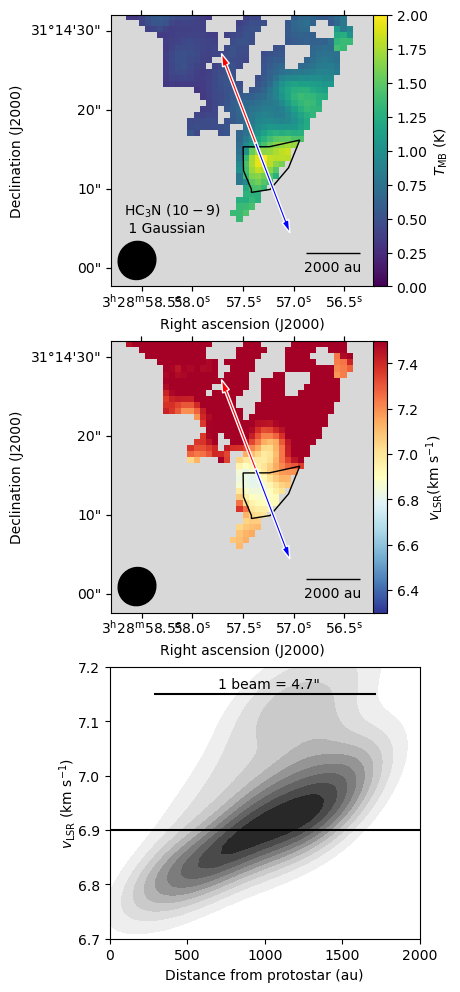

In [72]:
fig = plt.figure(figsize=(4,12))
ax = fig.add_subplot(311, projection=iras2b_wcsskyhc3n)
map = iras2b_hc3ncluster[0]
map2 = iras2b_hc3ncluster[1]
cmap = cm.get_cmap('viridis').copy()
cmap.set_bad('0.85')
cmap2 = cm.get_cmap('RdYlBu_r').copy()
cmap2.set_bad('0.85')
tmin=0
tmax=2

vmin = iras2b_vlsr-0.6
vmax = iras2b_vlsr+0.6
label = r'$T_{\mathrm{MB}}$ (K)'#r'$v_{\mathrm{LSR}}$(km s$^{-1}$)'

sc1 = ax.imshow(map, cmap=cmap, vmin=tmin, vmax=tmax)
fig.colorbar(sc1, ax=ax, label=label, pad=-0.002)
reg_load_pix = iras2b_region.to_pixel(iras2b_wcsskyhc3n)
reg_load_pix.visual['edgecolor'] = 'black'
reg_load_pix.plot(ax=ax)
ax.scatter(catalog_protostars.loc[4, 'RAJ2000'], catalog_protostars.loc[4, 'DEJ2000'], transform=ax.get_transform('world'), marker='*', s=80, ec ='k', fc='None')
add_beam(ax, major=bmaj, minor=bmin, angle=bpa, color='k', pad=0.1)
ax.annotate('HC$_3$N ($10-9$) \n 1 Gaussian', (0.05, 0.2), xycoords='axes fraction', fontsize=10)
add_scalebar(ax, 2000/293*u.arcsec, corner='bottom right', label='2000 au')
# outflow
ax.arrow(catalog_protostars.loc[5, 'RAJ2000'], catalog_protostars.loc[5, 'DEJ2000'],  0.003*np.sin((24*u.deg).to(u.rad).value), 0.003*np.cos((24*u.deg).to(u.rad).value), transform=ax.get_transform('world'), fc='r', ec='w', width=0.0001)
ax.arrow(catalog_protostars.loc[5, 'RAJ2000'], catalog_protostars.loc[5, 'DEJ2000'],  -0.003*np.sin((24*u.deg).to(u.rad).value), -0.003*np.cos((24*u.deg).to(u.rad).value), transform=ax.get_transform('world'), fc='b', ec='w', width=0.0001)
# ax.arrow(catalog_protostars.loc[4, 'RAJ2000'], catalog_protostars.loc[4, 'DEJ2000'],  0.004*np.sin((105*u.deg).to(u.rad).value), 0.004*np.cos((105*u.deg).to(u.rad).value), transform=ax.get_transform('world'), fc='r', ec='w', width=0.0002)
# ax.arrow(catalog_protostars.loc[4, 'RAJ2000'], catalog_protostars.loc[4, 'DEJ2000'],  -0.004*np.sin((105*u.deg).to(u.rad).value), -0.004*np.cos((105*u.deg).to(u.rad).value), transform=ax.get_transform('world'), fc='b', ec='w', width=0.0002)
ax.set_facecolor('0.85')
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')
ax.set_xlim([20, np.shape(map)[1]])
ax.set_ylim([20, np.shape(map)[0]*3/4])

ax3 = fig.add_subplot(312, projection=iras2b_wcsskyhc3n)
sc2 = ax3.imshow(map2, cmap=cmap2, vmin=vmin, vmax=vmax)
fig.colorbar(sc2, ax=ax3, label=r'$v_{\mathrm{LSR}}$(km s$^{-1}$)', pad=-0.002)
reg_load_pix.plot(ax=ax3)
ax3.scatter(catalog_protostars.loc[4, 'RAJ2000'], catalog_protostars.loc[4, 'DEJ2000'], transform=ax3.get_transform('world'), marker='*', s=80, ec ='k', fc='None')
# outflow
ax3.arrow(catalog_protostars.loc[5, 'RAJ2000'], catalog_protostars.loc[5, 'DEJ2000'],  0.003*np.sin((24*u.deg).to(u.rad).value), 0.003*np.cos((24*u.deg).to(u.rad).value), transform=ax3.get_transform('world'), fc='r', ec='w', width=0.0001)
ax3.arrow(catalog_protostars.loc[5, 'RAJ2000'], catalog_protostars.loc[5, 'DEJ2000'],  -0.003*np.sin((24*u.deg).to(u.rad).value), -0.003*np.cos((24*u.deg).to(u.rad).value), transform=ax3.get_transform('world'), fc='b', ec='w', width=0.0001)
# ax3.arrow(catalog_protostars.loc[4, 'RAJ2000'], catalog_protostars.loc[4, 'DEJ2000'],  0.004*np.sin((105*u.deg).to(u.rad).value), 0.004*np.cos((105*u.deg).to(u.rad).value), transform=ax3.get_transform('world'), fc='r', ec='w', width=0.0002)
# ax3.arrow(catalog_protostars.loc[4, 'RAJ2000'], catalog_protostars.loc[4, 'DEJ2000'],  -0.004*np.sin((105*u.deg).to(u.rad).value), -0.004*np.cos((105*u.deg).to(u.rad).value), transform=ax3.get_transform('world'), fc='b', ec='w', width=0.0002)
ax3.set_facecolor('0.85')
ax3.set_xlim([20, np.shape(map)[1]])
ax3.set_ylim([20, np.shape(map)[0]*3/4])
lon = ax3.coords[0]
lat = ax3.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')
add_beam(ax3, major=bmaj, minor=bmin, angle=bpa, color='k', pad=0.1)
add_scalebar(ax3, 2000/293*u.arcsec, corner='bottom right', label='2000 au')

xx, yy, zz = do_kde(iras2b_hc3ncluster[1], iras2b_hc3nhead, catalog_protostars.loc[5, 'RAJ2000'], catalog_protostars.loc[5, 'DEJ2000'], 
                    reg_load_pix, 293, 0, 2000, vmin, vmax)

ax2 = fig.add_subplot(313)
ax2.contourf(xx, yy, zz, cmap='Greys', levels=np.arange(0.1, 1.2, 0.1), vmin=0., vmax=1.1)
ax2.axhline(iras2b_vlsr, color='k')
ax2.set_ylim([6.7, 7.2])
ax2.set_xlabel('Distance from protostar (au)')
ax2.set_ylabel(r'$v_{\mathrm{LSR}}$ (km s$^{-1}$)',labelpad=-0.1)
ax2.hlines(y=7.15, xmin=1000-(bmaj.to(u.arcsec).value/2*293), xmax=1000+(bmaj.to(u.arcsec).value/2*293), color='k')
ax2.annotate('1 beam = 4.7"', (0.35, 0.92), xycoords='axes fraction')

fig.savefig('figures/zoom_iras2b_hc3n_tmb.pdf', bbox_inches='tight', dpi=300)


/tmp/ipykernel_38044/3999638614.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis').copy()


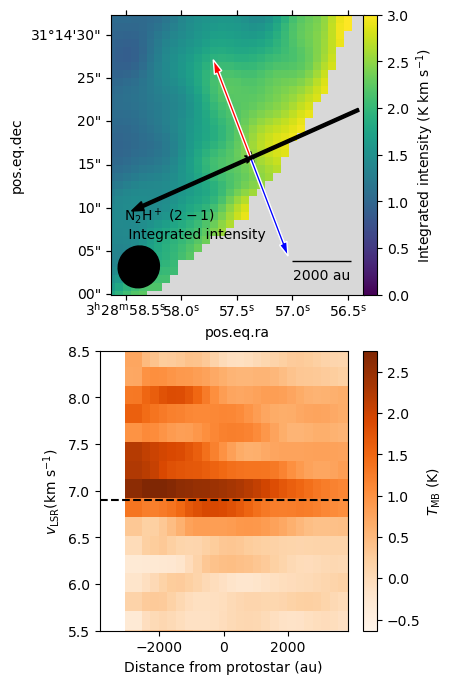

In [22]:
#n2hp map

fig = plt.figure(figsize=(4,8))
ax = fig.add_subplot(211, projection=iras2b_wcsskyn2hp)
map = iras2b_n2hpmom0.data
cmap = cm.get_cmap('viridis').copy()
cmap.set_bad('0.85')
label = r'Integrated intensity (K km s$^{-1}$)'#r'$v_{\mathrm{LSR}}$(km s$^{-1}$)'
tmin=0
tmax=3

sc1 = ax.imshow(map, cmap=cmap, vmin=tmin, vmax=tmax)
fig.colorbar(sc1, ax=ax, label=label, pad=-0.002)
ax.scatter(catalog_protostars.loc[5, 'RAJ2000'], catalog_protostars.loc[5, 'DEJ2000'], transform=ax.get_transform('world'), marker='*', s=80, ec ='k', fc='None')
add_beam(ax, major=bmaj, minor=bmin, angle=bpa, color='k', pad=0.1)
ax.annotate('N$_2$H$^+$ ($2-1$) \n Integrated intensity', (0.05, 0.2), xycoords='axes fraction', fontsize=10)
add_scalebar(ax, 2000/293*u.arcsec, corner='bottom right', label='2000 au')
# outflow
ax.arrow(catalog_protostars.loc[5, 'RAJ2000'], catalog_protostars.loc[5, 'DEJ2000'],  0.003*np.sin((24*u.deg).to(u.rad).value), 0.003*np.cos((24*u.deg).to(u.rad).value), transform=ax.get_transform('world'), fc='r', ec='w', width=0.0001)
ax.arrow(catalog_protostars.loc[5, 'RAJ2000'], catalog_protostars.loc[5, 'DEJ2000'],  -0.003*np.sin((24*u.deg).to(u.rad).value), -0.003*np.cos((24*u.deg).to(u.rad).value), transform=ax.get_transform('world'), fc='b', ec='w', width=0.0001)
ax.arrow(catalog_protostars.loc[4, 'RAJ2000'], catalog_protostars.loc[4, 'DEJ2000'],  0.004*np.sin((105*u.deg).to(u.rad).value), 0.004*np.cos((105*u.deg).to(u.rad).value), transform=ax.get_transform('world'), fc='r', ec='w', width=0.0002)
ax.arrow(catalog_protostars.loc[4, 'RAJ2000'], catalog_protostars.loc[4, 'DEJ2000'],  -0.004*np.sin((105*u.deg).to(u.rad).value), -0.004*np.cos((105*u.deg).to(u.rad).value), transform=ax.get_transform('world'), fc='b', ec='w', width=0.0002)
ax.set_facecolor('0.85')
ax.set_xlim([20, np.shape(map)[1]-10])
ax.set_ylim([20, np.shape(map)[0]*3/4])


pvarcsecfilename = 'analysis/protostar_cutouts/IRAS2B_N2Hp_pvdiag_arcsec.fits'
pvdata, pvheader = fits.getdata(pvarcsecfilename, header=True)
pa_angle = (24+90)*u.deg #degrees from north
centerxdeg, centerydeg = catalog_protostars.loc[5, 'RAJ2000']*u.deg, catalog_protostars.loc[5, 'DEJ2000']*u.deg
length = (8000 / 293 *u.arcsec).to(u.deg)
pathcenter = PathFromCenter(SkyCoord(centerxdeg, centerydeg), length, angle=pa_angle)
pathcoords = pathcenter._coords

ax.arrow(pathcoords.ra.value[0], pathcoords.dec.value[0], pathcoords.ra.value[1]-pathcoords.ra.value[0],  pathcoords.dec.value[1]- pathcoords.dec.value[0],
        width=0.0001, color='k', transform=ax.get_transform('world'))
ax3 = fig.add_subplot(212)
delta0 = pvheader['CRVAL1']
delta_delta = pvheader['CDELT1']
delta_pix0 = pvheader['CRPIX1']
delta_npix = pvheader['NAXIS1']
vel0 = pvheader['CRVAL2']
delta_vel = pvheader['CDELT2']
vel_pix0 = pvheader['CRPIX2']
vel_npix = pvheader['NAXIS2']
delta_array = np.array([delta0 + delta_delta*(i-delta_pix0) for i in range(delta_npix)]) * u.arcsec
vel_array = np.array([vel0 + delta_vel * (i - vel_pix0) for i in range(vel_npix)]) * u.m/u.s
vel_array = vel_array.to(u.km/u.s)
distance_array = (delta_array).value * 293 * u.au 
# we create the meshgrid to plot
offset, vel = np.meshgrid(distance_array, vel_array)

pcolor = ax3.pcolor(offset.value, vel.value, pvdata, shading='auto', cmap='Oranges')
# ax3.axhline(per15_vlsr, color='k', ls=':', alpha=0.5)
ax3.axhline(iras2b_vlsr, color='k', linestyle='dashed')
ax3.set_xlabel('Distance from protostar (au)')
ax3.set_ylabel(r'$v_{\mathrm{LSR}}$(km s$^{-1}$)')
# ax3.invert_xaxis()
fig.colorbar(pcolor, ax=ax3, label=r'$T_{\mathrm{MB}}$ (K)')
ax3.set_ylim([5.5,8.5])
fig.savefig('figures/zoom_iras2b_n2hp_tmb_vlsr.pdf', bbox_inches='tight', dpi=300)

### SVS13


In [15]:
# SK 15

sk15_hc3nclusterfile = 'analysis/protostar_cutouts/SK15_HC3N_mlex2.fits'
sk15_n2hpclusterfile = 'analysis/protostar_cutouts/SK15_N2Hp_mlex2.fits'
sk15_regionfile = 'analysis/protostar_cutouts/candidate_region_SK15.reg'

sk15_hc3ncluster, sk15_hc3nhead = fits.getdata(sk15_hc3nclusterfile, header=True)
sk15_n2hpcluster, sk15_n2hphead = fits.getdata(sk15_n2hpclusterfile, header=True)
sk15_wcsskyhc3n = WCS(sk15_hc3nhead).celestial
sk15_wcsskyn2hp = WCS(sk15_n2hphead).celestial
sk15_region = Regions.read(sk15_regionfile)[0]
sk15_vlsr = catalog_protostars.loc[13, 'vlsr']

/tmp/ipykernel_356/2544723191.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis').copy()
/tmp/ipykernel_356/2412344006.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  centerxsmall, centerysmall = int(centerxsmall), int(centerysmall)


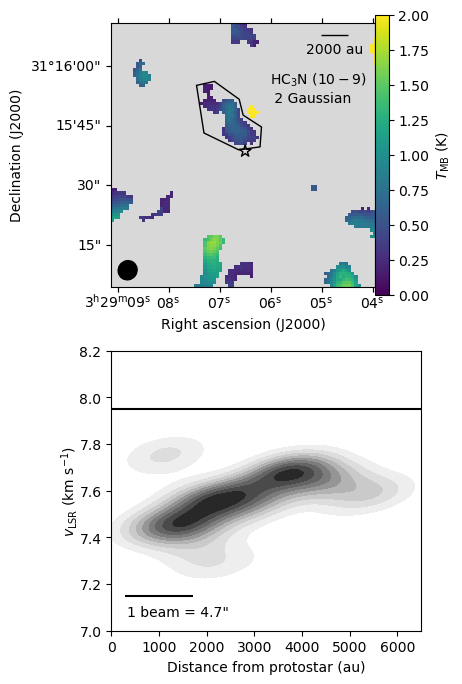

In [56]:
fig = plt.figure(figsize=(4,8))
ax = fig.add_subplot(211, projection=sk15_wcsskyhc3n)
map = sk15_hc3ncluster[0]
cmap = cm.get_cmap('viridis').copy()
cmap.set_bad('0.85')
tmin=0
tmax=2
vmin = 7
vmax = 8.2
label = r'$T_{\mathrm{MB}}$ (K)'#r'$v_{\mathrm{LSR}}$(km s$^{-1}$)'

sc1 = ax.imshow(map, cmap=cmap, vmin=tmin, vmax=tmax)
fig.colorbar(sc1, ax=ax, label=label, pad=-0.002)
reg_load_pix = sk15_region.to_pixel(sk15_wcsskyhc3n)
reg_load_pix.visual['edgecolor'] = 'black'
reg_load_pix.plot(ax=ax, zorder=100)
ax.scatter(catalog_protostars.loc[13, 'RAJ2000'], catalog_protostars.loc[13, 'DEJ2000'], transform=ax.get_transform('world'), marker='*', s=80, ec ='k', fc='None')
add_beam(ax, major=bmaj, minor=bmin, angle=bpa, color='k', pad=0.1)
ax.annotate('HC$_3$N ($10-9$)\n 2 Gaussian', (0.6, 0.7), xycoords='axes fraction', fontsize=10, color='k')
# ax.annotate('N$_2$H$^+$ ($1-0$)\n Cluster 0', (0.6, 0.55), xycoords='axes fraction', fontsize=10, color='w')

add_scalebar(ax, 2000/293*u.arcsec, corner='top right', label='2000 au')
# ax.contour(sk15_n2hpcluster[0], transform=ax.get_transform(WCS(sk15_n2hphead).celestial), levels=[2,3,4,5], colors='w')

lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')

xx, yy, zz = do_kde(sk15_hc3ncluster[1], sk15_hc3nhead, catalog_protostars.loc[13, 'RAJ2000'], catalog_protostars.loc[13, 'DEJ2000'], 
                    reg_load_pix, 293, 0, 6500, vmin, vmax)

ax2 = fig.add_subplot(212)
ax2.contourf(xx, yy, zz, cmap='Greys', levels=np.arange(0.1, 1.2, 0.1), vmin=0., vmax=1.1)
ax2.axhline(sk15_vlsr, color='k')
ax2.set_ylim([vmin, vmax])
ax2.set_xlabel('Distance from protostar (au)')
ax2.set_ylabel(r'$v_{\mathrm{LSR}}$ (km s$^{-1}$)',labelpad=-0.1)
ax2.hlines(y=7.15, xmin=1000-(bmaj.to(u.arcsec).value/2*293), xmax=1000+(bmaj.to(u.arcsec).value/2*293), color='k')
ax2.annotate('1 beam = 4.7"', (0.05, 0.05), xycoords='axes fraction')

fig.savefig('figures/zoom_sk15_hc3n_tmb.pdf', bbox_inches='tight', dpi=300)


/tmp/ipykernel_356/3801905013.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis').copy()
/tmp/ipykernel_356/2412344006.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  centerxsmall, centerysmall = int(centerxsmall), int(centerysmall)
/tmp/ipykernel_356/2412344006.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  centerxsmall, centerysmall = int(centerxsmall), int(centerysmall)


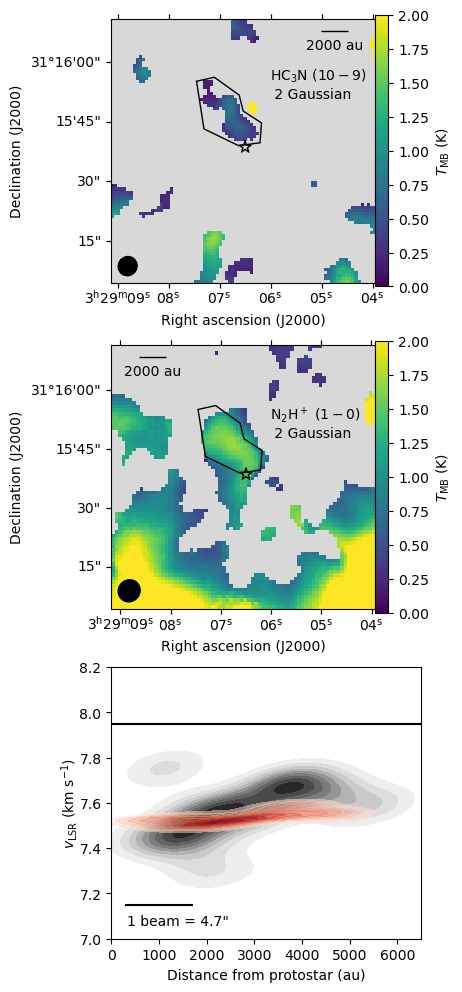

In [57]:
fig = plt.figure(figsize=(4,12))
ax = fig.add_subplot(311, projection=sk15_wcsskyhc3n)
map = sk15_hc3ncluster[0]
cmap = cm.get_cmap('viridis').copy()
cmap.set_bad('0.85')
tmin=0
tmax=2
vmin = 7
vmax = 8.2
label = r'$T_{\mathrm{MB}}$ (K)'#r'$v_{\mathrm{LSR}}$(km s$^{-1}$)'


sc1 = ax.imshow(map, cmap=cmap, vmin=tmin, vmax=tmax)
fig.colorbar(sc1, ax=ax, label=label, pad=-0.002)
reg_load_pix = sk15_region.to_pixel(sk15_wcsskyhc3n)
reg_load_pix.visual['edgecolor'] = 'black'
reg_load_pix.plot(ax=ax, zorder=100)
ax.scatter(catalog_protostars.loc[13, 'RAJ2000'], catalog_protostars.loc[13, 'DEJ2000'], transform=ax.get_transform('world'), marker='*', s=80, ec ='k', fc='None')
add_beam(ax, major=bmaj, minor=bmin, angle=bpa, color='k', pad=0.1)
ax.annotate('HC$_3$N ($10-9$)\n 2 Gaussian', (0.6, 0.7), xycoords='axes fraction', fontsize=10, color='k')
# ax.annotate('N$_2$H$^+$ ($1-0$)\n Cluster 0', (0.6, 0.55), xycoords='axes fraction', fontsize=10, color='w')

add_scalebar(ax, 2000/293*u.arcsec, corner='top right', label='2000 au')
# ax.contour(sk15_n2hpcluster[0], transform=ax.get_transform(WCS(sk15_n2hphead).celestial), levels=[2,3,4,5], colors='w')

lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')

ax2 = fig.add_subplot(312, projection=sk15_wcsskyn2hp)
map2 = sk15_n2hpcluster[0]
sc2 = ax2.imshow(map2, cmap=cmap, vmin=tmin, vmax=tmax)
fig.colorbar(sc2, ax=ax2, label=label, pad=-0.002)
reg_load_pix2 = sk15_region.to_pixel(sk15_wcsskyn2hp)
reg_load_pix2.visual['edgecolor'] = 'black'
reg_load_pix2.plot(ax=ax2, zorder=100)
ax2.scatter(catalog_protostars.loc[13, 'RAJ2000'], catalog_protostars.loc[13, 'DEJ2000'], transform=ax2.get_transform('world'), marker='*', s=80, ec ='k', fc='None')
add_beam(ax2, major=bmajn2hp, minor=bminn2hp, angle=bpan2hp, color='k', pad=0.1)
ax2.annotate('N$_2$H$^+$ ($1-0$)\n 2 Gaussian', (0.6, 0.65), xycoords='axes fraction', fontsize=10, color='k')
# ax.annotate('N$_2$H$^+$ ($1-0$)\n Cluster 0', (0.6, 0.55), xycoords='axes fraction', fontsize=10, color='w')

add_scalebar(ax2, 2000/293*u.arcsec, corner='top left', label='2000 au')
# ax.contour(sk15_n2hpcluster[0], transform=ax.get_transform(WCS(sk15_n2hphead).celestial), levels=[2,3,4,5], colors='w')

lon = ax2.coords[0]
lat = ax2.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')

xx, yy, zz = do_kde(sk15_hc3ncluster[1], sk15_hc3nhead, catalog_protostars.loc[13, 'RAJ2000'], catalog_protostars.loc[13, 'DEJ2000'], 
                    reg_load_pix, 293, 0, 6500, vmin, vmax)
xx2, yy2, zz2 = do_kde(sk15_n2hpcluster[1], sk15_n2hphead, catalog_protostars.loc[13, 'RAJ2000'], catalog_protostars.loc[13, 'DEJ2000'], 
                    reg_load_pix2, 293, 0, 6500, vmin, vmax)

ax3 = fig.add_subplot(313)
ax3.contourf(xx, yy, zz, cmap='Greys', levels=np.arange(0.1, 1.2, 0.1), vmin=0., vmax=1.1)
ax3.contourf(xx2, yy2, zz2, cmap='Reds', levels=np.arange(0.1, 1.2, 0.1), vmin=0., vmax=1.1, alpha=0.5)
ax3.axhline(sk15_vlsr, color='k')
ax3.set_ylim([vmin, vmax])
ax3.set_xlabel('Distance from protostar (au)')
ax3.set_ylabel(r'$v_{\mathrm{LSR}}$ (km s$^{-1}$)',labelpad=-0.1)
ax3.hlines(y=7.15, xmin=1000-(bmaj.to(u.arcsec).value/2*293), xmax=1000+(bmaj.to(u.arcsec).value/2*293), color='k')
ax3.annotate('1 beam = 4.7"', (0.05, 0.05), xycoords='axes fraction')

fig.savefig('figures/zoom_sk15_hc3n_tmb_wn2hp.pdf', bbox_inches='tight', dpi=300)


In [16]:
# SK 14 -Per-emb-15

per15_hc3nclusterfile = 'analysis/protostar_cutouts/Per-emb-15_HC3N_mlex1.fits'
per15_n2hpclusterfile = 'analysis/protostar_cutouts/Per-emb-15_N2Hp_cluster2.fits'
per15_regionfile = 'analysis/protostar_cutouts/candidate_region_Peremb15.reg'

per15_hc3ncluster, per15_hc3nhead = fits.getdata(per15_hc3nclusterfile, header=True)
per15_wcsskyhc3n = WCS(per15_hc3nhead).celestial
per15_n2hpcluster, per15_n2hphead = fits.getdata(per15_n2hpclusterfile, header=True)
per15_region = Regions.read(per15_regionfile)[0]
per15_vlsr = catalog_protostars.loc[3, 'vlsr']

/tmp/ipykernel_6193/3747833938.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis').copy()
/tmp/ipykernel_6193/3747833938.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap('RdYlBu_r').copy()
/tmp/ipykernel_6193/2412344006.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  centerxsmall, centerysmall = int(centerxsmall), int(centerysmall)


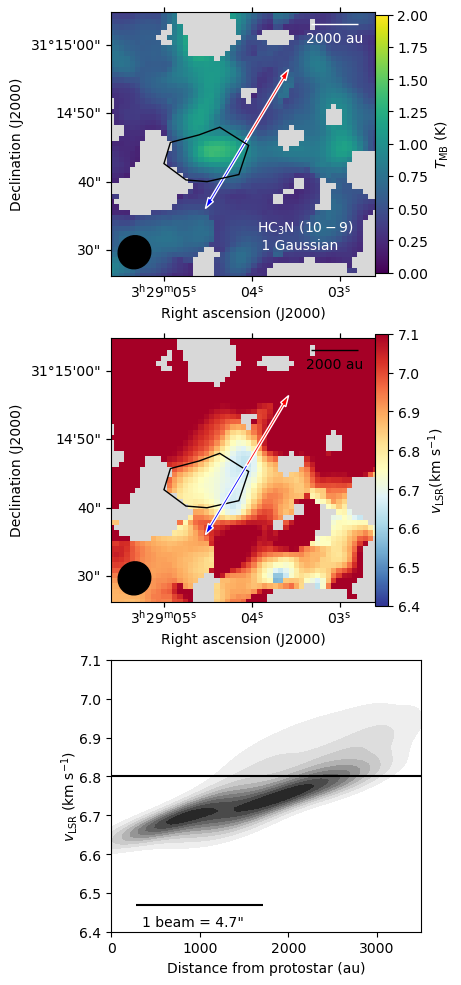

In [82]:
fig = plt.figure(figsize=(4,12))
ax = fig.add_subplot(311, projection=per15_wcsskyhc3n)
map = per15_hc3ncluster[0]
map2 = per15_hc3ncluster[1]
cmap = cm.get_cmap('viridis').copy()
cmap.set_bad('0.85')
cmap2 = cm.get_cmap('RdYlBu_r').copy()
cmap2.set_bad('0.85')
tmin=0
tmax=2
vmin = 6.4
vmax = 7.1
label = r'$T_{\mathrm{MB}}$ (K)'#r'$v_{\mathrm{LSR}}$(km s$^{-1}$)'

sc1 = ax.imshow(map, cmap=cmap, vmin=tmin, vmax=tmax)
fig.colorbar(sc1, ax=ax, label=label, pad=-0.002, shrink=0.95)
reg_load_pix = per15_region.to_pixel(per15_wcsskyhc3n)
reg_load_pix.visual['edgecolor'] = 'black'
reg_load_pix.plot(ax=ax, zorder=100)
add_beam(ax, major=bmaj, minor=bmin, angle=bpa, color='k', pad=0.1)
ax.annotate('HC$_3$N ($10-9$)\n 1 Gaussian', (0.55, 0.1), xycoords='axes fraction', fontsize=10, color='w')
# ax.annotate('N$_2$H$^+$ ($1-0$)\n Cluster 0', (0.6, 0.55), xycoords='axes fraction', fontsize=10, color='w')
add_scalebar(ax, 2000/293*u.arcsec, corner='top right', label='2000 au', color='w')
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')
# outflow
ax.arrow(catalog_protostars.loc[3, 'RAJ2000'], catalog_protostars.loc[3, 'DEJ2000'],  0.003*np.sin((145*u.deg).to(u.rad).value), 0.003*np.cos((145*u.deg).to(u.rad).value), transform=ax.get_transform('world'), fc='b', ec='w', width=0.0001)
ax.arrow(catalog_protostars.loc[3, 'RAJ2000'], catalog_protostars.loc[3, 'DEJ2000'],  -0.003*np.sin((145*u.deg).to(u.rad).value), -0.003*np.cos((145*u.deg).to(u.rad).value), transform=ax.get_transform('world'), fc='r', ec='w', width=0.0001)
ax.set_xlim([18, np.shape(map)[1]-18])
ax.set_ylim([18, np.shape(map)[0]-18])

ax3 = fig.add_subplot(312, projection=per15_wcsskyhc3n)
sc2 = ax3.imshow(map2, cmap=cmap2, vmin=vmin, vmax=vmax)
fig.colorbar(sc2, ax=ax3, label=r'$v_{\mathrm{LSR}}$(km s$^{-1}$)', pad=-0.002)
reg_load_pix.plot(ax=ax3)
# outflow
ax3.arrow(catalog_protostars.loc[3, 'RAJ2000'], catalog_protostars.loc[3, 'DEJ2000'],  0.003*np.sin((145*u.deg).to(u.rad).value), 0.003*np.cos((145*u.deg).to(u.rad).value), transform=ax3.get_transform('world'), fc='b', ec='w', width=0.0001)
ax3.arrow(catalog_protostars.loc[3, 'RAJ2000'], catalog_protostars.loc[3, 'DEJ2000'],  -0.003*np.sin((145*u.deg).to(u.rad).value), -0.003*np.cos((145*u.deg).to(u.rad).value), transform=ax3.get_transform('world'), fc='r', ec='w', width=0.0001)
lon = ax3.coords[0]
lat = ax3.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')
ax3.set_xlim([18, np.shape(map)[1]-18])
ax3.set_ylim([18, np.shape(map)[0]-18])
add_scalebar(ax3, 2000/293*u.arcsec, corner='top right', label='2000 au', color='k')
add_beam(ax3, major=bmaj, minor=bmin, angle=bpa, color='k', pad=0.1)

xx, yy, zz = do_kde(per15_hc3ncluster[1], per15_hc3nhead, catalog_protostars.loc[3, 'RAJ2000'], catalog_protostars.loc[3, 'DEJ2000'], 
                    reg_load_pix, 293, 0, 3500, vmin, vmax)
ax2 = fig.add_subplot(313)
ax2.contourf(xx, yy, zz, cmap='Greys', levels=np.arange(0.1, 1.2, 0.1), vmin=0., vmax=1.1)
ax2.axhline(per15_vlsr, color='k')
ax2.set_ylim([vmin, vmax])
ax2.set_xlabel('Distance from protostar (au)')
ax2.set_ylabel(r'$v_{\mathrm{LSR}}$ (km s$^{-1}$)',labelpad=-0.1)
ax2.hlines(y=6.47, xmin=1000-(bmaj.to(u.arcsec).value/2*293), xmax=1000+(bmaj.to(u.arcsec).value/2*293), color='k')
ax2.annotate('1 beam = 4.7"', (0.1, 0.02), xycoords='axes fraction')

fig.savefig('figures/zoom_per15_hc3n_tmb.pdf', bbox_inches='tight', dpi=300)


/tmp/ipykernel_5410/349675544.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdYlBu_r').copy()
/tmp/ipykernel_5410/349675544.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis').copy()


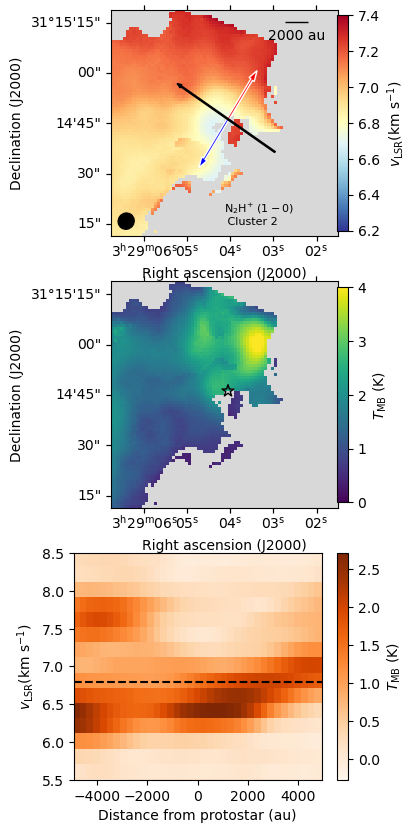

In [60]:
wcssky_n2hp = WCS(per15_n2hphead).celestial
fig = plt.figure(figsize=(4,10))
ax = fig.add_subplot(311, projection=wcssky_n2hp)
map = per15_n2hpcluster[1]
cmap = cm.get_cmap('RdYlBu_r').copy()
cmap.set_bad('0.85')
vmin = per15_vlsr-0.6
vmax = per15_vlsr+0.6

label = r'$v_{\mathrm{LSR}}$(km s$^{-1}$)'

sc1 = ax.imshow(map, cmap=cmap, vmin=vmin, vmax=vmax)
fig.colorbar(sc1, ax=ax, label=label, pad=-0.002, shrink=0.95)
#ax.scatter(catalog_protostars.loc[1, 'RAJ2000'], catalog_protostars.loc[1, 'DEJ2000'], transform=ax.get_transform('world'), marker='*', s=80, ec ='k', fc='None')
add_beam(ax, major=bmaj, minor=bmin, angle=bpa, color='k', pad=0.1)
ax.annotate('N$_2$H$^{+}$ ($1-0$)\n Cluster 2', (0.5, 0.05), xycoords='axes fraction', fontsize=8)
add_scalebar(ax, 2000/293*u.arcsec, corner='top right', label='2000 au')
# outflow
ax.arrow(catalog_protostars.loc[3, 'RAJ2000'], catalog_protostars.loc[3, 'DEJ2000'],  0.004*np.sin((145*u.deg).to(u.rad).value), 0.004*np.cos((145*u.deg).to(u.rad).value), transform=ax.get_transform('world'), fc='b', ec='w', width=0.0002)
ax.arrow(catalog_protostars.loc[3, 'RAJ2000'], catalog_protostars.loc[3, 'DEJ2000'],  -0.004*np.sin((145*u.deg).to(u.rad).value), -0.004*np.cos((145*u.deg).to(u.rad).value), transform=ax.get_transform('world'), fc='r', ec='w', width=0.0002)
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')

ax2 = fig.add_subplot(312, projection=wcssky_n2hp)
map = per15_n2hpcluster[0]
cmap = cm.get_cmap('viridis').copy()
cmap.set_bad('0.85')
tmin=0
tmax=4
sc2 = ax2.imshow(map, cmap=cmap, vmin=tmin, vmax=tmax)
fig.colorbar(sc2, ax=ax2, label=r'$T_{\mathrm{MB}}$ (K)', pad=-0.002, shrink=0.95)
ax2.scatter(catalog_protostars.loc[3, 'RAJ2000'], catalog_protostars.loc[3, 'DEJ2000'], transform=ax2.get_transform('world'), marker='*', s=80, ec ='k', fc='None')
lon = ax2.coords[0]
lat = ax2.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')

pvarcsecfilename = 'analysis/protostar_cutouts/Per-emb-15_N2Hp_pvdiag_arcsec.fits'
pvdata, pvheader = fits.getdata(pvarcsecfilename, header=True)
pa_angle = (-35+90)*u.deg #degrees from north
centerxdeg, centerydeg = catalog_protostars.loc[3, 'RAJ2000']*u.deg, catalog_protostars.loc[3, 'DEJ2000']*u.deg
length = (10000 / 293 *u.arcsec).to(u.deg)
pathcenter = PathFromCenter(SkyCoord(centerxdeg, centerydeg), length, angle=pa_angle)
pathcoords = pathcenter._coords

ax.arrow(pathcoords.ra.value[0], pathcoords.dec.value[0], pathcoords.ra.value[1]-pathcoords.ra.value[0],  pathcoords.dec.value[1]- pathcoords.dec.value[0],
        width=0.0001, color='k', transform=ax.get_transform('world'))
ax3 = fig.add_subplot(313)
delta0 = pvheader['CRVAL1']
delta_delta = pvheader['CDELT1']
delta_pix0 = pvheader['CRPIX1']
delta_npix = pvheader['NAXIS1']
vel0 = pvheader['CRVAL2']
delta_vel = pvheader['CDELT2']
vel_pix0 = pvheader['CRPIX2']
vel_npix = pvheader['NAXIS2']
delta_array = np.array([delta0 + delta_delta*(i-delta_pix0) for i in range(delta_npix)]) * u.arcsec
vel_array = np.array([vel0 + delta_vel * (i - vel_pix0) for i in range(vel_npix)]) * u.m/u.s
vel_array = vel_array.to(u.km/u.s)
distance_array = (delta_array).value * 293 * u.au 
# we create the meshgrid to plot
offset, vel = np.meshgrid(distance_array, vel_array)

pcolor = ax3.pcolor(offset.value, vel.value, pvdata, shading='auto', cmap='Oranges')
# ax3.axhline(per15_vlsr, color='k', ls=':', alpha=0.5)
ax3.axhline(per15_vlsr, color='k', linestyle='dashed')
ax3.set_xlabel('Distance from protostar (au)')
ax3.set_ylabel(r'$v_{\mathrm{LSR}}$(km s$^{-1}$)')
# ax3.invert_xaxis()
fig.colorbar(pcolor, ax=ax3, label=r'$T_{\mathrm{MB}}$ (K)')
ax3.set_ylim([5.5,8.5])
fig.savefig('figures/zoom_per15_n2hp_tmb_vlsr.pdf', bbox_inches='tight', dpi=300)

In [17]:
# VLA3
vla3_hc3nclusterfile = 'analysis/protostar_cutouts/VLA3_HC3N_mlex2.fits'
vla3_n2hpclusterfile = 'analysis/protostar_cutouts/VLA3_N2Hp_mlex2.fits'
vla3_regionfile = 'analysis/protostar_cutouts/candidate_region_VLA3.reg'

vla3_hc3ncluster, vla3_hc3nhead = fits.getdata(vla3_hc3nclusterfile, header=True)
vla3_wcsskyhc3n = WCS(vla3_hc3nhead).celestial
vla3_n2hpcluster, vla3_n2hphead = fits.getdata(vla3_n2hpclusterfile, header=True)
vla3_wcsskyn2hp = WCS(vla3_n2hphead).celestial
vla3_region = Regions.read(vla3_regionfile)[0]
vla3_vlsr = catalog_protostars.loc[12, 'vlsr']

/tmp/ipykernel_5410/1417476981.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis').copy()
/tmp/ipykernel_5410/2412344006.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  centerxsmall, centerysmall = int(centerxsmall), int(centerysmall)
/tmp/ipykernel_5410/2412344006.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  centerxsmall, centerysmall = int(centerxsmall), int(centerysmall)


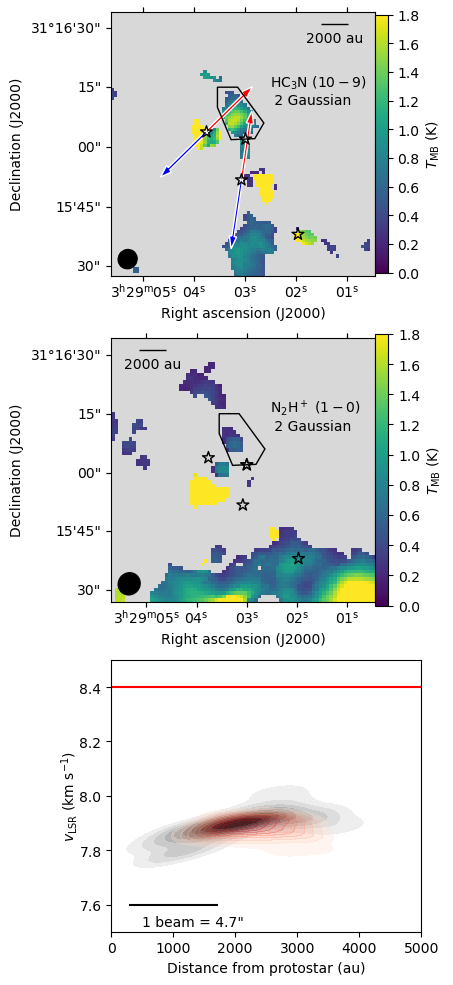

In [63]:
fig = plt.figure(figsize=(4,12))
ax = fig.add_subplot(311, projection=vla3_wcsskyhc3n)
map = vla3_hc3ncluster[0]
cmap = cm.get_cmap('viridis').copy()
cmap.set_bad('0.85')
tmin = 0
tmax = 1.8
vmin = 7.5
vmax = 8.5
label = r'$T_{\mathrm{MB}}$ (K)'#r'$v_{\mathrm{LSR}}$(km s$^{-1}$)'

sc1 = ax.imshow(map, cmap=cmap, vmin=tmin, vmax=tmax)
fig.colorbar(sc1, ax=ax, label=label, pad=-0.002, shrink=0.95)
reg_load_pix = vla3_region.to_pixel(vla3_wcsskyhc3n)
reg_load_pix.visual['edgecolor'] = 'black'
reg_load_pix.plot(ax=ax, zorder=100)
ax.scatter(catalog_protostars.loc[12, 'RAJ2000'], catalog_protostars.loc[12, 'DEJ2000'], transform=ax.get_transform('world'), marker='*', s=80, ec ='k', fc='None', zorder=100)
ax.scatter(catalog_protostars.loc[6, 'RAJ2000'], catalog_protostars.loc[6, 'DEJ2000'], transform=ax.get_transform('world'), marker='*', s=80, ec ='k', fc='None', zorder=100)
ax.scatter(catalog_protostars.loc[7, 'RAJ2000'], catalog_protostars.loc[7, 'DEJ2000'], transform=ax.get_transform('world'), marker='*', s=80, ec ='k', fc='None', zorder=100)
ax.scatter(catalog_protostars.loc[8, 'RAJ2000'], catalog_protostars.loc[8, 'DEJ2000'], transform=ax.get_transform('world'), marker='*', s=80, ec ='k', fc='None', zorder=100)
add_beam(ax, major=bmaj, minor=bmin, angle=bpa, color='k', pad=0.1)
ax.annotate('HC$_3$N ($10-9$)\n 2 Gaussian', (0.6, 0.65), xycoords='axes fraction', fontsize=10, color='k')
# ax.annotate('N$_2$H$^+$ ($1-0$)\n Cluster 0', (0.6, 0.55), xycoords='axes fraction', fontsize=10, color='w')
add_scalebar(ax, 2000/293*u.arcsec, corner='top right', label='2000 au')
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')
# outflow
ax.arrow(catalog_protostars.loc[6, 'RAJ2000'], catalog_protostars.loc[6, 'DEJ2000'],  0.004*np.sin((130*u.deg).to(u.rad).value), 0.004*np.cos((130*u.deg).to(u.rad).value), transform=ax.get_transform('world'), fc='b', ec='w', width=0.0002)
ax.arrow(catalog_protostars.loc[6, 'RAJ2000'], catalog_protostars.loc[6, 'DEJ2000'],  -0.004*np.sin((130*u.deg).to(u.rad).value), -0.004*np.cos((130*u.deg).to(u.rad).value), transform=ax.get_transform('world'), fc='r', ec='w', width=0.0002)
ax.arrow(catalog_protostars.loc[8, 'RAJ2000'], catalog_protostars.loc[8, 'DEJ2000'],  0.004*np.sin((170*u.deg).to(u.rad).value), 0.004*np.cos((170*u.deg).to(u.rad).value), transform=ax.get_transform('world'), fc='b', ec='w', width=0.0002)
ax.arrow(catalog_protostars.loc[8, 'RAJ2000'], catalog_protostars.loc[8, 'DEJ2000'],  -0.004*np.sin((170*u.deg).to(u.rad).value), -0.004*np.cos((170*u.deg).to(u.rad).value), transform=ax.get_transform('world'), fc='r', ec='w', width=0.0002)

ax2 = fig.add_subplot(312, projection=vla3_wcsskyn2hp)
map2 = vla3_n2hpcluster[0]
sc2 = ax2.imshow(map2, cmap=cmap, vmin=tmin, vmax=tmax)
fig.colorbar(sc2, ax=ax2, label=label, pad=-0.002)
reg_load_pix2 = vla3_region.to_pixel(vla3_wcsskyn2hp)
reg_load_pix2.visual['edgecolor'] = 'black'
reg_load_pix2.plot(ax=ax2, zorder=100)
ax2.scatter(catalog_protostars.loc[12, 'RAJ2000'], catalog_protostars.loc[12, 'DEJ2000'], transform=ax2.get_transform('world'), marker='*', s=80, ec ='k', fc='None')
ax2.scatter(catalog_protostars.loc[12, 'RAJ2000'], catalog_protostars.loc[12, 'DEJ2000'], transform=ax2.get_transform('world'), marker='*', s=80, ec ='k', fc='None', zorder=100)
ax2.scatter(catalog_protostars.loc[6, 'RAJ2000'], catalog_protostars.loc[6, 'DEJ2000'], transform=ax2.get_transform('world'), marker='*', s=80, ec ='k', fc='None', zorder=100)
ax2.scatter(catalog_protostars.loc[7, 'RAJ2000'], catalog_protostars.loc[7, 'DEJ2000'], transform=ax2.get_transform('world'), marker='*', s=80, ec ='k', fc='None', zorder=100)
ax2.scatter(catalog_protostars.loc[8, 'RAJ2000'], catalog_protostars.loc[8, 'DEJ2000'], transform=ax2.get_transform('world'), marker='*', s=80, ec ='k', fc='None', zorder=100)
add_beam(ax2, major=bmajn2hp, minor=bminn2hp, angle=bpan2hp, color='k', pad=0.1)
ax2.annotate('N$_2$H$^+$ ($1-0$)\n 2 Gaussian', (0.6, 0.65), xycoords='axes fraction', fontsize=10, color='k')
# ax.annotate('N$_2$H$^+$ ($1-0$)\n Cluster 0', (0.6, 0.55), xycoords='axes fraction', fontsize=10, color='w')

add_scalebar(ax2, 2000/293*u.arcsec, corner='top left', label='2000 au')
# ax.contour(sk15_n2hpcluster[0], transform=ax.get_transform(WCS(sk15_n2hphead).celestial), levels=[2,3,4,5], colors='w')

lon = ax2.coords[0]
lat = ax2.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')



xx, yy, zz = do_kde(vla3_hc3ncluster[1], vla3_hc3nhead, catalog_protostars.loc[12, 'RAJ2000'], catalog_protostars.loc[12, 'DEJ2000'], 
                    reg_load_pix, 293, 0, 5000, vmin, vmax)
xx2, yy2, zz2 = do_kde(vla3_n2hpcluster[1], vla3_n2hphead, catalog_protostars.loc[12, 'RAJ2000'], catalog_protostars.loc[12, 'DEJ2000'], 
                    reg_load_pix2, 293, 0, 5000, vmin, vmax)

ax3 = fig.add_subplot(313)
ax3.contourf(xx, yy, zz, cmap='Greys', levels=np.arange(0.1, 1.2, 0.1), vmin=0., vmax=1.1)
ax3.contourf(xx2, yy2, zz2, cmap='Reds', levels=np.arange(0.1, 1.2, 0.1), vmin=0., vmax=1.1, alpha=0.3)
ax3.set_ylim([vmin, vmax])
ax3.set_xlabel('Distance from protostar (au)')
ax3.set_ylabel(r'$v_{\mathrm{LSR}}$ (km s$^{-1}$)',labelpad=-0.1)
ax3.hlines(y=7.6, xmin=1000-(bmaj.to(u.arcsec).value/2*293), xmax=1000+(bmaj.to(u.arcsec).value/2*293), color='k')
ax3.annotate('1 beam = 4.7"', (0.1, 0.02), xycoords='axes fraction')
ax3.axhline(8.4, color='r')
fig.savefig('figures/zoom_vla3_hc3n_tmb_wn2hp.pdf', bbox_inches='tight', dpi=300)


In [18]:
# SVS 13A

svs13a_hc3nclusterfile = 'analysis/protostar_cutouts/SVS13A_HC3N_cluster4.fits'
svs13a_n2hpclusterfile = 'analysis/protostar_cutouts/SVS13A_N2Hp_cluster0.fits'
svs13a_regionfile = 'analysis/protostar_cutouts/candidate_region_SVS13A.reg'

svs13a_hc3ncluster, svs13a_hc3nhead = fits.getdata(svs13a_hc3nclusterfile, header=True)
svs13a_wcsskyhc3n = WCS(svs13a_hc3nhead).celestial
svs13a_n2hpcluster, svs13a_n2hphead = fits.getdata(svs13a_n2hpclusterfile, header=True)
svs13a_wcsskyn2hp = WCS(svs13a_n2hphead).celestial
svs13a_region = Regions.read(svs13a_regionfile)[0]
svs13a_vlsr = catalog_protostars.loc[6, 'vlsr']

/tmp/ipykernel_6193/2608532724.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis').copy()
/tmp/ipykernel_6193/2608532724.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap('RdYlBu_r').copy()
/tmp/ipykernel_6193/2412344006.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  centerxsmall, centerysmall = int(centerxsmall), int(centerysmall)


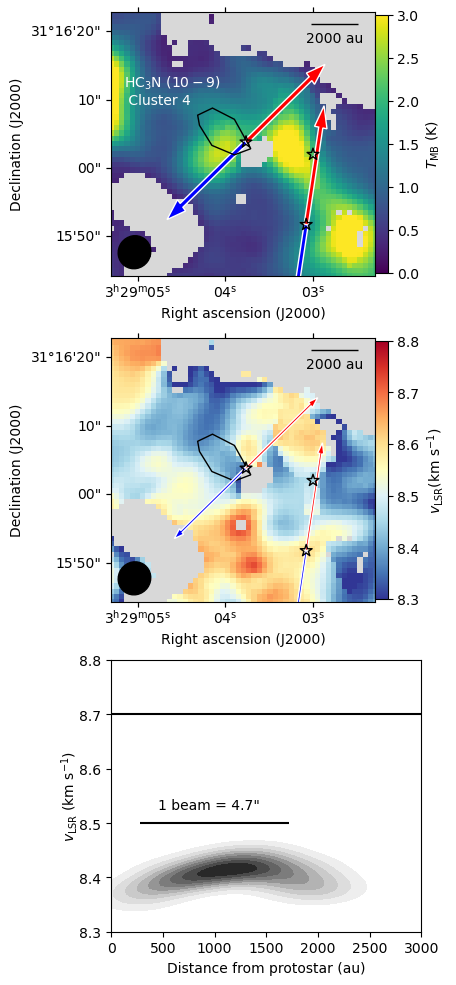

In [91]:
fig = plt.figure(figsize=(4,12))
ax = fig.add_subplot(311, projection=svs13a_wcsskyhc3n)
map = svs13a_hc3ncluster[0]
map2 = svs13a_hc3ncluster[1]
cmap = cm.get_cmap('viridis').copy()
cmap.set_bad('0.85')
cmap2 = cm.get_cmap('RdYlBu_r').copy()
cmap2.set_bad('0.85')
tmin = 0
tmax = 3
vmin = 8.3
vmax = 8.8
label = r'$T_{\mathrm{MB}}$ (K)'#r'$v_{\mathrm{LSR}}$(km s$^{-1}$)'

sc1 = ax.imshow(map, cmap=cmap, vmin=tmin, vmax=tmax)
fig.colorbar(sc1, ax=ax, label=label, pad=-0.002, shrink=0.95)
reg_load_pix = svs13a_region.to_pixel(svs13a_wcsskyhc3n)
reg_load_pix.visual['edgecolor'] = 'black'
reg_load_pix.plot(ax=ax, zorder=100)
ax.scatter(catalog_protostars.loc[12, 'RAJ2000'], catalog_protostars.loc[12, 'DEJ2000'], transform=ax.get_transform('world'), marker='*', s=80, ec ='k', fc='None', zorder=100)
ax.scatter(catalog_protostars.loc[6, 'RAJ2000'], catalog_protostars.loc[6, 'DEJ2000'], transform=ax.get_transform('world'), marker='*', s=80, ec ='k', fc='None', zorder=100)
ax.scatter(catalog_protostars.loc[7, 'RAJ2000'], catalog_protostars.loc[7, 'DEJ2000'], transform=ax.get_transform('world'), marker='*', s=80, ec ='k', fc='None', zorder=100)
ax.scatter(catalog_protostars.loc[8, 'RAJ2000'], catalog_protostars.loc[8, 'DEJ2000'], transform=ax.get_transform('world'), marker='*', s=80, ec ='k', fc='None', zorder=100)
ax.arrow(catalog_protostars.loc[8, 'RAJ2000'], catalog_protostars.loc[8, 'DEJ2000'],  0.004*np.sin((170*u.deg).to(u.rad).value), 0.004*np.cos((170*u.deg).to(u.rad).value), transform=ax.get_transform('world'), fc='b', ec='w', width=0.0002)
ax.arrow(catalog_protostars.loc[8, 'RAJ2000'], catalog_protostars.loc[8, 'DEJ2000'],  -0.004*np.sin((170*u.deg).to(u.rad).value), -0.004*np.cos((170*u.deg).to(u.rad).value), transform=ax.get_transform('world'), fc='r', ec='w', width=0.0002)
#ax.scatter(catalog_protostars.loc[7, 'RAJ2000'], catalog_protostars.loc[7, 'DEJ2000'], transform=ax.get_transform('world'), marker='*', s=80, ec ='k', fc='None', zorder=100)
add_beam(ax, major=bmaj, minor=bmin, angle=bpa, color='k', pad=0.1)
ax.annotate('HC$_3$N ($10-9$)\n Cluster 4', (0.05, 0.65), xycoords='axes fraction', fontsize=10, color='w')
# ax.annotate('N$_2$H$^+$ ($1-0$)\n Cluster 0', (0.6, 0.55), xycoords='axes fraction', fontsize=10, color='w')
add_scalebar(ax, 2000/293*u.arcsec, corner='top right', label='2000 au', color='k')
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')
# outflow
ax.arrow(catalog_protostars.loc[6, 'RAJ2000'], catalog_protostars.loc[6, 'DEJ2000'],  0.004*np.sin((130*u.deg).to(u.rad).value), 0.004*np.cos((130*u.deg).to(u.rad).value), transform=ax.get_transform('world'), fc='b', ec='w', width=0.0002)
ax.arrow(catalog_protostars.loc[6, 'RAJ2000'], catalog_protostars.loc[6, 'DEJ2000'],  -0.004*np.sin((130*u.deg).to(u.rad).value), -0.004*np.cos((130*u.deg).to(u.rad).value), transform=ax.get_transform('world'), fc='r', ec='w', width=0.0002)
# ax.arrow(catalog_protostars.loc[10, 'RAJ2000'], catalog_protostars.loc[10, 'DEJ2000'],  0.004*np.sin((170*u.deg).to(u.rad).value), 0.004*np.cos((170*u.deg).to(u.rad).value), transform=ax.get_transform('world'), fc='b', ec='w', width=0.0002)
# ax.arrow(catalog_protostars.loc[10, 'RAJ2000'], catalog_protostars.loc[10, 'DEJ2000'],  -0.004*np.sin((170*u.deg).to(u.rad).value), -0.004*np.cos((170*u.deg).to(u.rad).value), transform=ax.get_transform('world'), fc='r', ec='w', width=0.0002)
ax.set_xlim([18, np.shape(map)[1]-18])
ax.set_ylim([18, np.shape(map)[0]-18])

ax3 = fig.add_subplot(312, projection=svs13a_wcsskyhc3n)
sc2 = ax3.imshow(map2, cmap=cmap2, vmin=vmin, vmax=vmax)
fig.colorbar(sc2, ax=ax3, label=r'$v_{\mathrm{LSR}}$(km s$^{-1}$)', pad=-0.002, shrink=0.95)
reg_load_pix.plot(ax=ax3)
# outflow
ax3.arrow(catalog_protostars.loc[6, 'RAJ2000'], catalog_protostars.loc[6, 'DEJ2000'],  0.004*np.sin((130*u.deg).to(u.rad).value), 0.004*np.cos((130*u.deg).to(u.rad).value), transform=ax3.get_transform('world'), fc='b', ec='w', width=0.0001)
ax3.arrow(catalog_protostars.loc[6, 'RAJ2000'], catalog_protostars.loc[6, 'DEJ2000'],  -0.004*np.sin((130*u.deg).to(u.rad).value), -0.004*np.cos((130*u.deg).to(u.rad).value), transform=ax3.get_transform('world'), fc='r', ec='w', width=0.0001)
ax3.scatter(catalog_protostars.loc[12, 'RAJ2000'], catalog_protostars.loc[12, 'DEJ2000'], transform=ax3.get_transform('world'), marker='*', s=80, ec ='k', fc='None', zorder=100)
ax3.scatter(catalog_protostars.loc[6, 'RAJ2000'], catalog_protostars.loc[6, 'DEJ2000'], transform=ax3.get_transform('world'), marker='*', s=80, ec ='k', fc='None', zorder=100)
ax3.scatter(catalog_protostars.loc[7, 'RAJ2000'], catalog_protostars.loc[7, 'DEJ2000'], transform=ax3.get_transform('world'), marker='*', s=80, ec ='k', fc='None', zorder=100)
ax3.scatter(catalog_protostars.loc[8, 'RAJ2000'], catalog_protostars.loc[8, 'DEJ2000'], transform=ax3.get_transform('world'), marker='*', s=80, ec ='k', fc='None', zorder=100)
ax3.arrow(catalog_protostars.loc[8, 'RAJ2000'], catalog_protostars.loc[8, 'DEJ2000'],  0.004*np.sin((170*u.deg).to(u.rad).value), 0.004*np.cos((170*u.deg).to(u.rad).value), transform=ax3.get_transform('world'), fc='b', ec='w', width=0.0001)
ax3.arrow(catalog_protostars.loc[8, 'RAJ2000'], catalog_protostars.loc[8, 'DEJ2000'],  -0.004*np.sin((170*u.deg).to(u.rad).value), -0.004*np.cos((170*u.deg).to(u.rad).value), transform=ax3.get_transform('world'), fc='r', ec='w', width=0.0001)
lon = ax3.coords[0]
lat = ax3.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')
ax3.set_xlim([18, np.shape(map)[1]-18])
ax3.set_ylim([18, np.shape(map)[0]-18])
add_beam(ax3, major=bmaj, minor=bmin, angle=bpa, color='k', pad=0.1)
add_scalebar(ax3, 2000/293*u.arcsec, corner='top right', label='2000 au')

xx, yy, zz = do_kde(svs13a_hc3ncluster[1], svs13a_hc3nhead, catalog_protostars.loc[6, 'RAJ2000'], catalog_protostars.loc[6, 'DEJ2000'], 
                    reg_load_pix, 293, 0, 3000, vmin, vmax)
ax2 = fig.add_subplot(313)
ax2.contourf(xx, yy, zz, cmap='Greys', levels=np.arange(0.1, 1.2, 0.1), vmin=0., vmax=1.1)
ax2.set_ylim([vmin, vmax])
ax2.set_xlabel('Distance from protostar (au)')
ax2.set_ylabel(r'$v_{\mathrm{LSR}}$ (km s$^{-1}$)',labelpad=-0.1)
ax2.hlines(y=8.5, xmin=1000-(bmaj.to(u.arcsec).value/2*293), xmax=1000+(bmaj.to(u.arcsec).value/2*293), color='k')
ax2.annotate('1 beam = 4.7"', (0.15, 0.45), xycoords='axes fraction')
ax2.axhline(svs13a_vlsr, color='k')
fig.savefig('figures/zoom_svs13a_hc3n_tmb.pdf', bbox_inches='tight', dpi=300)


/tmp/ipykernel_5410/3035608019.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis').copy()
/tmp/ipykernel_5410/3035608019.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmaptransparent = cm.get_cmap('viridis').copy()
/tmp/ipykernel_5410/3035608019.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap('RdYlBu_r').copy()
/tmp/ipykernel_5410/3035608019.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in

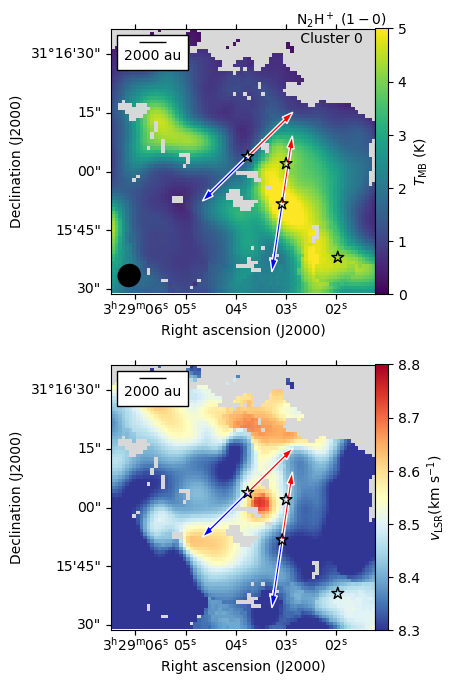

In [80]:
fig, [ax, ax2] = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, figsize=(4,8), subplot_kw={'projection': svs13a_wcsskyn2hp})
# fig.subplots_adjust(wspace=0, hspace=0)
# fig = plt.figure(figsize=(4,8))
# ax = fig.add_subplot(211, projection=iras4b_wcsskyhc3n)
map = svs13a_n2hpcluster[0]
map2 = svs13a_n2hpcluster[1]
cmap = cm.get_cmap('viridis').copy()
cmap.set_bad('0.85')
cmaptransparent = cm.get_cmap('viridis').copy()
cmaptransparent.set_bad('0.85', alpha=0)
cmap2 = cm.get_cmap('RdYlBu_r').copy()
cmap2.set_bad('0.85')
cmap2transparent = cm.get_cmap('RdYlBu_r').copy()
cmap2transparent.set_bad('0.85', alpha=0)
tmin=0
tmax=5
vmin = 8.3
vmax = 8.8
label = r'$T_{\mathrm{MB}}$ (K)'#r'$v_{\mathrm{LSR}}$(km s$^{-1}$)'

sc1 = ax.imshow(map, cmap=cmap, vmin=tmin, vmax=tmax)
fig.colorbar(sc1, ax=ax, label=label, pad=-0.002, shrink=0.95)
# outflow
ax.arrow(catalog_protostars.loc[6, 'RAJ2000'], catalog_protostars.loc[6, 'DEJ2000'],  0.004*np.sin((130*u.deg).to(u.rad).value), 0.004*np.cos((130*u.deg).to(u.rad).value), transform=ax.get_transform('world'), fc='b', ec='w', width=0.0002)
ax.arrow(catalog_protostars.loc[6, 'RAJ2000'], catalog_protostars.loc[6, 'DEJ2000'],  -0.004*np.sin((130*u.deg).to(u.rad).value), -0.004*np.cos((130*u.deg).to(u.rad).value), transform=ax.get_transform('world'), fc='r', ec='w', width=0.0002)

ax.scatter(catalog_protostars.loc[12, 'RAJ2000'], catalog_protostars.loc[12, 'DEJ2000'], transform=ax.get_transform('world'), marker='*', s=80, ec ='k', fc='None', zorder=100)
ax.scatter(catalog_protostars.loc[6, 'RAJ2000'], catalog_protostars.loc[6, 'DEJ2000'], transform=ax.get_transform('world'), marker='*', s=80, ec ='k', fc='None', zorder=100)
ax.scatter(catalog_protostars.loc[7, 'RAJ2000'], catalog_protostars.loc[7, 'DEJ2000'], transform=ax.get_transform('world'), marker='*', s=80, ec ='k', fc='None', zorder=100)
ax.scatter(catalog_protostars.loc[8, 'RAJ2000'], catalog_protostars.loc[8, 'DEJ2000'], transform=ax.get_transform('world'), marker='*', s=80, ec ='k', fc='None', zorder=100)
ax.arrow(catalog_protostars.loc[8, 'RAJ2000'], catalog_protostars.loc[8, 'DEJ2000'],  0.004*np.sin((170*u.deg).to(u.rad).value), 0.004*np.cos((170*u.deg).to(u.rad).value), transform=ax.get_transform('world'), fc='b', ec='w', width=0.0002)
ax.arrow(catalog_protostars.loc[8, 'RAJ2000'], catalog_protostars.loc[8, 'DEJ2000'],  -0.004*np.sin((170*u.deg).to(u.rad).value), -0.004*np.cos((170*u.deg).to(u.rad).value), transform=ax.get_transform('world'), fc='r', ec='w', width=0.0002)
add_beam(ax, major=bmajn2hp, minor=bminn2hp, angle=bpan2hp, color='k', pad=0.1)
ax.annotate('N$_2$H$^+$ ($1-0$)\n Cluster 0', (0.7, 0.95), xycoords='axes fraction', fontsize=10)
add_scalebar(ax, 2000/293*u.arcsec, corner='top left', label='2000 au', frame=True)
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')

sc2 = ax2.imshow(map2, cmap=cmap2, vmin=vmin, vmax=vmax)
ax2.scatter(catalog_protostars.loc[12, 'RAJ2000'], catalog_protostars.loc[12, 'DEJ2000'], transform=ax2.get_transform('world'), marker='*', s=80, ec ='k', fc='None', zorder=100)
ax2.scatter(catalog_protostars.loc[6, 'RAJ2000'], catalog_protostars.loc[6, 'DEJ2000'], transform=ax2.get_transform('world'), marker='*', s=80, ec ='k', fc='None', zorder=100)
ax2.scatter(catalog_protostars.loc[7, 'RAJ2000'], catalog_protostars.loc[7, 'DEJ2000'], transform=ax2.get_transform('world'), marker='*', s=80, ec ='k', fc='None', zorder=100)
ax2.scatter(catalog_protostars.loc[8, 'RAJ2000'], catalog_protostars.loc[8, 'DEJ2000'], transform=ax2.get_transform('world'), marker='*', s=80, ec ='k', fc='None', zorder=100)
ax2.arrow(catalog_protostars.loc[8, 'RAJ2000'], catalog_protostars.loc[8, 'DEJ2000'],  0.004*np.sin((170*u.deg).to(u.rad).value), 0.004*np.cos((170*u.deg).to(u.rad).value), transform=ax2.get_transform('world'), fc='b', ec='w', width=0.0002)
ax2.arrow(catalog_protostars.loc[8, 'RAJ2000'], catalog_protostars.loc[8, 'DEJ2000'],  -0.004*np.sin((170*u.deg).to(u.rad).value), -0.004*np.cos((170*u.deg).to(u.rad).value), transform=ax2.get_transform('world'), fc='r', ec='w', width=0.0002)
# outflow
ax2.arrow(catalog_protostars.loc[6, 'RAJ2000'], catalog_protostars.loc[6, 'DEJ2000'],  0.004*np.sin((130*u.deg).to(u.rad).value), 0.004*np.cos((130*u.deg).to(u.rad).value), transform=ax2.get_transform('world'), fc='b', ec='w', width=0.0002)
ax2.arrow(catalog_protostars.loc[6, 'RAJ2000'], catalog_protostars.loc[6, 'DEJ2000'],  -0.004*np.sin((130*u.deg).to(u.rad).value), -0.004*np.cos((130*u.deg).to(u.rad).value), transform=ax2.get_transform('world'), fc='r', ec='w', width=0.0002)

fig.colorbar(sc2, ax=ax2, label=r'$v_{\mathrm{LSR}}$(km s$^{-1}$)', pad=-0.002, shrink=0.95)
lon = ax2.coords[0]
lat = ax2.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')
add_scalebar(ax2, 2000/293*u.arcsec, corner='top left', label='2000 au', frame=True)

fig.savefig('figures/zoom_svs13a_n2hp_tmb_vlsr.pdf', bbox_inches='tight', dpi=300)


### All streamers together

In [86]:
# important functions
shapemap = np.shape(svs13a_hc3ncluster[0])
cmap1 = cm.get_cmap('viridis').copy()
cmap1.set_bad('0.85')
cmaptransparent = cm.get_cmap('viridis').copy()
cmaptransparent.set_bad('0.85', alpha=0)
cmap2 = cm.get_cmap('RdYlBu_r').copy()
cmap2.set_bad('0.85')
cmap2transparent = cm.get_cmap('RdYlBu_r').copy()
cmap2transparent.set_bad('0.85', alpha=0)

def do_image(ax, image, cmap, region, protostars, vmin, vmax, wcs, label=r'$T_{\mathrm{MB}}$ (K)', beam=True, scalebar=False, scalebar_size=2000,
             outflows=False, outflow_list=None, outflow_angles=None):
    ax.set_xticks([])
    sc = ax.imshow(image, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_xlim([18, shapemap[1]-18])
    ax.set_ylim([18, shapemap[0]-18])
    cax = fig.add_axes([ax.get_position().x1,ax.get_position().y0,0.01,ax.get_position().height])
    cb = fig.colorbar(sc, cax=cax)
    cb.set_label(label, labelpad=0)
    reg_load_pix = region.to_pixel(wcs)
    reg_load_pix.visual['edgecolor'] = 'black'
    reg_load_pix.plot(ax=ax, zorder=100)
    for i in protostars:
        ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'],
                  transform=ax.get_transform('world'), marker='*', s=80, ec ='k', fc='None', zorder=100)
    lon = ax.coords[0]
    lat = ax.coords[1]
    lon.set_ticklabel_visible(False)
    lon.set_ticks_visible(False)
    lat.set_ticklabel_visible(False)
    lat.set_ticks_visible(False)
    
    if beam:
        add_beam(ax, major=bmaj, minor=bmin, angle=bpa, color='k', pad=0.1)
    if scalebar:
        add_scalebar(ax, scalebar_size/293*u.arcsec, corner='top right', label='{} au'.format(scalebar_size), color='k')
    if outflows:
        for i, ang in zip(outflow_list, outflow_angles):
            ax.arrow(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'],  0.004*np.sin((ang*u.deg).to(u.rad).value),
                0.004*np.cos((ang*u.deg).to(u.rad).value), transform=ax.get_transform('world'), fc='b', ec='w', width=0.0002)
            ax.arrow(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'],  -0.004*np.sin((ang*u.deg).to(u.rad).value), 
                -0.004*np.cos((ang*u.deg).to(u.rad).value), transform=ax.get_transform('world'), fc='r', ec='w', width=0.0002)
    

def do_kde_plot(ax, image, header, protostar, region, vmin, vmax, wcs, vlsr, max_dist=3000):
    reg_load_pix = region.to_pixel(wcs)
    xx, yy, zz = do_kde(image, header, catalog_protostars.loc[protostar, 'RAJ2000'], catalog_protostars.loc[protostar, 'DEJ2000'], 
                        reg_load_pix, 293, 0, max_dist, vmin, vmax)
    ax.contourf(xx, yy, zz, cmap='Greys', levels=np.arange(0.1, 1.2, 0.1), vmin=0., vmax=1.1)
    ax.set_ylim([vmin, vmax])
    ax.axhline(vlsr, color='k')
    ax.hlines(y=vmin+0.1, xmin=1000-(bmaj.to(u.arcsec).value/2*293), xmax=1000+(bmaj.to(u.arcsec).value/2*293), color='k')
    ax.vlines([1000-(bmaj.to(u.arcsec).value/2*293),1000+(bmaj.to(u.arcsec).value/2*293)], ymin=vmin+0.15, ymax=vmin+0.05, color='k')


/tmp/ipykernel_5150/2450530886.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap1 = cm.get_cmap('viridis').copy()
/tmp/ipykernel_5150/2450530886.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmaptransparent = cm.get_cmap('viridis').copy()
/tmp/ipykernel_5150/2450530886.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap('RdYlBu_r').copy()
/tmp/ipykernel_5150/2450530886.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in 

/tmp/ipykernel_5150/2412344006.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  centerxsmall, centerysmall = int(centerxsmall), int(centerysmall)
/tmp/ipykernel_5150/2412344006.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  centerxsmall, centerysmall = int(centerxsmall), int(centerysmall)
/tmp/ipykernel_5150/2412344006.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  centerxsmall, centerysmall = int(centerxsmall), int(centerysmall)


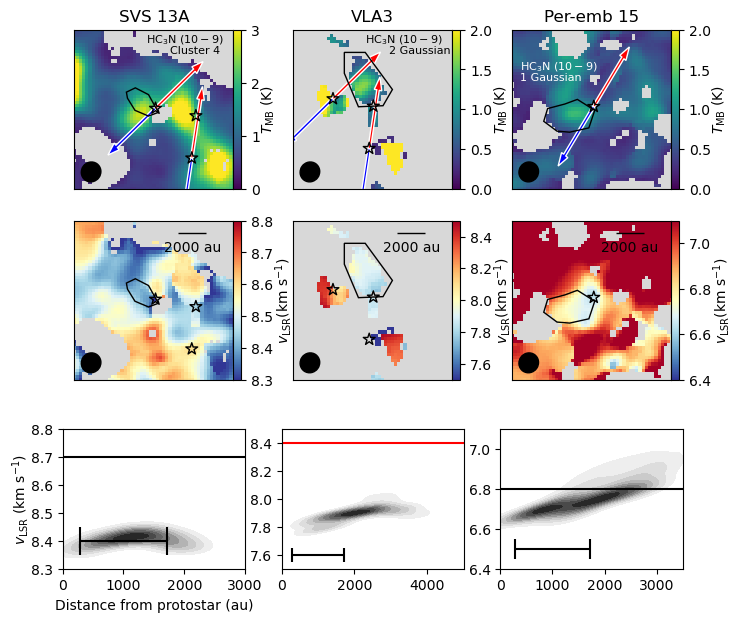

In [59]:
fig = plt.figure(figsize=(8, 7))
spec = fig.add_gridspec(nrows=2, ncols=1, height_ratios=[2.5,1])
spec_images = gridspec.GridSpecFromSubplotSpec(nrows=2, ncols=3, subplot_spec = spec[0])
spec_kde = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=3, subplot_spec = spec[1])
#svs13a
ax1_svs13 = fig.add_subplot(spec_images[0,0], projection=svs13a_wcsskyhc3n)
do_image(ax1_svs13, svs13a_hc3ncluster[0], cmap1, svs13a_region, [12, 6, 7, 8], 0, 3, svs13a_wcsskyhc3n, 
         beam=True, outflows=True, outflow_list=[8,6], outflow_angles=[170, 130])
ax1_svs13.annotate('HC$_3$N ($10-9$)', (0.45, 0.92), xycoords='axes fraction', fontsize=8, color='k')
ax1_svs13.annotate('Cluster 4', (0.6, 0.85), xycoords='axes fraction', fontsize=8, color='k')
ax1_svs13.set_title('SVS 13A')
ax2_svs13 = fig.add_subplot(spec_images[1,0], projection=svs13a_wcsskyhc3n)
do_image(ax2_svs13, svs13a_hc3ncluster[1], cmap2, svs13a_region, [12, 6, 7, 8], 8.3, 8.8, svs13a_wcsskyhc3n, label=r'$v_{\mathrm{LSR}}$(km s$^{-1}$)',
         scalebar=True)
ax3_svs13 = fig.add_subplot(spec_kde[0])
do_kde_plot(ax3_svs13, svs13a_hc3ncluster[1], svs13a_hc3nhead, 6, svs13a_region, 8.3, 8.8, svs13a_wcsskyhc3n, svs13a_vlsr)
ax3_svs13.set_xlabel('Distance from protostar (au)')
ax3_svs13.set_ylabel(r'$v_{\mathrm{LSR}}$ (km s$^{-1}$)',labelpad=-0.1)

# VLA 3
ax1_vla3 = fig.add_subplot(spec_images[0,1], projection=vla3_wcsskyhc3n)
do_image(ax1_vla3, vla3_hc3ncluster[0], cmap1, vla3_region, [12,6,7,8], 0, 2, vla3_wcsskyhc3n, 
         beam=True, outflows=True,outflow_list=[8,6], outflow_angles=[170, 130])
ax1_vla3.set_title('VLA3')
ax1_vla3.annotate('HC$_3$N ($10-9$)', (0.45, 0.92), xycoords='axes fraction', fontsize=8, color='k')
ax1_vla3.annotate('2 Gaussian', (0.6, 0.85), xycoords='axes fraction', fontsize=8, color='k')
ax2_vla3 = fig.add_subplot(spec_images[1,1], projection=vla3_wcsskyhc3n)
do_image(ax2_vla3, vla3_hc3ncluster[1], cmap2, vla3_region, [12,6,7,8], 7.5, 8.5, vla3_wcsskyhc3n, 
         label=r'$v_{\mathrm{LSR}}$(km s$^{-1}$)', scalebar=True)
ax3_vla3 = fig.add_subplot(spec_kde[1])
do_kde_plot(ax3_vla3, vla3_hc3ncluster[1], vla3_hc3nhead, 12, vla3_region, 7.5, 8.5, vla3_wcsskyhc3n, 0, max_dist=5000)
ax3_vla3.axhline(8.4, color='r')

# Per-emb-15
ax1_per15 = fig.add_subplot(spec_images[0,2], projection=per15_wcsskyhc3n)
do_image(ax1_per15, per15_hc3ncluster[0], cmap1, per15_region, [3], 0, 2, per15_wcsskyhc3n, 
         beam=True, outflows=True, outflow_list=[3], outflow_angles=[145])
ax1_per15.annotate('HC$_3$N ($10-9$)', (0.05, 0.75), xycoords='axes fraction', fontsize=8, color='w')
ax1_per15.annotate('1 Gaussian', (0.05, 0.68), xycoords='axes fraction', fontsize=8, color='w')
ax1_per15.set_title('Per-emb 15')
ax2_per15 = fig.add_subplot(spec_images[1,2], projection=per15_wcsskyhc3n)
do_image(ax2_per15, per15_hc3ncluster[1], cmap2, per15_region, [3], 6.4, 7.1, per15_wcsskyhc3n, 
         label=r'$v_{\mathrm{LSR}}$(km s$^{-1}$)', scalebar=True)
ax3_per15 = fig.add_subplot(spec_kde[2])
do_kde_plot(ax3_per15, per15_hc3ncluster[1], per15_hc3nhead, 3, per15_region, 6.4, 7.1, per15_wcsskyhc3n, per15_vlsr, max_dist=3500)
# # IRAS 4A
# ax1_iras4a = fig.add_subplot(spec_images[0,1], projection=iras4a_wcsskyhc3n)
# do_image(ax1_iras4a, iras4a_hc3ncluster[0], cmap1, iras4a_region, [0,1], 0, 2, iras4a_wcsskyhc3n, 
#          beam=True, outflows=True, outflow_list=[0,1], outflow_angles=[19, 176])

# ax1_iras4a.set_title('IRAS 4A')
# ax1_iras4a.annotate('HC$_3$N ($10-9$) \n Cluster 7', (0.6, 0.05), xycoords='axes fraction', fontsize=10)
# ax2_iras4a = fig.add_subplot(spec_images[1,1], projection=iras4a_wcsskyhc3n)
# do_image(ax2_iras4a, iras4a_hc3ncluster[1], cmap2, iras4a_region, [0,1], iras4a_vlsr-0.3, iras4a_vlsr+0.3, iras4a_wcsskyhc3n, 
#          label=r'$v_{\mathrm{LSR}}$(km s$^{-1}$)', scalebar=True)
# ax3_iras4a = fig.add_subplot(spec_kde[1])
# do_kde_plot(ax3_iras4a, iras4a_hc3ncluster[1], iras4a_hc3nhead, 0, iras4a_region, iras4a_vlsr-0.3,iras4a_vlsr+0.3, iras4a_wcsskyhc3n, iras4a_vlsr)
# ax3_iras4a.set_ylim([6.6, 7.2])
# ax3_iras4a.hlines(y=7.15, xmin=2000-(bmaj.to(u.arcsec).value/2*293), xmax=2000+(bmaj.to(u.arcsec).value/2*293), color='k')
# ax3_iras4a.annotate('1 beam = 4.7"', (0.55, 0.95), xycoords='axes fraction')
# # if we want to add the streamer
# Mtot = 2.3 *u.Msun
# r0 = 3000 * u.au
# theta0 = 92 * u.deg  # rotate clockwise
# phi0 = -5 * u.deg
# v_r0 = 0.0 * u.km/u.s
# omega0 = 2.3e-13 / u.s
# inc = (-35) * u.deg
# PA_ang = (19)*u.deg
# fil0, dsky0, velo0 = get_streamer(Mtot, catalog_protostars.loc[0, 'vlsr']*u.km/u.s, r0, theta0, phi0, 
#                                   omega0, v_r0, inc, PA_ang, 293, catalog_protostars.loc[0, 'RAJ2000'], 
#                                   catalog_protostars.loc[0, 'DEJ2000'])
# line_image, = ax1_iras4a.plot(fil0.ra, fil0.dec, transform=ax1_iras4a.get_transform('fk5'), ls='-', lw=2, color='w')
# line_vel, = ax3_iras4a.plot(dsky0, velo0)

fig.savefig('figures/zoom_streamers_group_svs13group.pdf', bbox_inches='tight', dpi=100)

/tmp/ipykernel_5150/2412344006.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  centerxsmall, centerysmall = int(centerxsmall), int(centerysmall)
/tmp/ipykernel_5150/2412344006.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  centerxsmall, centerysmall = int(centerxsmall), int(centerysmall)
/tmp/ipykernel_5150/2412344006.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  centerxsmall, centerysmall = int(centerxsmall), int(centerysmall)
/tmp/ipykernel_5150/24

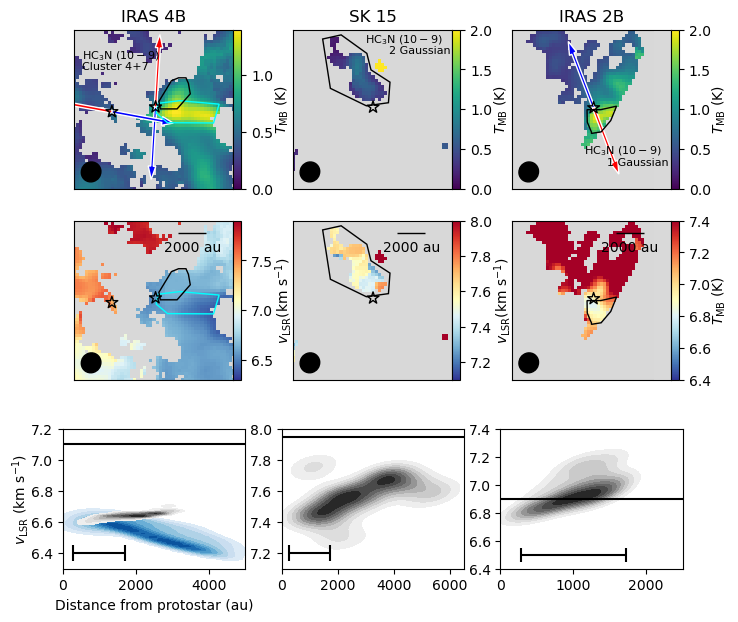

In [103]:
fig = plt.figure(figsize=(8, 7))
spec = fig.add_gridspec(nrows=2, ncols=1, height_ratios=[2.5,1])
spec_images = gridspec.GridSpecFromSubplotSpec(nrows=2, ncols=3, subplot_spec = spec[0])
spec_kde = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=3, subplot_spec = spec[1])

# IRAS 4B
ax1_iras4b = fig.add_subplot(spec_images[0,0], projection=iras4b_wcsskyhc3n)
ax1_iras4b.set_title('IRAS 4B')
do_image(ax1_iras4b, iras4b_hc3ncluster[0], cmap1, iras4b_region, [0,1,9], 0, 1.4, iras4b_wcsskyhc3n, 
        beam=True, outflows=True, outflow_list=[1,9], outflow_angles=[176, -99])
ax1_iras4b.imshow(iras4b_hc3ncluster2[0], cmap=cmaptransparent, vmin=0, vmax=1.4)
ax1_iras4b.annotate('HC$_3$N ($10-9$)', (0.05, 0.82), xycoords='axes fraction', fontsize=8, color='k')
ax1_iras4b.annotate('Cluster 4+7', (0.05, 0.75), xycoords='axes fraction', fontsize=8, color='k')
reg_load_pix2 = iras4b_region_outflow.to_pixel(iras4b_wcsskyhc3n)
reg_load_pix2.visual['edgecolor'] = 'cyan'
reg_load_pix2.plot(ax=ax1_iras4b)
ax2_iras4b = fig.add_subplot(spec_images[1,0], projection=iras4b_wcsskyhc3n)
do_image(ax2_iras4b, iras4b_hc3ncluster[1], cmap2, iras4b_region, [0,1,9], iras4b_vlsr-0.8, iras4b_vlsr+0.8, iras4b_wcsskyhc3n, 
         label=r'$v_{\mathrm{LSR}}$(km s$^{-1}$)', scalebar=True)
reg_load_pix2.plot(ax=ax2_iras4b)
ax2_iras4b.imshow(iras4b_hc3ncluster2[1], cmap=cmap2transparent, vmin=iras4b_vlsr-0.8, vmax=iras4b_vlsr+0.8)
ax3_iras4b = fig.add_subplot(spec_kde[0])
do_kde_plot(ax3_iras4b, iras4b_hc3ncluster[1], iras4b_hc3nhead, 1, iras4b_region, iras4b_vlsr-0.8, iras4b_vlsr+0.8, iras4b_wcsskyhc3n, iras4b_vlsr, max_dist=5000)
ax3_iras4b.set_xlabel('Distance from protostar (au)')
ax3_iras4b.set_ylabel(r'$v_{\mathrm{LSR}}$ (km s$^{-1}$)',labelpad=-0.1)
ax3_iras4b.set_ylim([6.3, 7.2])
# ax3_iras4b.hlines(y=6.9+0.1, xmin=1000-(bmaj.to(u.arcsec).value/2*293), xmax=1000+(bmaj.to(u.arcsec).value/2*293), color='k')
# ax3_iras4b.vlines([1000-(bmaj.to(u.arcsec).value/2*293),1000+(bmaj.to(u.arcsec).value/2*293)], ymin=6.9+0.15, ymax=6.9+0.05, color='k')
xx2, yy2, zz2 = do_kde(iras4b_hc3ncluster[1], iras4b_hc3nhead, catalog_protostars.loc[1, 'RAJ2000'], catalog_protostars.loc[1, 'DEJ2000'], 
                    reg_load_pix2, 293, 0, 5000, iras4b_vlsr-1, iras4b_vlsr+1)
ax3_iras4b.contourf(xx2, yy2, zz2, cmap='Blues', levels=np.arange(0.1, 1.2, 0.1), vmin=0., vmax=1.1, zorder=0)

# SK 15
ax1_sk15 = fig.add_subplot(spec_images[0,1], projection=sk15_wcsskyhc3n)
ax1_sk15.set_title('SK 15')
do_image(ax1_sk15, sk15_hc3ncluster[0], cmap1, sk15_region, [13], 0, 2, sk15_wcsskyhc3n, beam=True)
ax1_sk15.annotate('HC$_3$N ($10-9$)', (0.45, 0.92), xycoords='axes fraction', fontsize=8, color='k')
ax1_sk15.annotate('2 Gaussian', (0.6, 0.85), xycoords='axes fraction', fontsize=8, color='k')
ax2_sk15 = fig.add_subplot(spec_images[1,1], projection=sk15_wcsskyhc3n)
do_image(ax2_sk15, sk15_hc3ncluster[1], cmap2, sk15_region, [13], 7.1, 8., sk15_wcsskyhc3n, label=r'$v_{\mathrm{LSR}}$(km s$^{-1}$)', beam=True, scalebar=True)
ax3_sk15 = fig.add_subplot(spec_kde[1])
do_kde_plot(ax3_sk15, sk15_hc3ncluster[1], sk15_hc3nhead, 13, sk15_region, 7.1, 8., sk15_wcsskyhc3n, sk15_vlsr, max_dist=6500)

# IRAS 2B
ax1_iras2b = fig.add_subplot(spec_images[0,2], projection=iras2b_wcsskyhc3n)
ax1_iras2b.set_title('IRAS 2B')
do_image(ax1_iras2b, iras2b_hc3ncluster[0], cmap1, iras2b_region, [5], 0, 2, iras2b_wcsskyhc3n, beam=True, 
         outflows=True, outflow_list=[5], outflow_angles=[24])
ax1_iras2b.set_facecolor('0.85')
ax1_iras2b.annotate('HC$_3$N ($10-9$)', (0.45, 0.22), xycoords='axes fraction', fontsize=8, color='k')
ax1_iras2b.annotate('1 Gaussian', (0.6, 0.15), xycoords='axes fraction', fontsize=8, color='k')
ax2_iras2b = fig.add_subplot(spec_images[1,2], projection=iras2b_wcsskyhc3n)
do_image(ax2_iras2b, iras2b_hc3ncluster[1], cmap2, iras2b_region, [5], iras2b_vlsr-0.5, iras2b_vlsr+0.5, iras2b_wcsskyhc3n, beam=True, scalebar=True)
ax2_iras2b.set_facecolor('0.85')
ax3_iras2b = fig.add_subplot(spec_kde[2])
do_kde_plot(ax3_iras2b, iras2b_hc3ncluster[1], iras2b_hc3nhead, 5, iras2b_region, iras2b_vlsr-0.5, iras2b_vlsr+0.5, iras2b_wcsskyhc3n, iras2b_vlsr, max_dist=2500)

fig.savefig('figures/zoom_streamers_group_iras2_iras4group.pdf', bbox_inches='tight', dpi=100)